# Machine Learning for Equipment Failure Prediction (PM)

# Installing Libraries

 Install all of the relevant Python Libraries

In [ ]:
!pip install scikit-learn> /dev/null 2>&1
!pip install imbalanced-learn> /dev/null 2>&1
#!pip install imbalanced-learn -- upgrade
!pip install plotly> /dev/null 2>&1
!pip install chart-studio> /dev/null 2>&1
!pip install mlflow> /dev/null 2>&1
!pip install mlflow --quiet > /dev/null 2>&1
!pip install pyngrok --quiet > /dev/null 2>&1
!pip install wandb > /dev/null 2>&1
!pip install joblib > /dev/null 2>&1

Import required libraries

In [ ]:
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly as plotly
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from sklearn import metrics

import seaborn
from sklearn.preprocessing import LabelEncoder
import wandb
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import mlflow
import types
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import mlflow
import mlflow.sklearn
from sklearn.metrics import precision_score, f1_score, roc_auc_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import wandb
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from datetime import datetime, timedelta
from sklearn.metrics import accuracy_score

def __iter__(self): return 0




Import the data from GitHub.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/PA_Arbeit')

In [ ]:

# Convert csv to pandas dataframe
# pd_data = pd.read_csv("interrupt_clean.csv", sep=",", header=0)

# Data Exporation <a id="explore"></a>

In [ ]:
pd_data.head()

NameError: ignored

In [ ]:
column_types = pd_data.dtypes
print(column_types)

NameError: ignored

Now that we have the data imported into a Jupiter Notebook, we can explore it.


error04 — A ‘1’ means that the equipment returned this error.

Our first goal in this project is to build a model that predicts equipment failure. In other words, we will use the other variables in the data frame to predict error04.

Now we will walk through the data.




Examine the number of rows and columns.  The data has 307,751 rows and 16 columns.

In [ ]:

pd_data.shape

(214786, 29)

Is there duplicates of id?

In [ ]:

xxxx = pd.DataFrame(pd_data.groupby(['id']).agg(['count']))
xxxx.shape

(213490, 28)

In [ ]:
duplicate_count = pd_data[pd_data.duplicated(subset=['id'], keep=False)].shape[0]
duplicate_count

1726

In [ ]:
duplicate_indices = pd_data[pd_data.duplicated(subset=['id'], keep=False)].index.tolist()
duplicate_indices[1:10]

[551, 552, 553, 560, 561, 562, 563, 570, 571]

551, 552, .. are the same except column deltaerro03!

In [ ]:
pd_data_1 = pd_data.copy(deep=True)

In [ ]:
# Drop duplicates based on the 'id' column, keeping the first occurrence, and store in a new DataFrame
pd_data_1 = pd_data.drop_duplicates(subset=['id'], keep='first')

In [ ]:
pd_data_1.shape

(213490, 29)

2286 Machines:

In [ ]:

xxxx = pd.DataFrame(pd_data_1.groupby(['DeviceSerial']).agg(['count']))
xxxx.shape

(2286, 28)

In [ ]:
xxxx = pd.DataFrame(pd_data_1.groupby(['InterruptCode']).agg(['count']))
xxxx.shape

(176, 28)

Look for null values in the fields.

In [ ]:
pd_data_1.isnull().sum(axis = 0)

id                      0
ErrorCode               0
Start                   0
ConditionType           0
InterruptCode         357
AccountNumber           0
DeviceSerial            0
ZCCVersion              0
FirmwareVersion         0
MaterialName            0
Method               5206
ToolInsert           5206
Index              191656
Module             209516
error03                 0
error04                 0
date                    0
Device                  0
deltaerror03         6328
deltaerror04       208707
target2                 0
target3                 0
target4                 0
target5                 0
target7                 0
target14                0
target30                0
target45                0
target60                0
dtype: int64

In [ ]:
null_count_column = pd_data_1['InterruptCode'].isnull().sum()
null_count_column

357

For 357 Values, it is assumed that null value in interrupt code cell means error03 and error04 column ist 0:

In [ ]:
null_indices = pd_data_1[pd_data_1['InterruptCode'].isnull()].index.tolist()
null_indices[0:10]

[44580, 44581, 44582, 44583, 44584, 44585, 44586, 44587, 44588, 44589]

Now let’s examine the dependent variable in more detail. It appears that out of 213490 records, we only have 5933 04 failures. This corresponds to a failure rate of about 2.85%. This data set is very unbalanced. Later in this Notebook, I will use a few techniques to mitigate the impact of a small number of observed failures.

In [ ]:
xxxx = pd.DataFrame(pd_data_1.groupby(['error04'])['id'].agg('count'))
xxxx

,id
error04,
0,207557
1,5933


We can also explore the data with descriptive statistics.

In [ ]:
pd_data_1.describe()

,id,ErrorCode,AccountNumber,Index,Module,error03,error04,target2,target3,target4,target5,target7,target14,target30,target45,target60
count,2.134900e+05,213490.0,213490.000000,21834.000000,3974.000000,213490.000000,213490.000000,213490.0,213490.0,213490.0,213490.0,213490.0,213490.0,213490.0,213490.0,213490.0
mean,4.283827e+07,267.0,66807.081198,178.002244,1.774283,0.970359,0.027791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,2.215523e+07,0.0,5173.780508,672.455091,0.762600,0.169594,0.164373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,6.052881e+06,267.0,50101.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,2.391724e+07,267.0,63285.000000,2.000000,1.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,4.163842e+07,267.0,68124.000000,4.000000,2.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,6.228694e+07,267.0,70763.000000,20.000000,2.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,8.078289e+07,267.0,79931.000000,9182.000000,3.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
column_types = pd_data_1.dtypes
print(column_types)

id                   int64
ErrorCode            int64
Start               object
ConditionType       object
InterruptCode       object
AccountNumber        int64
DeviceSerial        object
ZCCVersion          object
FirmwareVersion     object
MaterialName        object
Method              object
ToolInsert          object
Index              float64
Module             float64
error03              int64
error04              int64
date                object
Device              object
deltaerror03        object
deltaerror04        object
target2              int64
target3              int64
target4              int64
target5              int64
target7              int64
target14             int64
target30             int64
target45             int64
target60             int64
dtype: object


In [ ]:
# Convert 'Start' to datetime and extract relevant time features
pd_data_1['Start'] = pd.to_datetime(pd_data_1['Start'])
pd_data_1['Hour'] = pd_data_1['Start'].dt.hour
pd_data_1['DayOfWeek'] = pd_data_1['Start'].dt.dayofweek
pd_data_1['Month'] = pd_data_1['Start'].dt.month

<ipython-input-138-1d1ecb815f75>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_data_1['Start'] = pd.to_datetime(pd_data_1['Start'])
<ipython-input-138-1d1ecb815f75>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_data_1['Hour'] = pd_data_1['Start'].dt.hour
<ipython-input-138-1d1ecb815f75>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [ ]:
column_types = pd_data_1.dtypes
print(column_types)

id                          int64
ErrorCode                   int64
Start              datetime64[ns]
ConditionType              object
InterruptCode              object
AccountNumber               int64
DeviceSerial               object
ZCCVersion                 object
FirmwareVersion            object
MaterialName               object
Method                     object
ToolInsert                 object
Index                     float64
Module                    float64
error03                     int64
error04                     int64
date                       object
Device                     object
deltaerror03               object
deltaerror04               object
target2                     int64
target3                     int64
target4                     int64
target5                     int64
target7                     int64
target14                    int64
target30                    int64
target45                    int64
target60                    int64
Hour          

In [ ]:
subset = pd_data_1.loc[0:10, ['Start', 'Month','DayOfWeek','Hour']]
subset

,Start,Month,DayOfWeek,Hour
0,2022-04-19 16:57:43.358,4,1,16
1,2022-04-19 21:17:02.131,4,1,21
2,2022-04-20 00:59:45.952,4,2,0
3,2022-04-20 01:25:54.003,4,2,1
4,2022-04-20 01:41:04.544,4,2,1
5,2022-04-20 01:41:09.333,4,2,1
6,2022-04-20 02:14:03.352,4,2,2
7,2022-04-20 02:15:32.052,4,2,2
8,2022-04-20 02:15:35.989,4,2,2
9,2022-04-20 02:15:39.752,4,2,2


In [ ]:
# Convert the deltaerror03 and deltaerror04 column to pandas Timedelta type
pd_data_1['deltaerror03'] = pd.to_timedelta(pd_data_1['deltaerror03'])

# Separate into different components
pd_data_1['deltaerror03_days'] = pd_data_1['deltaerror03'].dt.days
pd_data_1['deltaerror03_hours'] = pd_data_1['deltaerror03'].dt.components.hours
pd_data_1['deltaerror03_minutes'] = pd_data_1['deltaerror03'].dt.components.minutes

<ipython-input-141-801577e1221f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_data_1['deltaerror03'] = pd.to_timedelta(pd_data_1['deltaerror03'])
<ipython-input-141-801577e1221f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_data_1['deltaerror03_days'] = pd_data_1['deltaerror03'].dt.days
<ipython-input-141-801577e1221f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [ ]:
subset = pd_data_1.loc[49:59, ['deltaerror03', 'deltaerror03_days','deltaerror03_hours','deltaerror03_minutes']]
subset

,deltaerror03,deltaerror03_days,deltaerror03_hours,deltaerror03_minutes
49,1 days 06:36:00,1.0,6.0,36.0
50,NaT,NaN,NaN,NaN
51,0 days 02:15:00,0.0,2.0,15.0
52,0 days 16:28:00,0.0,16.0,28.0
53,1 days 10:21:00,1.0,10.0,21.0
54,0 days 00:07:00,0.0,0.0,7.0
55,0 days 00:50:00,0.0,0.0,50.0
56,0 days 00:51:00,0.0,0.0,51.0
57,0 days 00:26:00,0.0,0.0,26.0
58,0 days 00:10:00,0.0,0.0,10.0


In [ ]:
#Convert the deltaerror03 and deltaerror04 column to pandas Timedelta type
pd_data_1['deltaerror04'] = pd.to_timedelta(pd_data_1['deltaerror04'])

# Separate into different components
pd_data_1['deltaerror04_days'] = pd_data_1['deltaerror04'].dt.days
pd_data_1['deltaerror04_hours'] = pd_data_1['deltaerror04'].dt.components.hours
pd_data_1['deltaerror04_minutes'] = pd_data_1['deltaerror04'].dt.components.minutes

In [ ]:
subset = pd_data_1.loc[49:59, ['deltaerror04', 'deltaerror04_days','deltaerror04_hours','deltaerror04_minutes']]
subset

,deltaerror04,deltaerror04_days,deltaerror04_hours,deltaerror04_minutes
49,NaT,NaN,NaN,NaN
50,NaT,NaN,NaN,NaN
51,NaT,NaN,NaN,NaN
52,NaT,NaN,NaN,NaN
53,NaT,NaN,NaN,NaN
54,NaT,NaN,NaN,NaN
55,NaT,NaN,NaN,NaN
56,NaT,NaN,NaN,NaN
57,NaT,NaN,NaN,NaN
58,NaT,NaN,NaN,NaN


In [ ]:
# # Save the DataFrame to a new CSV file
pd_data_1.to_csv('pd_data_1.csv', index=False)

In [ ]:
# Use the parquet file below for reading instead of read_csv
# pd_data_1 = pd.read_csv("pd_data_1.csv", sep=",", header=0)

In [ ]:
# Save as Parquet
pd_data_1.to_parquet('pd_data_1.parquet')

In [ ]:
# Read from Parquet
pd_data_1 = pd.read_parquet('pd_data_1.parquet')

Remember that the dtypes changes after saving and reading to drive

In [ ]:
column_types = pd_data_1.dtypes
print(column_types)

id                                int64
ErrorCode                         int64
Start                    datetime64[ns]
ConditionType                    object
InterruptCode                    object
AccountNumber                     int64
DeviceSerial                     object
ZCCVersion                       object
FirmwareVersion                  object
MaterialName                     object
Method                           object
ToolInsert                       object
Index                           float64
Module                          float64
error03                           int64
error04                           int64
date                             object
Device                           object
deltaerror03            timedelta64[ns]
deltaerror04                     object
target2                           int64
target3                           int64
target4                           int64
target5                           int64
target7                           int64


In [ ]:
# Create a deep copy
pd_data_2 = pd_data_1.copy(deep=True)

# Define target columns and their corresponding days
target_columns = ['target2', 'target3', 'target4', 'target5', 'target7', 'target14', 'target30', 'target45', 'target60']
days_list = [2, 3, 4, 5, 7, 14, 30, 45, 60]

# Initialize target columns with zeros
for target in target_columns:
    pd_data_2[target] = 0

# Sort by DeviceSerial and Start
pd_data_2.sort_values(by=['DeviceSerial', 'Start'], inplace=True)

# Function to populate target columns
def populate_targets(group):
    group = group.reset_index(drop=True)
    for idx, row in group.iterrows():
        start_time = row['Start']
        for target, days in zip(target_columns, days_list):
            end_time = start_time + pd.Timedelta(days=days)
            future_errors = group[(group['Start'] > start_time) & (group['Start'] <= end_time) & (group['error04'] == 1)]
            if not future_errors.empty:
                group.loc[idx, target] = 1
    return group

# Group by DeviceSerial and apply the function
pd_data_2 = pd_data_2.groupby('DeviceSerial').apply(populate_targets).reset_index(drop=True)


In [ ]:
pd_data_2.head(10)

As you see below the number of 1s increase as the number of days increase:

In [ ]:
# Create a dictionary to hold the count of each target column

target_count_matrix = {}



# Loop through each target column and calculate the count

for target in target_columns:

    target_count_matrix[target] = pd_data_2[target].value_counts()



# Convert the dictionary to a DataFrame

target_count_df = pd.DataFrame(target_count_matrix)



target_count_df

,target2,target3,target4,target5,target7,target14,target30,target45,target60
0,198705,193977,190586,186979,179497,160973,132993,119048,111827
1,14785,19513,22904,26511,33993,52517,80497,94442,101663


In [ ]:

# Create the DataFrame
data = {
    "target2": [198705, 14785],
    "target3": [193977, 19513],
    "target4": [190586, 22904],
    "target5": [186979, 26511],
    "target7": [179497, 33993],
    "target14": [160973, 52517],
    "target30": [132993, 80497],
    "target45": [119048, 94442],
    "target60": [111827, 101663]
}

df = pd.DataFrame(data)

# Calculate Random Baseline Precision
random_baseline_precision = {}
for col in df.columns:
    total = df[col].sum()
    tp = df[col][1]
    fp = df[col][0]
    random_baseline_precision[col] = tp / (tp + fp)

# Display the result
print("Random Baseline Precision for each target:")
print(random_baseline_precision)


Random Baseline Precision for each target:
{'target2': 0.06925382921916717, 'target3': 0.09140006557684201, 'target4': 0.10728371352288163, 'target5': 0.12417911845988103, 'target7': 0.15922525645229285, 'target14': 0.24599278654737927, 'target30': 0.37705278935781533, 'target45': 0.44237200805658344, 'target60': 0.47619560635158553}


In [ ]:
import pandas as pd

# Create a dictionary with the calculated values
random_baseline_precision = {
    'target2': 0.06925382921916717,
    'target3': 0.09140006557684201,
    'target4': 0.10728371352288163,
    'target5': 0.12417911845988103,
    'target7': 0.15922525645229285,
    'target14': 0.24599278654737927,
    'target30': 0.37705278935781533,
    'target45': 0.44237200805658344,
    'target60': 0.47619560635158553
}

# Convert the dictionary to a DataFrame
df_random_baseline_precision = pd.DataFrame(list(random_baseline_precision.items()), columns=['Target', 'Random Baseline Precision'])

# Print the DataFrame
print(df_random_baseline_precision)


     Target  Random Baseline Precision
0   target2                   0.069254
1   target3                   0.091400
2   target4                   0.107284
3   target5                   0.124179
4   target7                   0.159225
5  target14                   0.245993
6  target30                   0.377053
7  target45                   0.442372
8  target60                   0.476196


## Creating pd_data_2

In [ ]:
# Save the DataFrame to a new CSV file
pd_data_2.to_csv('pd_data_2.csv', index=False)

In [ ]:
# Use the parquet file below for reading instead of read_csv
# pd_data_2 = pd.read_csv("pd_data_2.csv", sep=",", header=0)

In [ ]:
# Save as Parquet
# pd_data_2.to_parquet('pd_data_2.parquet')

In [ ]:
# Read from Parquet
pd_data_2 = pd.read_parquet('pd_data_2.parquet')

Remember that the dtypes changes after saving and reading to drive

---



In [ ]:
pd_data_2.head(10)

,id,ErrorCode,Start,ConditionType,InterruptCode,AccountNumber,DeviceSerial,ZCCVersion,FirmwareVersion,MaterialName,...,target60,Hour,DayOfWeek,Month,deltaerror03_days,deltaerror03_hours,deltaerror03_minutes,deltaerror04_days,deltaerror04_hours,deltaerror04_minutes
0,23654903,267,2022-04-19 16:57:43.358,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,16,1,4,0.0,0.0,0.0,NaN,NaN,NaN
1,23682300,267,2022-04-19 21:17:02.131,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,21,1,4,0.0,4.0,19.0,NaN,NaN,NaN
2,23696827,267,2022-04-20 00:59:45.952,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,0,2,4,0.0,3.0,43.0,NaN,NaN,NaN
3,23698562,267,2022-04-20 01:25:54.003,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,1,2,4,0.0,0.0,26.0,NaN,NaN,NaN
4,23699564,267,2022-04-20 01:41:04.544,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,1,2,4,0.0,0.0,15.0,NaN,NaN,NaN
5,23699566,267,2022-04-20 01:41:09.333,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,1,2,4,0.0,0.0,0.0,NaN,NaN,NaN
6,23701665,267,2022-04-20 02:14:03.352,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,2,2,4,0.0,0.0,33.0,NaN,NaN,NaN
7,23702675,267,2022-04-20 02:15:32.052,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,2,2,4,0.0,0.0,1.0,NaN,NaN,NaN
8,23702679,267,2022-04-20 02:15:35.989,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,2,2,4,0.0,0.0,0.0,NaN,NaN,NaN
9,23702691,267,2022-04-20 02:15:39.752,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,2,2,4,0.0,0.0,0.0,NaN,NaN,NaN


# Visualization

## error03 and error04 distribution

In [ ]:
pd_data_2['Start'] = pd.to_datetime(pd_data_2['Start'])
# Sort by 'Start'
pd_data_2 = pd_data_2.sort_values('Start')


<ipython-input-9-791aafc7e0c6>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_data = pd_data_2.set_index('Start').resample('D').sum()
<ipython-input-9-791aafc7e0c6>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_subset = subset.set_index('Start').resample('D').sum()
<ipython-input-9-791aafc7e0c6>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_subset = subset.set_index('Start').resamp

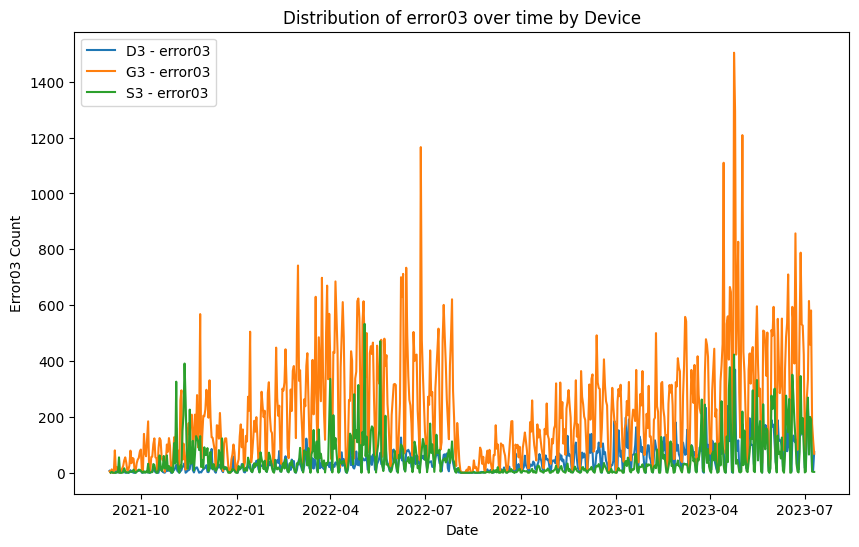

<ipython-input-9-791aafc7e0c6>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_subset = subset.set_index('Start').resample('D').sum()
<ipython-input-9-791aafc7e0c6>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_subset = subset.set_index('Start').resample('D').sum()
<ipython-input-9-791aafc7e0c6>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_subset = subset.set_index('Start').resamp

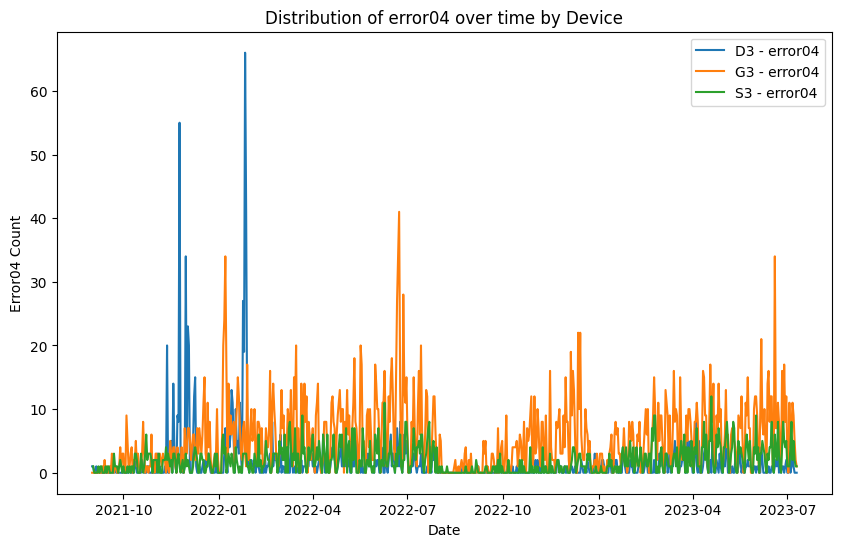

In [ ]:
import matplotlib.pyplot as plt

# Resampling the data by day and summing up the errors
resampled_data = pd_data_2.set_index('Start').resample('D').sum()

# Plotting for error03
plt.figure(figsize=(10, 6))  # Optional: set figure size
for device in pd_data_2['Device'].unique():
    subset = pd_data_2[pd_data_2['Device'] == device]
    resampled_subset = subset.set_index('Start').resample('D').sum()
    plt.plot(resampled_subset.index, resampled_subset['error03'], label=f"{device} - error03")

plt.xlabel('Date')
plt.ylabel('Error03 Count')
plt.legend()
plt.title('Distribution of error03 over time by Device')
plt.show()

# Plotting for error04
plt.figure(figsize=(10, 6))  # Optional: set figure size
for device in pd_data_2['Device'].unique():
    subset = pd_data_2[pd_data_2['Device'] == device]
    resampled_subset = subset.set_index('Start').resample('D').sum()
    plt.plot(resampled_subset.index, resampled_subset['error04'], label=f"{device} - error04")

plt.xlabel('Date')
plt.ylabel('Error04 Count')
plt.legend()
plt.title('Distribution of error04 over time by Device')
plt.show()


## Error03 vs Error04 for Each device with pd_data_4

In [ ]:
pd_data_4 = pd.read_parquet('pd_data_4.parquet')
pd_data_4 = pd_data_4.sort_values('Start')
pd_data_4['Device'] = pd_data_4['DeviceSerial'].str[:2]

In [ ]:
pd_data_4.head(10)

,Start,date,id,ErrorCode,ConditionType,InterruptCode,AccountNumber,DeviceSerial,ZCCVersion,FirmwareVersion,...,InterruptCode_00032404_rolling_avg,InterruptCode_0001f703_rolling_avg,InterruptCode_00026103_rolling_avg,InterruptCode_00018e03_rolling_avg,InterruptCode_0000e204_rolling_avg,InterruptCode_0003cc03_rolling_avg,InterruptCode_0001b003_rolling_avg,InterruptCode_0001fb03_rolling_avg,error03_rolling_avg,error04_rolling_avg
2102,2021-09-01 00:47:49.655,2021-09-01,6288331.0,267.0,Critical,0001b003,56329.0,D300L320022,3.5.1.27,1.76.1.30079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2103,2021-09-01 00:50:41.540,2021-09-01,6288333.0,267.0,Critical,0001b003,56329.0,D300L320022,3.5.1.27,1.76.1.30079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
378099,2021-09-01 02:24:41.332,2021-09-01,6319719.0,267.0,Critical,0003ef03,69096.0,G33XL320621,3.4.2.22,1.71.3.20061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2104,2021-09-01 02:42:57.625,2021-09-01,6288425.0,267.0,nan,Unknown,56329.0,D300L320022,3.5.1.27,1.76.1.30079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2105,2021-09-01 02:44:17.702,2021-09-01,6288427.0,267.0,nan,Unknown,56329.0,D300L320022,3.5.1.27,1.76.1.30079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2106,2021-09-01 03:06:04.691,2021-09-01,6288454.0,267.0,nan,Unknown,56329.0,D300L320022,3.5.1.27,1.76.1.30079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2107,2021-09-01 03:10:20.655,2021-09-01,6288459.0,267.0,Critical,0001b003,56329.0,D300L320022,3.5.1.27,1.76.1.30079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
378100,2021-09-01 03:40:40.354,2021-09-01,6319751.0,267.0,nan,Unknown,69096.0,G33XL320621,3.4.2.22,1.71.3.20061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
359650,2021-09-01 11:34:22.412,2021-09-01,6205592.0,267.0,Critical,00039b03,57725.0,G33XL320389,3.5.3.29,1.73.1.30009,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
239834,2021-09-01 12:12:57.014,2021-09-01,6217497.0,267.0,Critical,0001b403,79900.0,G30XL320728,3.5.5.200,1.78.0.30301,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


<ipython-input-9-10a6d99178d9>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_data = pd_data_4.set_index('Start').resample('D').sum()
<ipython-input-9-10a6d99178d9>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_subset = subset.set_index('Start').resample('D').sum()
<ipython-input-9-10a6d99178d9>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_subset = subset.set_index('Start').resamp

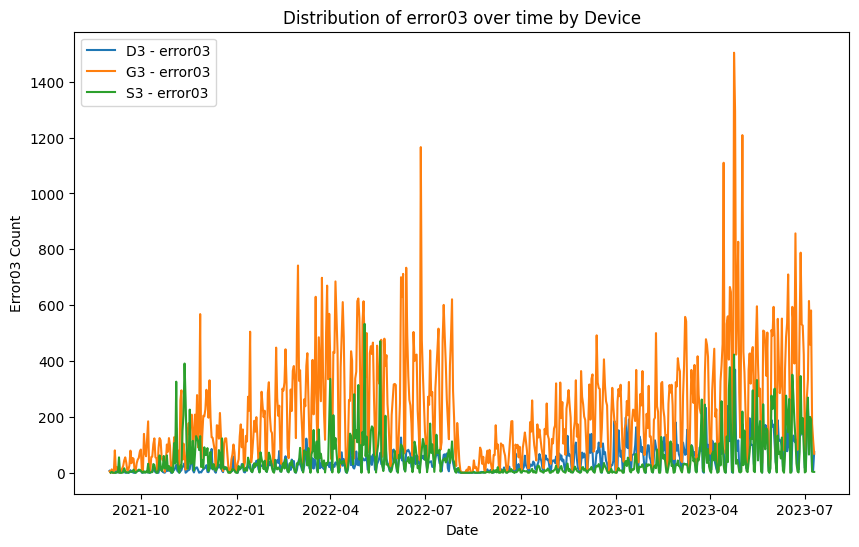

<ipython-input-9-10a6d99178d9>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_subset = subset.set_index('Start').resample('D').sum()
<ipython-input-9-10a6d99178d9>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_subset = subset.set_index('Start').resample('D').sum()
<ipython-input-9-10a6d99178d9>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_subset = subset.set_index('Start').resamp

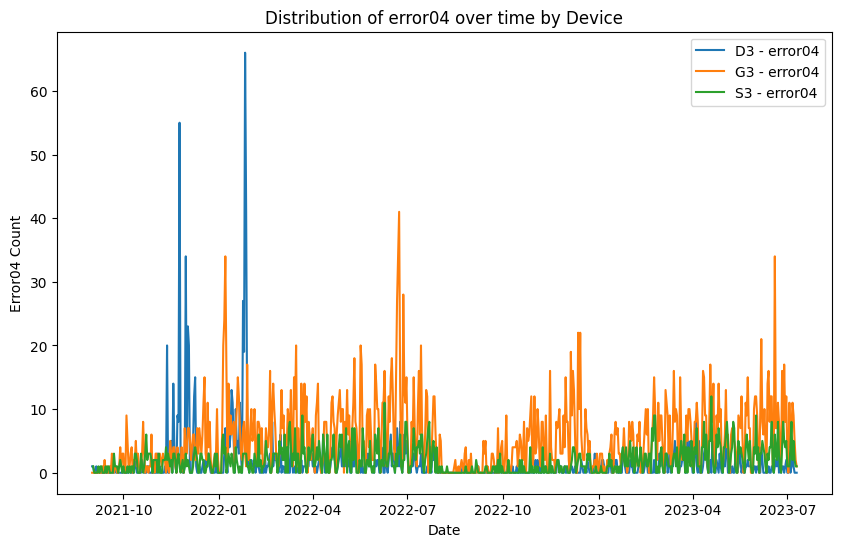

In [ ]:
import matplotlib.pyplot as plt

# Resampling the data by day and summing up the errors
resampled_data = pd_data_4.set_index('Start').resample('D').sum()

# Plotting for error03
plt.figure(figsize=(10, 6))  # Optional: set figure size
for device in pd_data_4['Device'].unique():
    subset = pd_data_4[pd_data_4['Device'] == device]
    resampled_subset = subset.set_index('Start').resample('D').sum()
    plt.plot(resampled_subset.index, resampled_subset['error03'], label=f"{device} - error03")

plt.xlabel('Date')
plt.ylabel('Error03 Count')
plt.legend()
plt.title('Distribution of error03 over time by Device')
plt.show()

# Plotting for error04
plt.figure(figsize=(10, 6))  # Optional: set figure size
for device in pd_data_4['Device'].unique():
    subset = pd_data_4[pd_data_4['Device'] == device]
    resampled_subset = subset.set_index('Start').resample('D').sum()
    plt.plot(resampled_subset.index, resampled_subset['error04'], label=f"{device} - error04")

plt.xlabel('Date')
plt.ylabel('Error04 Count')
plt.legend()
plt.title('Distribution of error04 over time by Device')
plt.show()


Explanation:

  Custom Function: calculate_error03_sum checks if 'error04' is 1 for a row. If so, it calculates the sum of 'error03' for the same DeviceSerial in the two weeks preceding that 'error04' occurrence.

  Applying the Function: We use df.apply() to apply this function to each row. This step might be time-consuming for large datasets, as it involves a lot of filtering.

  Visualization: The scatter plot shows each 'error04' occurrence on the x-axis (the date it occurred) and the sum of 'error03' occurrences in the preceding two weeks on the y-axis. This visualization helps in identifying any patterns or correlations between the occurrence of 'error04' and the sum of 'error03' in the prior two weeks.

  Performance Note: This script can be slow on large datasets because it involves iterating over rows and repeatedly filtering the DataFrame. If performance is an issue, consider optimizing the data processing part, possibly by using more efficient data structures or parallel processing.

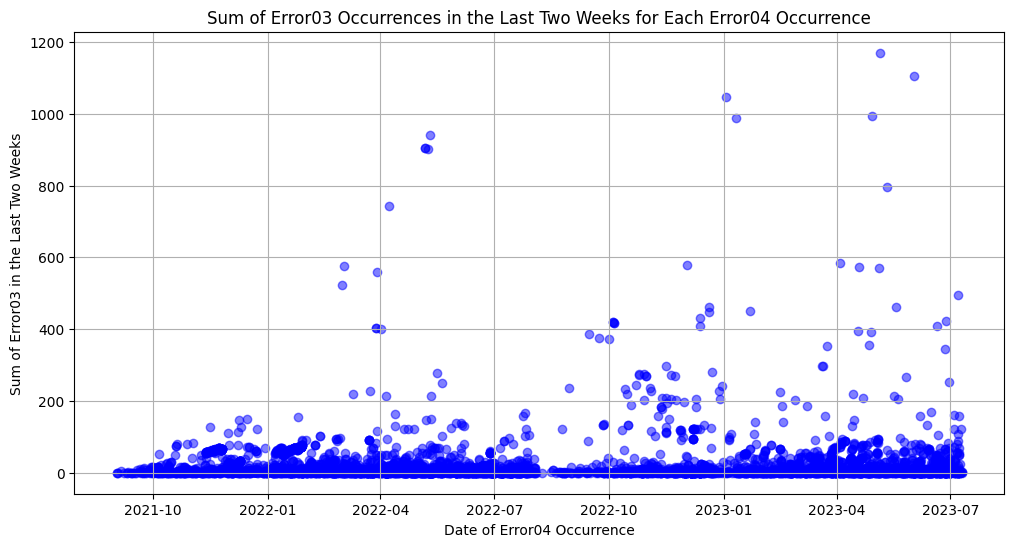

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df=pd_data_4.copy(deep=True)
# Assuming you have a DataFrame named df with columns: 'Start', 'error03', 'error04', 'DeviceSerial'
# Make sure 'Start' is in datetime format
df['Start'] = pd.to_datetime(df['Start'])

# Function to find the sum of error03 in the last two weeks for each error04 occurrence
def calculate_error03_sum(row):
    if row['error04'] == 1:
        start_period = row['Start'] - pd.Timedelta(days=14)
        end_period = row['Start']
        return df[(df['DeviceSerial'] == row['DeviceSerial']) &
                  (df['Start'] >= start_period) &
                  (df['Start'] < end_period)]['error03'].sum()
    else:
        return None

# Apply the function to each row
df['error03_sum'] = df.apply(calculate_error03_sum, axis=1)

# Filter out rows where error03_sum is None
df_analysis = df.dropna(subset=['error03_sum'])

# Plotting
plt.figure(figsize=(12, 6))
plt.scatter(df_analysis['Start'], df_analysis['error03_sum'], c='blue', alpha=0.5)
plt.title('Sum of Error03 Occurrences in the Last Two Weeks for Each Error04 Occurrence')
plt.xlabel('Date of Error04 Occurrence')
plt.ylabel('Sum of Error03 in the Last Two Weeks')
plt.grid(True)
plt.show()


In [ ]:
df_analysis.to_csv("df_analysis.csv")

In [ ]:
df_analysis.describe

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-b81d414e07c9>", line 1, in <cell line: 1>
    df_analysis.summary
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/generic.py", line 5902, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'summary'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.

Explanation:

  Data Preparation: The script iterates over each 'error04' occurrence, filters the data for the respective device and the two-week period before the 'error04' occurrence, and then aggregates 'error03' counts by day.
  Heatmap Creation: The aggregated counts are used to create a heatmap with seaborn. Each column represents a device, and each row represents a day in the two-week period. The color intensity reflects the frequency of 'error03' occurrences.

Another effective visualization approach for your scenario is to create a series of line plots, one for each device, showing the trend of 'error03' occurrences in the two-week period leading up to each 'error04' occurrence. This will allow you to visually inspect whether there's an increase in 'error03' events before an 'error04' event, and how this pattern varies across different devices.

Explanation:

  Data Preparation: The script processes each device separately, and for each 'error04' occurrence, it aggregates 'error03' counts by day in the preceding two-week period.
  Line Plots: Each subplot represents a different device, and within each subplot, there are multiple lines, each corresponding to a two-week period leading up to a different 'error04' event. This way, you can see if there's a consistent pattern in 'error03' occurrences before 'error04' events for each device.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
df=pd_data_4.copy(deep=True)
# Assuming your DataFrame df is set up correctly
df['Start'] = pd.to_datetime(df['Start'])

# Filter to get rows where error04 is 1
error04_occurrences = df[df['error04'] == 1]

# Path in your Google Drive where you want to save the PDF
pdf_file_path = 'Device_Error_Report.pdf'  # Modify the path as needed

with PdfPages(pdf_file_path) as pdf:
    for device in error04_occurrences['DeviceSerial'].unique():
        fig, ax = plt.subplots(figsize=(10, 6))

        for _, row in error04_occurrences[error04_occurrences['DeviceSerial'] == device].iterrows():
            start_period = row['Start'] - pd.Timedelta(days=14)
            end_period = row['Start']
            temp_df = df[(df['DeviceSerial'] == device) & (df['Start'] >= start_period) & (df['Start'] < end_period)]
            daily_counts = temp_df.resample('D', on='Start')['error03'].sum().fillna(0)

            ax.plot(daily_counts.index, daily_counts, label=f'Error04 on {row["Start"].date()}')

        ax.set_title(f'Device {device}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Error03 Count')
        ax.legend()
        ax.grid(True)

        pdf.savefig(fig)
        plt.close(fig)


To summarize, we want to:

    Identify unique interrupt codes that signify an Error04.
    For each unique Error04 interrupt code, calculate the sum of Error03 occurrences in the last two weeks.
    Plot these sums for each Error04 interrupt code in individual graphs.
    Compile all these graphs into a single PDF document.

Here is a Python code snippet that follows these steps:

In [ ]:
interrupt_codes_error0 = df[df['InterruptCode'].str.endswith('04')]['InterruptCode'].unique()

In [ ]:
interrupt_codes_error04.shape

(16,)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

df=pd_data_4.copy(deep=True)
# Convert 'Start' to datetime if not already done
df['Start'] = pd.to_datetime(df['Start'])

# Define a function that calculates the sum of error03s for a given interrupt code
def calculate_error03_sum_for_interrupt_code(df, interrupt_code):
    # Filter df for the specific interrupt code that corresponds to error04
    df_error04 = df[(df['InterruptCode'].str.endswith('04')) & (df['InterruptCode'] == interrupt_code)]

    # Function to calculate the sum of error03
    def calculate_error03_sum(row):
        start_period = row['Start'] - pd.Timedelta(days=14)
        end_period = row['Start']
        return df[(df['DeviceSerial'] == row['DeviceSerial']) &
                  (df['Start'] >= start_period) &
                  (df['Start'] < end_period)]['error03'].sum()

    # Apply the function
    df_error04['error03_sum'] = df_error04.apply(calculate_error03_sum, axis=1)

    return df_error04

# Get the unique interrupt codes that correspond to error04
interrupt_codes_error04 = df[df['InterruptCode'].str.endswith('04')]['InterruptCode'].unique()

# Create a PDF to save all the plots
with PdfPages('error03_error04_analysis.pdf') as pdf:
    for code in interrupt_codes_error04:
        df_code_analysis = calculate_error03_sum_for_interrupt_code(df, code)
        plt.figure(figsize=(12, 6))
        plt.scatter(df_code_analysis['Start'], df_code_analysis['error03_sum'], c='blue', alpha=0.5)
        plt.title(f'Sum of Error03 Occurrences in the Last Two Weeks for Error04: {code}')
        plt.xlabel('Date of Error04 Occurrence')
        plt.ylabel('Sum of Error03 in the Last Two Weeks')
        plt.grid(True)
        pdf.savefig()  # saves the current figure into a pdf page
        plt.close()    # close the figure to prevent it from displaying

print("PDF generated successfully.")


<ipython-input-8-ca0766ef8a40>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_error04['error03_sum'] = df_error04.apply(calculate_error03_sum, axis=1)
<ipython-input-8-ca0766ef8a40>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_error04['error03_sum'] = df_error04.apply(calculate_error03_sum, axis=1)
<ipython-input-8-ca0766ef8a40>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

PDF generated successfully.


<ipython-input-8-ca0766ef8a40>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_error04['error03_sum'] = df_error04.apply(calculate_error03_sum, axis=1)


In [ ]:
df[df['Device']=='NaN']

,Start,date,id,ErrorCode,ConditionType,InterruptCode,AccountNumber,DeviceSerial,ZCCVersion,FirmwareVersion,...,InterruptCode_00032404_rolling_avg,InterruptCode_0001f703_rolling_avg,InterruptCode_00026103_rolling_avg,InterruptCode_00018e03_rolling_avg,InterruptCode_0000e204_rolling_avg,InterruptCode_0003cc03_rolling_avg,InterruptCode_0001b003_rolling_avg,InterruptCode_0001fb03_rolling_avg,error03_rolling_avg,error04_rolling_avg


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

df = pd_data_4.copy(deep=True)
df['Start'] = pd.to_datetime(df['Start'])
df['Device'] = df['DeviceSerial'].str[:2]

device_colors = {'S3': 'red', 'G3': 'green', 'D3': 'blue'}

def calculate_error03_sum_for_interrupt_code(df, interrupt_code):
    df_error04 = df[(df['InterruptCode'].str.endswith('04')) & (df['InterruptCode'] == interrupt_code)]

    def calculate_error03_sum(row):
        start_period = row['Start'] - pd.Timedelta(days=14)
        end_period = row['Start']
        return df[(df['DeviceSerial'] == row['DeviceSerial']) &
                  (df['Start'] >= start_period) &
                  (df['Start'] < end_period)]['error03'].sum()

    df_error04['error03_sum'] = df_error04.apply(calculate_error03_sum, axis=1)

    return df_error04

interrupt_codes_error04 = df[df['InterruptCode'].str.endswith('04')]['InterruptCode'].unique()

with PdfPages('error03_error04_analysis_v5.pdf') as pdf:
    for code in interrupt_codes_error04:
        df_code_analysis = calculate_error03_sum_for_interrupt_code(df, code)

        plt.figure(figsize=(12, 6))
        colors = df_code_analysis['Device'].map(lambda x: device_colors.get(x, 'gray'))

        for device, color in device_colors.items():
            device_data = df_code_analysis[df_code_analysis['Device'] == device]
            plt.scatter(device_data['Start'], device_data['error03_sum'], c=color, alpha=0.5, label=device)

        plt.title(f'Sum of Error03 Occurrences in the Last Two Weeks for Error04: {code}')
        plt.xlabel('Date of Error04 Occurrence')
        plt.ylabel('Sum of Error03 in the Last Two Weeks')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.legend(title='Device Types')

        device_counts = df_code_analysis['Device'].value_counts(dropna=False).to_dict()
        device_counts_str = '\n'.join([f'{k}: {v}' for k, v in device_counts.items()])

        # Calculate and add the percentage of devices with error03_sum > 0
        device_percentage_str = ''
        for device in device_colors.keys():
            total_devices = len(df_code_analysis[df_code_analysis['Device'] == device])
            if total_devices > 0:
                devices_with_error = len(df_code_analysis[(df_code_analysis['Device'] == device) & (df_code_analysis['error03_sum'] > 0)])
                percentage = (devices_with_error / total_devices) * 100
                device_percentage_str += f'\n{device} Error03>0 :\n{percentage:.1f}%'

        plt.text(1.02, 0.98, f'Counts:\n{device_counts_str}{device_percentage_str}',
                 horizontalalignment='left',
                 verticalalignment='top',
                 transform=plt.gca().transAxes,
                 fontsize=8)

        pdf.savefig()
        plt.close()

print("PDF generated successfully.")


<ipython-input-11-dd349587b121>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_error04['error03_sum'] = df_error04.apply(calculate_error03_sum, axis=1)
<ipython-input-11-dd349587b121>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_error04['error03_sum'] = df_error04.apply(calculate_error03_sum, axis=1)
<ipython-input-11-dd349587b121>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

PDF generated successfully.


<ipython-input-11-dd349587b121>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_error04['error03_sum'] = df_error04.apply(calculate_error03_sum, axis=1)


# Experiment 1

## Label encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_columns = ['ConditionType', 'InterruptCode', 'DeviceSerial', 'ZCCVersion', 'FirmwareVersion', 'MaterialName', 'Method', 'ToolInsert', 'Device']
label_encoders = {}

for col in label_columns:
    le = LabelEncoder()
    pd_data_2[col] = le.fit_transform(pd_data_2[col])
    label_encoders[col] = le


In [ ]:
# # Convert float columns to int
# float_to_int_columns = ['deltaerror03_days', 'deltaerror03_hours', 'deltaerror03_minutes', 'deltaerror04_days', 'deltaerror04_hours', 'deltaerror04_minutes']

# for col in float_to_int_columns:
#     pd_data_2[col] = pd_data_2[col].astype('int64')

# # Verify the data types have changed
# print(pd_data_2.dtypes)


In [ ]:
target_columns = ['target2', 'target3', 'target4', 'target5', 'target7', 'target14', 'target30', 'target45', 'target60']
feature_columns = [col for col in pd_data_2.columns if col not in ['id', 'Start','ErrorCode','deltaerror03','deltaerror03_days','deltaerror03_hours','deltaerror03_minutes','deltaerror04','deltaerror04_days','deltaerror04_hours','deltaerror04_minutes','date','Index','Module'] + target_columns]
X = pd_data_2[feature_columns]

In [ ]:
X

,ConditionType,InterruptCode,AccountNumber,DeviceSerial,ZCCVersion,FirmwareVersion,MaterialName,Method,ToolInsert,error03,error04,Device,Hour,DayOfWeek,Month
1306,0,75,56329,9,4,31,1752,8,538,1,0,0,0,2,9
1307,0,75,56329,9,4,31,1752,8,538,1,0,0,0,2,9
132809,0,40,69096,1635,2,18,639,35,373,1,0,1,2,2,9
1308,0,75,56329,9,4,31,1752,8,538,1,0,0,2,2,9
1309,0,75,56329,9,4,31,1752,8,538,1,0,0,2,2,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178400,0,39,72133,1768,7,31,2388,47,296,1,0,1,8,0,7
88620,0,9,70069,1167,6,24,2123,26,556,1,0,1,8,0,7
95434,0,25,52520,1289,5,32,4273,5,555,1,0,1,9,0,7
56063,0,9,68046,610,6,36,1209,24,523,1,0,1,9,0,7


In [ ]:
X.columns

Index(['ConditionType', 'InterruptCode', 'AccountNumber', 'DeviceSerial',
       'ZCCVersion', 'FirmwareVersion', 'MaterialName', 'Method', 'ToolInsert',
       'error03', 'error04', 'Device', 'Hour', 'DayOfWeek', 'Month'],
      dtype='object')

In [ ]:
column_types = X.dtypes
print(column_types)

ConditionType      int64
InterruptCode      int64
AccountNumber      int64
DeviceSerial       int64
ZCCVersion         int64
FirmwareVersion    int64
MaterialName       int64
Method             int64
ToolInsert         int64
error03            int64
error04            int64
Device             int64
Hour               int64
DayOfWeek          int64
Month              int64
dtype: object


In [ ]:
X.describe()# Median and statistics

,ConditionType,InterruptCode,AccountNumber,DeviceSerial,ZCCVersion,FirmwareVersion,MaterialName,Method,ToolInsert,error03,error04,Device,Hour,DayOfWeek,Month
count,213490.0,213490.000000,213490.000000,213490.000000,213490.000000,213490.00000,213490.000000,213490.000000,213490.000000,213490.000000,213490.000000,213490.000000,213490.000000,213490.000000,213490.000000
mean,0.0,37.375025,66807.081198,1191.785915,4.874570,28.87035,2118.951286,25.021603,461.684266,0.970359,0.027791,1.011284,12.309171,2.254349,5.550419
std,0.0,33.801605,5173.780508,669.046050,1.678549,6.53053,1030.567223,18.536814,155.013454,0.169594,0.164373,0.541717,5.729145,1.620314,3.104609
min,0.0,0.000000,50101.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.0,25.000000,63285.000000,564.000000,3.000000,26.00000,1325.000000,5.000000,378.000000,1.000000,0.000000,1.000000,8.000000,1.000000,3.000000
50%,0.0,25.000000,68124.000000,1431.000000,5.000000,29.00000,1908.000000,26.000000,554.000000,1.000000,0.000000,1.000000,12.000000,2.000000,5.000000
75%,0.0,40.000000,70763.000000,1728.000000,6.000000,35.00000,2829.000000,43.000000,556.000000,1.000000,0.000000,1.000000,17.000000,4.000000,7.000000
max,0.0,176.000000,79931.000000,2285.000000,11.000000,40.00000,4285.000000,65.000000,650.000000,1.000000,1.000000,2.000000,23.000000,6.000000,12.000000


In [ ]:
xxx=X.corr( method='pearson')

xxx=xxx[['error04']]
xxx['error04']=abs(xxx['error04'])
xxx=xxx.sort_values(by=['error04'], ascending=[False])
xxx

,error04
error04,1.000000
error03,0.967365
ToolInsert,0.136723
Method,0.121004
InterruptCode,0.104183
MaterialName,0.042007
ZCCVersion,0.029978
AccountNumber,0.028490
DeviceSerial,0.013174
Device,0.008209


Random Forest with Smote

## Train Test Split

In [ ]:
# Initial split: 60% train, 40% temp
X_train, X_temp, y_train, y_temp = train_test_split(X, pd_data_2[target_columns], test_size=0.2, random_state=42)

# Split the 40% temp into half: 20% test, 20% validation
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Trainig

In [ ]:
# Initialize DataFrame for metrics
metrics_df = pd.DataFrame(columns=["Target", "Accuracy", "Precision", "F1-Score", "ROC-AUC", "Recall"])


# Perform SMOTE on the training data
smote = SMOTE(sampling_strategy='auto')

# Initialize WandB
#api_key: 3912dfef304cee9247f066263d8a9867b270fb28
wandb.init(project='PA_ARBEIT', name='Experiment1',settings=wandb.Settings(symlink=False))

config = wandb.config
# Loop through each target column
for target in target_columns:
    # Apply SMOTE to the current target
    X_res, y_res_target = smote.fit_resample(X_train, y_train[target])

    # Train Random Forest model on resampled data
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_res, y_res_target)

    # Save the model as an artifact in Weights and Biases
    model_name = f"random_forest_Experiment_1_{target}.pkl"
    # Save locally
    local_path = "/tmp/" + model_name
    joblib.dump(rf, local_path)

    # Log to Weights and Biases
    wandb.save(local_path)
    !mv /tmp/{model_name} "/content/drive/MyDrive/Colab Notebooks/PA_Arbeit/wandb/models/"

    # Predict on validation set
    y_val_pred = rf.predict(X_val)

    # Evaluate on validation set and log metrics
    metrics = {
        "Accuracy": rf.score(X_val, y_val[target]),
        "Precision": precision_score(y_val[target], y_val_pred),
        "F1-Score": f1_score(y_val[target], y_val_pred),
        "ROC-AUC": roc_auc_score(y_val[target], y_val_pred),
        "Recall": recall_score(y_val[target], y_val_pred)
    }

    # Log metrics to WandB
    for metric_name, metric_value in metrics.items():
        wandb.log({f"{target}_{metric_name}": metric_value})

    # Add metrics to DataFrame
    new_row = {
        "Target": target,
        "Accuracy": metrics["Accuracy"],
        "Precision": metrics["Precision"],
        "F1-Score": metrics["F1-Score"],
        "ROC-AUC": metrics["ROC-AUC"],
        "Recall": metrics["Recall"]
    }
    metrics_df = metrics_df.append(new_row, ignore_index=True)

    print(f"Model for {target} is done")

# Finish the WandB run
wandb.finish()

# Output the metrics DataFrame
print("Metrics DataFrame:")
print(metrics_df)


wandb: Currently logged in as: s-ahmad-hosseini94 (pa_arbeit). Use `wandb login --relogin` to force relogin


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
<ipython-input-19-5b6c1eb32be9>:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target2 is done


<ipython-input-19-5b6c1eb32be9>:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target3 is done


<ipython-input-19-5b6c1eb32be9>:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target4 is done


<ipython-input-19-5b6c1eb32be9>:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target5 is done


<ipython-input-19-5b6c1eb32be9>:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target7 is done


<ipython-input-19-5b6c1eb32be9>:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target14 is done


<ipython-input-19-5b6c1eb32be9>:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target30 is done


<ipython-input-19-5b6c1eb32be9>:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target45 is done
Model for target60 is done


<ipython-input-19-5b6c1eb32be9>:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


BrokenPipeError: ignored

In [ ]:
# Output the metrics DataFrame
print("Metrics DataFrame:")
print(metrics_df)

Metrics DataFrame:
     Target  Accuracy  Precision  F1-Score   ROC-AUC    Recall
0   target2  0.961029   0.687640  0.746341  0.893994  0.816000
1   target3  0.955127   0.716028  0.774376  0.904733  0.843077
2   target4  0.950771   0.737905  0.786599  0.903028  0.842174
3   target5  0.947913   0.760687  0.802557  0.905629  0.849305
4   target7  0.939810   0.779684  0.819091  0.908484  0.862693
5  target14  0.937327   0.853516  0.874766  0.923705  0.897101
6  target30  0.953019   0.937159  0.937798  0.950148  0.938439
7  target45  0.960185   0.959962  0.954979  0.959172  0.950047
8  target60  0.961919   0.964770  0.959972  0.961637  0.955222


In [ ]:
pd_data_2.to_csv('Experiment_1_results.csv', index=False)

# Experiment 2

Random Forest with different train test split procedure

In [ ]:
pd_data_2 = pd.read_parquet('pd_data_2.parquet')

In [ ]:
pd_data_2.head(10)

,id,ErrorCode,Start,ConditionType,InterruptCode,AccountNumber,DeviceSerial,ZCCVersion,FirmwareVersion,MaterialName,...,target60,Hour,DayOfWeek,Month,deltaerror03_days,deltaerror03_hours,deltaerror03_minutes,deltaerror04_days,deltaerror04_hours,deltaerror04_minutes
0,23654903,267,2022-04-19 16:57:43.358,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,16,1,4,0.0,0.0,0.0,NaN,NaN,NaN
1,23682300,267,2022-04-19 21:17:02.131,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,21,1,4,0.0,4.0,19.0,NaN,NaN,NaN
2,23696827,267,2022-04-20 00:59:45.952,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,0,2,4,0.0,3.0,43.0,NaN,NaN,NaN
3,23698562,267,2022-04-20 01:25:54.003,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,1,2,4,0.0,0.0,26.0,NaN,NaN,NaN
4,23699564,267,2022-04-20 01:41:04.544,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,1,2,4,0.0,0.0,15.0,NaN,NaN,NaN
5,23699566,267,2022-04-20 01:41:09.333,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,1,2,4,0.0,0.0,0.0,NaN,NaN,NaN
6,23701665,267,2022-04-20 02:14:03.352,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,2,2,4,0.0,0.0,33.0,NaN,NaN,NaN
7,23702675,267,2022-04-20 02:15:32.052,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,2,2,4,0.0,0.0,1.0,NaN,NaN,NaN
8,23702679,267,2022-04-20 02:15:35.989,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,2,2,4,0.0,0.0,0.0,NaN,NaN,NaN
9,23702691,267,2022-04-20 02:15:39.752,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,2,2,4,0.0,0.0,0.0,NaN,NaN,NaN


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_columns = ['ConditionType', 'InterruptCode', 'DeviceSerial', 'ZCCVersion', 'FirmwareVersion', 'MaterialName', 'Method', 'ToolInsert', 'Device']
label_encoders = {}

for col in label_columns:
    le = LabelEncoder()
    pd_data_2[col] = le.fit_transform(pd_data_2[col])
    label_encoders[col] = le

In [ ]:
#sort the data:
pd_data_2['Start'] = pd.to_datetime(pd_data_2['Start'])
# Sort by 'Start'
pd_data_2 = pd_data_2.sort_values('Start')

In [ ]:
target_columns = ['target2', 'target3', 'target4', 'target5', 'target7', 'target14', 'target30', 'target45', 'target60']
feature_columns = [col for col in pd_data_2.columns if col not in ['id', 'Start','ErrorCode','deltaerror03','deltaerror03_days','deltaerror03_hours','deltaerror03_minutes','deltaerror04','deltaerror04_days','deltaerror04_hours','deltaerror04_minutes','date','Index','Module'] + target_columns]
X = pd_data_2[feature_columns]

## Train Test Split



In [ ]:
#assuming the dataset is sorted
# Calculate the indices for splitting the dataset
total_len = len(X)
train_idx = int(0.6 * total_len)
gap_idx = int(0.1 * total_len)
val_idx = train_idx + gap_idx
test_idx = val_idx + int(0.15 * total_len)

# Create the datasets based on the indices
X_train, y_train = X.iloc[:train_idx], pd_data_2[target_columns].iloc[:train_idx]
X_gap, y_gap = X.iloc[train_idx:val_idx], pd_data_2[target_columns].iloc[train_idx:val_idx]  # Gap data that will not be used
X_val, y_val = X.iloc[val_idx:test_idx], pd_data_2[target_columns].iloc[val_idx:test_idx]
X_test, y_test = X.iloc[test_idx:], pd_data_2[target_columns].iloc[test_idx:]

# Verify the lengths
print(f"Length of X_train: {len(X_train)}")
print(f"Length of X_gap: {len(X_gap)}")
print(f"Length of X_val: {len(X_val)}")
print(f"Length of X_test: {len(X_test)}")


Length of X_train: 128094
Length of X_gap: 21349
Length of X_val: 32023
Length of X_test: 32024


## Training

In [ ]:

# Initialize DataFrame for metrics
metrics_df = pd.DataFrame(columns=["Target", "Accuracy", "Precision", "F1-Score", "ROC-AUC", "Recall"])


# Perform SMOTE on the training data
smote = SMOTE(sampling_strategy='auto')

# Initialize WandB
#api_key: 3912dfef304cee9247f066263d8a9867b270fb28
wandb.init(project='PA_ARBEIT', name='Experiment2',settings=wandb.Settings(symlink=False))

config = wandb.config
# Loop through each target column
for target in target_columns:
    # Apply SMOTE to the current target
    X_res, y_res_target = smote.fit_resample(X_train, y_train[target])

    # Train Random Forest model on resampled data
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_res, y_res_target)

    # Save the model as an artifact in Weights and Biases
    model_name = f"random_forest_Experiment_2_{target}.pkl"
    # Save locally
    local_path = "/tmp/" + model_name
    joblib.dump(rf, local_path)

    # Log to Weights and Biases
    wandb.save(local_path)
    !mv /tmp/{model_name} "/content/drive/MyDrive/Colab Notebooks/PA_Arbeit/wandb/models/"

    # Predict on validation set
    y_val_pred = rf.predict(X_val)

    # Evaluate on validation set and log metrics
    metrics = {
        "Accuracy": rf.score(X_val, y_val[target]),
        "Precision": precision_score(y_val[target], y_val_pred),
        "F1-Score": f1_score(y_val[target], y_val_pred),
        "ROC-AUC": roc_auc_score(y_val[target], y_val_pred),
        "Recall": recall_score(y_val[target], y_val_pred)
    }

    # Log metrics to WandB
    for metric_name, metric_value in metrics.items():
        wandb.log({f"{target}_{metric_name}": metric_value})

    # Add metrics to DataFrame
    new_row = {
        "Target": target,
        "Accuracy": metrics["Accuracy"],
        "Precision": metrics["Precision"],
        "F1-Score": metrics["F1-Score"],
        "ROC-AUC": metrics["ROC-AUC"],
        "Recall": metrics["Recall"]
    }
    metrics_df = metrics_df.append(new_row, ignore_index=True)

    print(f"Model for {target} is done")

# Finish the WandB run
wandb.finish()

# Output the metrics DataFrame
print("Metrics DataFrame:")
print(metrics_df)


Model for target2 is done
Model for target3 is done
Model for target4 is done
Model for target5 is done
Model for target7 is done
Model for target14 is done
Model for target30 is done
Model for target45 is done
Model for target60 is done


target14_Accuracy,▁
target14_F1-Score,▁
target14_Precision,▁
target14_ROC-AUC,▁
target14_Recall,▁
target2_Accuracy,▁
target2_F1-Score,▁
target2_Precision,▁
target2_ROC-AUC,▁
target2_Recall,▁
target30_Accuracy,▁


Metrics DataFrame:
     Target  Accuracy  Precision  F1-Score   ROC-AUC    Recall
0   target2  0.843050   0.139388  0.179830  0.569678  0.253333
1   target3  0.773756   0.150487  0.198296  0.557925  0.290626
2   target4  0.748400   0.142181  0.187721  0.540069  0.276179
3   target5  0.720701   0.162686  0.216126  0.548374  0.321848
4   target7  0.654592   0.170502  0.223626  0.519530  0.324837
5  target14  0.576960   0.334427  0.387319  0.542465  0.460084
6  target30  0.708741   0.738817  0.733217  0.706633  0.727701
7  target45  0.763576   0.857363  0.810008  0.761737  0.767610
8  target60  0.756581   0.875479  0.812553  0.755625  0.758065


In [ ]:
metrics_df.to_csv('Experiment_2_results.csv', index=False)

# Experiment 3

Basically Experiment 1 without SMOTE

In [ ]:
pd_data_2 = pd.read_parquet('pd_data_2.parquet')

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_columns = ['ConditionType', 'InterruptCode', 'DeviceSerial', 'ZCCVersion', 'FirmwareVersion', 'MaterialName', 'Method', 'ToolInsert', 'Device']
label_encoders = {}

for col in label_columns:
    le = LabelEncoder()
    pd_data_2[col] = le.fit_transform(pd_data_2[col])
    label_encoders[col] = le


In [ ]:
target_columns = ['target2', 'target3', 'target4', 'target5', 'target7', 'target14', 'target30', 'target45', 'target60']
feature_columns = [col for col in pd_data_2.columns if col not in ['id', 'Start','ErrorCode','deltaerror03','deltaerror03_days','deltaerror03_hours','deltaerror03_minutes','deltaerror04','deltaerror04_days','deltaerror04_hours','deltaerror04_minutes','date','Index','Module'] + target_columns]
X = pd_data_2[feature_columns]

In [ ]:
X.columns

In [ ]:
# Initial split: 60% train, 40% temp
X_train, X_temp, y_train, y_temp = train_test_split(X, pd_data_2[target_columns], test_size=0.2, random_state=42)

# Split the 40% temp into half: 20% test, 20% validation
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Trainig

In [ ]:
# Initialize DataFrame for metrics
metrics_df = pd.DataFrame(columns=["Target", "Accuracy", "Precision", "F1-Score", "ROC-AUC", "Recall"])


# Initialize WandB
#api_key: 3912dfef304cee9247f066263d8a9867b270fb28
wandb.init(project='PA_ARBEIT', name='Experiment3',settings=wandb.Settings(symlink=False))

config = wandb.config
# Loop through each target column
for target in target_columns:
    # Apply SMOTE to the current target
    X_res, y_res_target = X_train, y_train[target]

    # Train Random Forest model on resampled data
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_res, y_res_target)

    # Save the model as an artifact in Weights and Biases
    model_name = f"random_forest_Experiment_3{target}.pkl"
    # Save locally
    local_path = "/tmp/" + model_name
    joblib.dump(rf, local_path)

    # Log to Weights and Biases
    wandb.save(local_path)
    !mv /tmp/{model_name} "/content/drive/MyDrive/Colab Notebooks/PA_Arbeit/wandb/models/"

    # Predict on validation set
    y_val_pred = rf.predict(X_val)

    # Evaluate on validation set and log metrics
    metrics = {
        "Accuracy": rf.score(X_val, y_val[target]),
        "Precision": precision_score(y_val[target], y_val_pred),
        "F1-Score": f1_score(y_val[target], y_val_pred),
        "ROC-AUC": roc_auc_score(y_val[target], y_val_pred),
        "Recall": recall_score(y_val[target], y_val_pred)
    }

    # Log metrics to WandB
    for metric_name, metric_value in metrics.items():
        wandb.log({f"{target}_{metric_name}": metric_value})

    # Add metrics to DataFrame
    new_row = {
        "Target": target,
        "Accuracy": metrics["Accuracy"],
        "Precision": metrics["Precision"],
        "F1-Score": metrics["F1-Score"],
        "ROC-AUC": metrics["ROC-AUC"],
        "Recall": metrics["Recall"]
    }
    metrics_df = metrics_df.append(new_row, ignore_index=True)

    print(f"Model for {target} is done")

# Finish the WandB run
wandb.finish()

# Output the metrics DataFrame
print("Metrics DataFrame:")
print(metrics_df)


# Experiment 4

In [ ]:
pd_data_2 = pd.read_parquet('pd_data_2.parquet')
pd_data_2.head(10)

,id,ErrorCode,Start,ConditionType,InterruptCode,AccountNumber,DeviceSerial,ZCCVersion,FirmwareVersion,MaterialName,...,target60,Hour,DayOfWeek,Month,deltaerror03_days,deltaerror03_hours,deltaerror03_minutes,deltaerror04_days,deltaerror04_hours,deltaerror04_minutes
0,23654903,267,2022-04-19 16:57:43.358,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,16,1,4,0.0,0.0,0.0,NaN,NaN,NaN
1,23682300,267,2022-04-19 21:17:02.131,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,21,1,4,0.0,4.0,19.0,NaN,NaN,NaN
2,23696827,267,2022-04-20 00:59:45.952,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,0,2,4,0.0,3.0,43.0,NaN,NaN,NaN
3,23698562,267,2022-04-20 01:25:54.003,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,1,2,4,0.0,0.0,26.0,NaN,NaN,NaN
4,23699564,267,2022-04-20 01:41:04.544,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,1,2,4,0.0,0.0,15.0,NaN,NaN,NaN
5,23699566,267,2022-04-20 01:41:09.333,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,1,2,4,0.0,0.0,0.0,NaN,NaN,NaN
6,23701665,267,2022-04-20 02:14:03.352,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,2,2,4,0.0,0.0,33.0,NaN,NaN,NaN
7,23702675,267,2022-04-20 02:15:32.052,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,2,2,4,0.0,0.0,1.0,NaN,NaN,NaN
8,23702679,267,2022-04-20 02:15:35.989,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,2,2,4,0.0,0.0,0.0,NaN,NaN,NaN
9,23702691,267,2022-04-20 02:15:39.752,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,2,2,4,0.0,0.0,0.0,NaN,NaN,NaN


In [ ]:
pd_data_2['Year'] = pd_data_2['Start'].dt.year

## Sorting

In [ ]:
#sort the data:
pd_data_2['Start'] = pd.to_datetime(pd_data_2['Start'])
# Sort by 'Start'
pd_data_2 = pd_data_2.sort_values('Start')

## Label encoding

In [ ]:

label_columns = ['DeviceSerial', 'ZCCVersion', 'FirmwareVersion', 'MaterialName', 'Method', 'ToolInsert', 'Device','Index','Module']
label_encoders = {}

for col in label_columns:
    le = LabelEncoder()
    pd_data_2[col] = le.fit_transform(pd_data_2[col])
    label_encoders[col] = le

In [ ]:
pd_data_2.head(10)

,id,ErrorCode,Start,ConditionType,InterruptCode,AccountNumber,DeviceSerial,ZCCVersion,FirmwareVersion,MaterialName,...,Hour,DayOfWeek,Month,deltaerror03_days,deltaerror03_hours,deltaerror03_minutes,deltaerror04_days,deltaerror04_hours,deltaerror04_minutes,Year
1306,6288331,267,2021-09-01 00:47:49.655,Critical,00029903,56329,9,4,31,1752,...,0,2,9,0.0,0.0,0.0,NaN,NaN,NaN,2021
1307,6288333,267,2021-09-01 00:50:41.540,Critical,00029903,56329,9,4,31,1752,...,0,2,9,0.0,0.0,3.0,NaN,NaN,NaN,2021
132809,6319719,267,2021-09-01 02:24:41.332,Critical,0001ef03,69096,1635,2,18,639,...,2,2,9,0.0,0.0,0.0,NaN,NaN,NaN,2021
1308,6288425,267,2021-09-01 02:42:57.625,Critical,00029903,56329,9,4,31,1752,...,2,2,9,0.0,1.0,52.0,NaN,NaN,NaN,2021
1309,6288427,267,2021-09-01 02:44:17.702,Critical,00029903,56329,9,4,31,1752,...,2,2,9,0.0,0.0,1.0,NaN,NaN,NaN,2021
1310,6288454,267,2021-09-01 03:06:04.691,Critical,00029903,56329,9,4,31,1752,...,3,2,9,0.0,0.0,22.0,NaN,NaN,NaN,2021
1311,6288459,267,2021-09-01 03:10:20.655,Critical,00037003,56329,9,4,31,1752,...,3,2,9,0.0,0.0,4.0,NaN,NaN,NaN,2021
132810,6319751,267,2021-09-01 03:40:40.354,Critical,0001ef03,69096,1635,2,18,639,...,3,2,9,0.0,1.0,16.0,NaN,NaN,NaN,2021
124083,6205592,267,2021-09-01 11:34:22.412,Critical,00018d03,57725,1578,6,24,1652,...,11,2,9,0.0,0.0,0.0,NaN,NaN,NaN,2021
79632,6217497,267,2021-09-01 12:12:57.014,Critical,0003cc03,79900,1077,11,37,515,...,12,2,9,0.0,0.0,0.0,NaN,NaN,NaN,2021


## Cyclic features

In [ ]:
# Cyclic transformation function
def encode_cyclic_feature(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    return df

# Apply cyclic transformation

pd_data_2 = encode_cyclic_feature(pd_data_2, 'Hour', 23)
pd_data_2 = encode_cyclic_feature(pd_data_2, 'DayOfWeek', 6)
pd_data_2 = encode_cyclic_feature(pd_data_2, 'Month', 12)
pd_data_2 = encode_cyclic_feature(pd_data_2, 'Year', 2099)  # Assuming the data is within 2000 to 2099
pd_data_2.head(10)

,id,ErrorCode,Start,ConditionType,InterruptCode,AccountNumber,DeviceSerial,ZCCVersion,FirmwareVersion,MaterialName,...,deltaerror04_minutes,Year,Hour_sin,Hour_cos,DayOfWeek_sin,DayOfWeek_cos,Month_sin,Month_cos,Year_sin,Year_cos
1306,6288331,267,2021-09-01 00:47:49.655,Critical,00029903,56329,9,4,31,1752,...,NaN,2021,0.000000,1.000000,0.866025,-0.5,-1.0,-1.836970e-16,-0.231371,0.972866
1307,6288333,267,2021-09-01 00:50:41.540,Critical,00029903,56329,9,4,31,1752,...,NaN,2021,0.000000,1.000000,0.866025,-0.5,-1.0,-1.836970e-16,-0.231371,0.972866
132809,6319719,267,2021-09-01 02:24:41.332,Critical,0001ef03,69096,1635,2,18,639,...,NaN,2021,0.519584,0.854419,0.866025,-0.5,-1.0,-1.836970e-16,-0.231371,0.972866
1308,6288425,267,2021-09-01 02:42:57.625,Critical,00029903,56329,9,4,31,1752,...,NaN,2021,0.519584,0.854419,0.866025,-0.5,-1.0,-1.836970e-16,-0.231371,0.972866
1309,6288427,267,2021-09-01 02:44:17.702,Critical,00029903,56329,9,4,31,1752,...,NaN,2021,0.519584,0.854419,0.866025,-0.5,-1.0,-1.836970e-16,-0.231371,0.972866
1310,6288454,267,2021-09-01 03:06:04.691,Critical,00029903,56329,9,4,31,1752,...,NaN,2021,0.730836,0.682553,0.866025,-0.5,-1.0,-1.836970e-16,-0.231371,0.972866
1311,6288459,267,2021-09-01 03:10:20.655,Critical,00037003,56329,9,4,31,1752,...,NaN,2021,0.730836,0.682553,0.866025,-0.5,-1.0,-1.836970e-16,-0.231371,0.972866
132810,6319751,267,2021-09-01 03:40:40.354,Critical,0001ef03,69096,1635,2,18,639,...,NaN,2021,0.730836,0.682553,0.866025,-0.5,-1.0,-1.836970e-16,-0.231371,0.972866
124083,6205592,267,2021-09-01 11:34:22.412,Critical,00018d03,57725,1578,6,24,1652,...,NaN,2021,0.136167,-0.990686,0.866025,-0.5,-1.0,-1.836970e-16,-0.231371,0.972866
79632,6217497,267,2021-09-01 12:12:57.014,Critical,0003cc03,79900,1077,11,37,515,...,NaN,2021,-0.136167,-0.990686,0.866025,-0.5,-1.0,-1.836970e-16,-0.231371,0.972866


In [ ]:
# Columns to transform
columns_to_transform = [
    'deltaerror03_days', 'deltaerror03_hours', 'deltaerror03_minutes',
    'deltaerror04_days', 'deltaerror04_hours', 'deltaerror04_minutes'
]

# Imputer for median imputation
imputer = SimpleImputer(strategy='median')

for col in columns_to_transform:
    # Create a new binary feature indicating if the column is missing
    pd_data_2[f'{col}_missing'] = pd_data_2[col].isna().astype(int)

    # Use median imputation for the column
    pd_data_2[col] = imputer.fit_transform(pd_data_2[[col]])

    # Perform the cyclic transformation
    max_value = pd_data_2[col].max()
    pd_data_2[f'{col}_sin'] = np.sin(pd_data_2[col] * (2. * np.pi / max_value))
    pd_data_2[f'{col}_cos'] = np.cos(pd_data_2[col] * (2. * np.pi / max_value))

pd_data_2.head(10)

,id,ErrorCode,Start,ConditionType,InterruptCode,AccountNumber,DeviceSerial,ZCCVersion,FirmwareVersion,MaterialName,...,deltaerror03_minutes_cos,deltaerror04_days_missing,deltaerror04_days_sin,deltaerror04_days_cos,deltaerror04_hours_missing,deltaerror04_hours_sin,deltaerror04_hours_cos,deltaerror04_minutes_missing,deltaerror04_minutes_sin,deltaerror04_minutes_cos
1306,6288331,267,2021-09-01 00:47:49.655,Critical,00029903,56329,9,4,31,1752,...,1.000000,1,0.035558,0.999368,1,0.887885,0.460065,1,0.5528,-0.833314
1307,6288333,267,2021-09-01 00:50:41.540,Critical,00029903,56329,9,4,31,1752,...,0.949398,1,0.035558,0.999368,1,0.887885,0.460065,1,0.5528,-0.833314
132809,6319719,267,2021-09-01 02:24:41.332,Critical,0001ef03,69096,1635,2,18,639,...,1.000000,1,0.035558,0.999368,1,0.887885,0.460065,1,0.5528,-0.833314
1308,6288425,267,2021-09-01 02:42:57.625,Critical,00029903,56329,9,4,31,1752,...,0.734774,1,0.035558,0.999368,1,0.887885,0.460065,1,0.5528,-0.833314
1309,6288427,267,2021-09-01 02:44:17.702,Critical,00029903,56329,9,4,31,1752,...,0.994335,1,0.035558,0.999368,1,0.887885,0.460065,1,0.5528,-0.833314
1310,6288454,267,2021-09-01 03:06:04.691,Critical,00029903,56329,9,4,31,1752,...,-0.697632,1,0.035558,0.999368,1,0.887885,0.460065,1,0.5528,-0.833314
1311,6288459,267,2021-09-01 03:10:20.655,Critical,00037003,56329,9,4,31,1752,...,0.910635,1,0.035558,0.999368,1,0.887885,0.460065,1,0.5528,-0.833314
132810,6319751,267,2021-09-01 03:40:40.354,Critical,0001ef03,69096,1635,2,18,639,...,-0.132726,1,0.035558,0.999368,1,0.887885,0.460065,1,0.5528,-0.833314
124083,6205592,267,2021-09-01 11:34:22.412,Critical,00018d03,57725,1578,6,24,1652,...,1.000000,1,0.035558,0.999368,1,0.887885,0.460065,1,0.5528,-0.833314
79632,6217497,267,2021-09-01 12:12:57.014,Critical,0003cc03,79900,1077,11,37,515,...,1.000000,1,0.035558,0.999368,1,0.887885,0.460065,1,0.5528,-0.833314


## Moving averages

Moving averages for erro03 and error04 and for the 10 most frequest Interrupt codes in the dataset. We also use a moving windows of 20 days

In [ ]:
# for col, dtype in pd_data_2.dtypes.iteritems():
#     print(f"{col}: {dtype}")

In [ ]:

def ma(data,ma_window):
    df = pd.DataFrame(data)

    # Ensure 'Start' is in datetime format
    df['Start'] = pd.to_datetime(df['Start'])

    # Sort data
    df = df.sort_values(['DeviceSerial', 'Start'])

    # Initialize results DataFrame
    result_df = pd.DataFrame()

    # Get 10 most frequent InterruptCodes
    top_10_codes = df['InterruptCode'].value_counts().nlargest(10).index.tolist()

    # Loop through each device
    for device in df['DeviceSerial'].unique():
        device_data = df[df['DeviceSerial'] == device].copy()

        # Set 'Start' as index
        device_data.set_index('Start', inplace=True)

        # Moving averages for top 10 InterruptCodes
        for code in top_10_codes:
            bool_series = device_data['InterruptCode'].apply(lambda x: 1 if x == code else 0)
            device_data[f'InterruptCode_{code}_rolling_avg'] = bool_series.rolling(window=ma_window).mean()

        # Moving averages for error03 and error04
        device_data['error03_rolling_avg'] = device_data['error03'].rolling(window=ma_window).mean()
        device_data['error04_rolling_avg'] = device_data['error04'].rolling(window=ma_window).mean()

        # Reset index
        device_data.reset_index(inplace=True)


        # Concatenate results
        result_df = pd.concat([result_df, device_data])

    return result_df


# Create test DataFrame
data = {
    'DeviceSerial': ['device_1']*5 + ['device_2']*5,
    'Start': [datetime.now() - timedelta(days=i) for i in range(5)]*2,
    'InterruptCode': ['A', 'B', 'C', 'A', 'B', 'A', 'C', 'B', 'A', 'C'],
    'error03': [1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
    'error04': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
}

# Run function and print result
result_df = ma(data,'5D')
print(result_df)

                       Start DeviceSerial InterruptCode  error03  error04  \
0 2023-10-03 16:18:51.095753     device_1             B        1        0   
1 2023-10-04 16:18:51.095752     device_1             A        0        1   
2 2023-10-05 16:18:51.095750     device_1             C        1        0   
3 2023-10-06 16:18:51.095746     device_1             B        0        1   
4 2023-10-07 16:18:51.095734     device_1             A        1        0   
0 2023-10-03 16:18:51.095753     device_2             C        0        1   
1 2023-10-04 16:18:51.095752     device_2             A        1        0   
2 2023-10-05 16:18:51.095750     device_2             B        0        1   
3 2023-10-06 16:18:51.095746     device_2             C        1        0   
4 2023-10-07 16:18:51.095734     device_2             A        0        1   

   InterruptCode_A_rolling_avg  InterruptCode_B_rolling_avg  \
0                     0.000000                     1.000000   
1                     0.50

In [ ]:
pd_data_2=ma(pd_data_2,'20D')

## One hot encoding

In [ ]:
pd_data_2.columns

Index(['Start', 'id', 'ErrorCode', 'ConditionType', 'InterruptCode',
       'AccountNumber', 'DeviceSerial', 'ZCCVersion', 'FirmwareVersion',
       'MaterialName', 'Method', 'ToolInsert', 'Index', 'Module', 'error03',
       'error04', 'date', 'Device', 'deltaerror03', 'deltaerror04', 'target2',
       'target3', 'target4', 'target5', 'target7', 'target14', 'target30',
       'target45', 'target60', 'Hour', 'DayOfWeek', 'Month',
       'deltaerror03_days', 'deltaerror03_hours', 'deltaerror03_minutes',
       'deltaerror04_days', 'deltaerror04_hours', 'deltaerror04_minutes',
       'Year', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos',
       'Month_sin', 'Month_cos', 'Year_sin', 'Year_cos',
       'deltaerror03_days_missing', 'deltaerror03_days_sin',
       'deltaerror03_days_cos', 'deltaerror03_hours_missing',
       'deltaerror03_hours_sin', 'deltaerror03_hours_cos',
       'deltaerror03_minutes_missing', 'deltaerror03_minutes_sin',
       'deltaerror03_minutes_cos', 'del

In [ ]:
# List of columns to one-hot encode
onehot_columns = ['InterruptCode']

# Perform One-Hot Encoding
pd_data_2 = pd.get_dummies(pd_data_2, columns=onehot_columns)

Making sure the data is sorted according to date:

In [ ]:
# Sort by 'Start'
pd_data_2 = pd_data_2.sort_values('Start')

## Creating pd_data_3

In [ ]:
# Save as Parquet
# pd_data_2.to_parquet('pd_data_3.parquet')
pd_data_3 = pd.read_parquet('pd_data_3.parquet')

In [ ]:
target_columns = ['target2', 'target3', 'target4', 'target5', 'target7', 'target14', 'target30', 'target45', 'target60']
feature_columns = [col for col in pd_data_3.columns if col not in ['id','ConditionType','Start','ErrorCode','date','deltaerror03','deltaerror04'] + target_columns]
X = pd_data_3[feature_columns]

In [ ]:
# for col, dtype in X.dtypes.iteritems():
#     print(f"{col}: {dtype}")

In [ ]:
X.columns

Index(['AccountNumber', 'DeviceSerial', 'ZCCVersion', 'FirmwareVersion',
       'MaterialName', 'Method', 'ToolInsert', 'Index', 'Module', 'error03',
       ...
       'InterruptCode_00040503', 'InterruptCode_00040603',
       'InterruptCode_00040603錯誤', 'InterruptCode_00040803',
       'InterruptCode_00040c03', 'InterruptCode_00040d03',
       'InterruptCode_00040e03', 'InterruptCode_00041b03',
       'InterruptCode_00041d03', 'InterruptCode_00041e03'],
      dtype='object', length=236)

In [ ]:
X.dtypes

AccountNumber             int64
DeviceSerial              int64
ZCCVersion                int64
FirmwareVersion           int64
MaterialName              int64
                          ...  
InterruptCode_00040d03    uint8
InterruptCode_00040e03    uint8
InterruptCode_00041b03    uint8
InterruptCode_00041d03    uint8
InterruptCode_00041e03    uint8
Length: 236, dtype: object

In [ ]:
# Checking for columns that contain NaN values
columns_with_nan = X.columns[X.isna().any()].tolist()
print("Columns with NaN values:", columns_with_nan)

Columns with NaN values: []


## Train test split

In [ ]:
# assuming the dataset is sorted
# Calculate the indices for splitting the dataset
total_len = len(X)
train_idx = int(0.6 * total_len)
gap_idx = int(0.1 * total_len)
val_idx = train_idx + gap_idx
test_idx = val_idx + int(0.15 * total_len)

# Create the datasets based on the indices
X_train, y_train = X.iloc[:train_idx], pd_data_3[target_columns].iloc[:train_idx]
X_gap, y_gap = X.iloc[train_idx:val_idx], pd_data_3[target_columns].iloc[train_idx:val_idx]  # Gap data that will not be used
X_val, y_val = X.iloc[val_idx:test_idx], pd_data_3[target_columns].iloc[val_idx:test_idx]
X_test, y_test = X.iloc[test_idx:], pd_data_3[target_columns].iloc[test_idx:]

# Verify the lengths
print(f"Length of X_train: {len(X_train)}")
print(f"Length of X_gap: {len(X_gap)}")
print(f"Length of X_val: {len(X_val)}")
print(f"Length of X_test: {len(X_test)}")


Length of X_train: 128094
Length of X_gap: 21349
Length of X_val: 32023
Length of X_test: 32024


## Training

In [ ]:
# Initialize DataFrame for metrics
metrics_df = pd.DataFrame(columns=["Target", "Accuracy", "Precision", "F1-Score", "ROC-AUC", "Recall"])
feature_importances_df = pd.DataFrame()

# Perform SMOTE on the training data
smote = SMOTE(sampling_strategy='auto')

# Initialize WandB
#api_key: 3912dfef304cee9247f066263d8a9867b270fb28
try:
    wandb.init(project='PA_ARBEIT', name='Experiment4', settings=wandb.Settings(symlink=False))
except Exception as e:
    print(f"An error occurred with wandb: {e}")

config = wandb.config
# Loop through each target column
for target in target_columns:
    # Apply SMOTE to the current target
    X_res, y_res_target = smote.fit_resample(X_train, y_train[target])

    # Train Random Forest model on resampled data
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_res, y_res_target)




    # Collect feature importances
    importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf.feature_importances_
    })
    importances['Target'] = target  # Add the current target to the importances DataFrame
    feature_importances_df = pd.concat([feature_importances_df, importances])


    # Save the model as an artifact in Weights and Biases
    model_name = f"random_forest_Experiment_4_{target}.pkl"
    # Save locally
    local_path = "/tmp/" + model_name
    joblib.dump(rf, local_path)

    # Log to Weights and Biases
    wandb.save(local_path)
    !mv /tmp/{model_name} "/content/drive/MyDrive/Colab Notebooks/PA_Arbeit/wandb/models/"

    # Predict on validation set
    y_val_pred = rf.predict(X_val)

    # Predict and evaluate on training set (resampled)
    y_train_pred = rf.predict(X_res)
    train_accuracy = accuracy_score(y_res_target, y_train_pred)  # You could also calculate other metrics

    # Evaluate on validation set and log metrics
    metrics = {
        "Accuracy": rf.score(X_val, y_val[target]),
        "Precision": precision_score(y_val[target], y_val_pred),
        "F1-Score": f1_score(y_val[target], y_val_pred),
        "ROC-AUC": roc_auc_score(y_val[target], y_val_pred),
        "Recall": recall_score(y_val[target], y_val_pred)
    }

    # Log metrics to WandB
    for metric_name, metric_value in metrics.items():
        wandb.log({f"{target}_{metric_name}": metric_value})

    # Calculate Train-Test Gap
    train_val_gap = train_accuracy - metrics["Accuracy"]  # Do this for other metrics as well if needed

    # Log metrics to WandB
    wandb.log({f"{target}_Train_Accuracy": train_accuracy, f"{target}_Train-Test_Gap": train_val_gap})  # Add other metrics if needed

    # Add metrics to DataFrame
    new_row = {
        "Target": target,
        "Accuracy": metrics["Accuracy"],
        "Precision": metrics["Precision"],
        "F1-Score": metrics["F1-Score"],
        "ROC-AUC": metrics["ROC-AUC"],
        "Recall": metrics["Recall"],
        "Train_Accuracy": train_accuracy,
        "Train-Test Gap": train_val_gap
    }
    metrics_df = metrics_df.append(new_row, ignore_index=True)

    print(f"Model for {target} is done")



# Output the metrics DataFrame
print("Metrics DataFrame:")
print(metrics_df)


wandb: Currently logged in as: s-ahmad-hosseini94 (pa_arbeit). Use `wandb login --relogin` to force relogin


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
<ipython-input-20-125707c51de3>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target2 is done


<ipython-input-20-125707c51de3>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target3 is done


<ipython-input-20-125707c51de3>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target4 is done


<ipython-input-20-125707c51de3>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target5 is done


<ipython-input-20-125707c51de3>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target7 is done


<ipython-input-20-125707c51de3>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target14 is done


<ipython-input-20-125707c51de3>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target30 is done


<ipython-input-20-125707c51de3>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target45 is done
Model for target60 is done
Metrics DataFrame:
     Target  Accuracy  Precision  F1-Score   ROC-AUC    Recall  \
0   target2  0.916654   0.105431  0.047126  0.505792  0.030345   
1   target3  0.881772   0.105499  0.047307  0.501475  0.030490   
2   target4  0.846766   0.134981  0.103744  0.510364  0.084248   
3   target5  0.814009   0.103397  0.085100  0.493552  0.072305   
4   target7  0.743872   0.161813  0.161350  0.505091  0.160889   
5  target14  0.609031   0.352736  0.380689  0.551307  0.413452   
6  target30  0.679949   0.727060  0.697035  0.681122  0.669392   
7  target45  0.759923   0.858772  0.805917  0.760256  0.759191   
8  target60  0.748868   0.870713  0.806217  0.747741  0.750617   

   Train_Accuracy  Train-Test Gap  
0        0.999992        0.083338  
1        0.999987        0.118215  
2        0.999956        0.153190  
3        0.999996        0.185987  
4        0.999991        0.256119  
5        0.999984        0.390953  
6        0.999

<ipython-input-20-125707c51de3>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


In [ ]:
print("Metrics DataFrame:")
print(metrics_df)

Metrics DataFrame:
     Target  Accuracy  Precision  F1-Score   ROC-AUC    Recall  \
0   target2  0.916654   0.105431  0.047126  0.505792  0.030345   
1   target3  0.881772   0.105499  0.047307  0.501475  0.030490   
2   target4  0.846766   0.134981  0.103744  0.510364  0.084248   
3   target5  0.814009   0.103397  0.085100  0.493552  0.072305   
4   target7  0.743872   0.161813  0.161350  0.505091  0.160889   
5  target14  0.609031   0.352736  0.380689  0.551307  0.413452   
6  target30  0.679949   0.727060  0.697035  0.681122  0.669392   
7  target45  0.759923   0.858772  0.805917  0.760256  0.759191   
8  target60  0.748868   0.870713  0.806217  0.747741  0.750617   

   Train_Accuracy  Train-Test Gap  
0        0.999992        0.083338  
1        0.999987        0.118215  
2        0.999956        0.153190  
3        0.999996        0.185987  
4        0.999991        0.256119  
5        0.999984        0.390953  
6        0.999988        0.320039  
7        0.999993        0.24007

In [ ]:
print(feature_importances_df[feature_importances_df['Target']=='target14'].head(30))

                 Feature  Importance    Target
0          AccountNumber    0.046003  target14
1           DeviceSerial    0.054901  target14
2             ZCCVersion    0.024881  target14
3        FirmwareVersion    0.039296  target14
4           MaterialName    0.046825  target14
5                 Method    0.023725  target14
6             ToolInsert    0.029003  target14
7                  Index    0.003632  target14
8                 Module    0.000516  target14
9                error03    0.001348  target14
10               error04    0.000446  target14
11                Device    0.009551  target14
12                  Hour    0.019720  target14
13             DayOfWeek    0.015650  target14
14                 Month    0.031473  target14
15     deltaerror03_days    0.006802  target14
16    deltaerror03_hours    0.010452  target14
17  deltaerror03_minutes    0.013307  target14
18     deltaerror04_days    0.002418  target14
19    deltaerror04_hours    0.001078  target14
20  deltaerro

In [ ]:
subset_df=feature_importances_df.loc[feature_importances_df['Target'] == 'target14']
print(subset_df.iloc[46])  # 49 because Python uses 0-based indexing

Feature       deltaerror04_minutes_sin
Importance                     0.00166
Target                        target14
Name: 46, dtype: object


In [ ]:
feature_importances_df.to_csv('Experiment_4_feature_importances.csv', index=False)

In [ ]:
metrics_df.to_csv('Experiment_4_results.csv', index=False)

# Experiment 5

To prepare data for the training below start from cell Creating pd_data_3 from Experiment 4

## Training

In [ ]:
# Initialize DataFrame for metrics
metrics_df = pd.DataFrame(columns=["Target", "Accuracy", "Precision", "F1-Score", "ROC-AUC", "Recall"])
feature_importances_df = pd.DataFrame()

# Perform SMOTE on the training data
smote = SMOTE(sampling_strategy='auto')

# Initialize WandB
#api_key: 3912dfef304cee9247f066263d8a9867b270fb28
try:
    wandb.init(project='PA_ARBEIT', name='Experiment5_500_Estimators', settings=wandb.Settings(symlink=False))
except Exception as e:
    print(f"An error occurred with wandb: {e}")

config = wandb.config
# Loop through each target column
for target in target_columns:
    # Apply SMOTE to the current target
    X_res, y_res_target = smote.fit_resample(X_train, y_train[target])

    # Train Random Forest model on resampled data
    rf = RandomForestClassifier(n_estimators=500, random_state=42)
    rf.fit(X_res, y_res_target)




    # Collect feature importances
    importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf.feature_importances_
    })
    importances['Target'] = target  # Add the current target to the importances DataFrame
    feature_importances_df = pd.concat([feature_importances_df, importances])


    # Save the model as an artifact in Weights and Biases
    model_name = f"random_forest_Experiment_5_{target}.pkl"
    # Save locally
    local_path = "/tmp/" + model_name
    joblib.dump(rf, local_path)

    # Log to Weights and Biases
    wandb.save(local_path)
    !mv /tmp/{model_name} "/content/drive/MyDrive/Colab Notebooks/PA_Arbeit/wandb/models/"

    # Predict on validation set
    y_val_pred = rf.predict(X_val)

    # Predict and evaluate on training set (resampled)
    y_train_pred = rf.predict(X_res)
    train_accuracy = accuracy_score(y_res_target, y_train_pred)  # You could also calculate other metrics

    # Evaluate on validation set and log metrics
    metrics = {
        "Accuracy": rf.score(X_val, y_val[target]),
        "Precision": precision_score(y_val[target], y_val_pred),
        "F1-Score": f1_score(y_val[target], y_val_pred),
        "ROC-AUC": roc_auc_score(y_val[target], y_val_pred),
        "Recall": recall_score(y_val[target], y_val_pred)
    }

    # Log metrics to WandB
    for metric_name, metric_value in metrics.items():
        wandb.log({f"{target}_{metric_name}": metric_value})

    # Calculate Train-Test Gap
    train_test_gap = train_accuracy - metrics["Accuracy"]  # Do this for other metrics as well if needed

    # Log metrics to WandB
    wandb.log({f"{target}_Train_Accuracy": train_accuracy, f"{target}_Train-Test_Gap": train_test_gap, ...})  # Add other metrics if needed

    # Add metrics to DataFrame
    new_row = {
        "Target": target,
        "Accuracy": metrics["Accuracy"],
        "Precision": metrics["Precision"],
        "F1-Score": metrics["F1-Score"],
        "ROC-AUC": metrics["ROC-AUC"],
        "Recall": metrics["Recall"],
        "Train_Accuracy": train_accuracy,
        "Train-Test Gap": train_test_gap
    }
    metrics_df = metrics_df.append(new_row, ignore_index=True)

    print(f"Model for {target} is done")



# Output the metrics DataFrame
print("Metrics DataFrame:")
print(metrics_df)


wandb: Currently logged in as: s-ahmad-hosseini94 (pa_arbeit). Use `wandb login --relogin` to force relogin


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
<ipython-input-13-dfb2cddbb3dc>:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target2 is done


<ipython-input-13-dfb2cddbb3dc>:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target3 is done


<ipython-input-13-dfb2cddbb3dc>:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target4 is done


<ipython-input-13-dfb2cddbb3dc>:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target5 is done


<ipython-input-13-dfb2cddbb3dc>:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target7 is done


<ipython-input-13-dfb2cddbb3dc>:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target14 is done


<ipython-input-13-dfb2cddbb3dc>:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target30 is done


<ipython-input-13-dfb2cddbb3dc>:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target45 is done
Model for target60 is done
Metrics DataFrame:
     Target  Accuracy  Precision  F1-Score   ROC-AUC    Recall
0   target2  0.916747   0.098200  0.043073  0.504563  0.027586
1   target3  0.881554   0.109890  0.050088  0.502223  0.032436
2   target4  0.856260   0.096330  0.060037  0.497739  0.043607
3   target5  0.839678   0.155837  0.103075  0.510160  0.077003
4   target7  0.773756   0.156644  0.128473  0.501438  0.108891
5  target14  0.584049   0.334050  0.377512  0.539755  0.433974
6  target30  0.685570   0.728551  0.704869  0.685891  0.682678
7  target45  0.751616   0.853710  0.798643  0.752239  0.750250
8  target60  0.762358   0.873062  0.818628  0.757056  0.770584


<ipython-input-13-dfb2cddbb3dc>:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


In [ ]:
subset_df=feature_importances_df.loc[feature_importances_df['Target'] == 'target14']
print(subset_df.iloc[48])  # 49 because Python uses 0-based indexing

Feature       InterruptCode_00018d03_rolling_avg
Importance                              0.040024
Target                                  target14
Name: 48, dtype: object


In [ ]:
print(feature_importances_df.head(30))

                 Feature  Importance   Target
0          AccountNumber    0.034729  target2
1           DeviceSerial    0.033293  target2
2             ZCCVersion    0.018774  target2
3        FirmwareVersion    0.028804  target2
4           MaterialName    0.032218  target2
5                 Method    0.024160  target2
6             ToolInsert    0.021978  target2
7                  Index    0.004962  target2
8                 Module    0.000725  target2
9                error03    0.009126  target2
10               error04    0.002757  target2
11                Device    0.006890  target2
12                  Hour    0.019497  target2
13             DayOfWeek    0.024776  target2
14                 Month    0.023062  target2
15     deltaerror03_days    0.006622  target2
16    deltaerror03_hours    0.013958  target2
17  deltaerror03_minutes    0.012766  target2
18     deltaerror04_days    0.005192  target2
19    deltaerror04_hours    0.003876  target2
20  deltaerror04_minutes    0.0035

In [ ]:
feature_importances_df.to_csv('Experiment_5_feature_importances.csv', index=False)

In [ ]:
metrics_df.to_csv('Experiment_f_results.csv', index=False)

# Experiment 6

Lets reduce some Columns

In [ ]:
# Save as Parquet
# pd_data_2.to_parquet('pd_data_3.parquet')
pd_data_3 = pd.read_parquet('pd_data_3.parquet')

In [ ]:
target_columns = ['target2', 'target3', 'target4', 'target5', 'target7', 'target14', 'target30', 'target45', 'target60']
feature_columns = [col for col in pd_data_3.columns if col not in ['id','ConditionType','Start','ErrorCode','date','deltaerror03','deltaerror04', 'Hour', 'DayOfWeek', 'Month','Year','deltaerror03_days_missing', 'deltaerror03_days_sin','deltaerror03_days_cos', 'deltaerror03_hours_missing','deltaerror03_hours_sin', 'deltaerror03_hours_cos','deltaerror03_minutes_missing', 'deltaerror03_minutes_sin','deltaerror03_minutes_cos', 'deltaerror04_days_missing','deltaerror04_days_sin', 'deltaerror04_days_cos','deltaerror04_hours_missing', 'deltaerror04_hours_sin','deltaerror04_hours_cos', 'deltaerror04_minutes_missing','deltaerror04_minutes_sin', 'deltaerror04_minutes_cos', 'deltaerror03_days', 'deltaerror03_hours', 'deltaerror03_minutes',  'deltaerror04_days', 'deltaerror04_hours', 'deltaerror04_minutes',       'InterruptCode_00018d03_rolling_avg',        'InterruptCode_0000d603_rolling_avg',        'InterruptCode_00037003_rolling_avg',        'InterruptCode_00027203_rolling_avg',        'InterruptCode_0001ef03_rolling_avg',        'InterruptCode_0001b403_rolling_avg',        'InterruptCode_0001e203_rolling_avg',        'InterruptCode_00029903_rolling_avg',        'InterruptCode_0001fa03_rolling_avg',        'InterruptCode_0000f203_rolling_avg' ] + target_columns]
X = pd_data_3[feature_columns]

In [ ]:
# for col, dtype in X.dtypes.iteritems():
#     print(f"{col}: {dtype}")

In [ ]:
X.columns

Index(['AccountNumber', 'DeviceSerial', 'ZCCVersion', 'FirmwareVersion',
       'MaterialName', 'Method', 'ToolInsert', 'Index', 'Module', 'error03',
       ...
       'InterruptCode_00040503', 'InterruptCode_00040603',
       'InterruptCode_00040603錯誤', 'InterruptCode_00040803',
       'InterruptCode_00040c03', 'InterruptCode_00040d03',
       'InterruptCode_00040e03', 'InterruptCode_00041b03',
       'InterruptCode_00041d03', 'InterruptCode_00041e03'],
      dtype='object', length=198)

In [ ]:
X.dtypes

AccountNumber             int64
DeviceSerial              int64
ZCCVersion                int64
FirmwareVersion           int64
MaterialName              int64
                          ...  
InterruptCode_00040d03    uint8
InterruptCode_00040e03    uint8
InterruptCode_00041b03    uint8
InterruptCode_00041d03    uint8
InterruptCode_00041e03    uint8
Length: 198, dtype: object

In [ ]:
# Checking for columns that contain NaN values
columns_with_nan = X.columns[X.isna().any()].tolist()
print("Columns with NaN values:", columns_with_nan)

Columns with NaN values: []


## Train test split

In [ ]:
# assuming the dataset is sorted
# Calculate the indices for splitting the dataset
total_len = len(X)
train_idx = int(0.6 * total_len)
gap_idx = int(0.1 * total_len)
val_idx = train_idx + gap_idx
test_idx = val_idx + int(0.15 * total_len)

# Create the datasets based on the indices
X_train, y_train = X.iloc[:train_idx], pd_data_3[target_columns].iloc[:train_idx]
X_gap, y_gap = X.iloc[train_idx:val_idx], pd_data_3[target_columns].iloc[train_idx:val_idx]  # Gap data that will not be used
X_val, y_val = X.iloc[val_idx:test_idx], pd_data_3[target_columns].iloc[val_idx:test_idx]
X_test, y_test = X.iloc[test_idx:], pd_data_3[target_columns].iloc[test_idx:]

# Verify the lengths
print(f"Length of X_train: {len(X_train)}")
print(f"Length of X_gap: {len(X_gap)}")
print(f"Length of X_val: {len(X_val)}")
print(f"Length of X_test: {len(X_test)}")


Length of X_train: 128094
Length of X_gap: 21349
Length of X_val: 32023
Length of X_test: 32024


## Training

In [ ]:
# Initialize DataFrame for metrics
metrics_df = pd.DataFrame(columns=["Target", "Accuracy", "Precision", "F1-Score", "ROC-AUC", "Recall"])
feature_importances_df = pd.DataFrame()

# Perform SMOTE on the training data
smote = SMOTE(sampling_strategy='auto')

# Initialize WandB
#api_key: 3912dfef304cee9247f066263d8a9867b270fb28
try:
    wandb.init(project='PA_ARBEIT', name='Experiment6_change_model', settings=wandb.Settings(symlink=False))
except Exception as e:
    print(f"An error occurred with wandb: {e}")

config = wandb.config
# Loop through each target column
for target in target_columns:
    # Apply SMOTE to the current target
    X_res, y_res_target = smote.fit_resample(X_train, y_train[target])

    # Train Random Forest model on resampled data
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=6,
        min_samples_leaf=10,
        min_samples_split=10,
        max_features=0.5,
        oob_score=True,
        random_state=42
    )
    #rf = RandomForestClassifier(n_estimators=500, random_state=42) was Replaced for the
    #above model for Experiment_6_changed_model

    rf.fit(X_res, y_res_target)




    # Collect feature importances
    importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf.feature_importances_
    })
    importances['Target'] = target  # Add the current target to the importances DataFrame
    feature_importances_df = pd.concat([feature_importances_df, importances])


    # Save the model as an artifact in Weights and Biases
    model_name = f"random_forest_Experiment6_change_model_{target}.pkl"
    # Save locally
    local_path = "/tmp/" + model_name
    joblib.dump(rf, local_path)

    # Log to Weights and Biases
    wandb.save(local_path)
    !mv /tmp/{model_name} "/content/drive/MyDrive/Colab Notebooks/PA_Arbeit/wandb/models/"

    # Predict on validation set
    y_val_pred = rf.predict(X_val)

    # Predict and evaluate on training set (resampled)
    y_train_pred = rf.predict(X_res)
    train_accuracy = accuracy_score(y_res_target, y_train_pred)  # You could also calculate other metrics

    # Evaluate on validation set and log metrics
    metrics = {
        "Accuracy": rf.score(X_val, y_val[target]),
        "Precision": precision_score(y_val[target], y_val_pred),
        "F1-Score": f1_score(y_val[target], y_val_pred),
        "ROC-AUC": roc_auc_score(y_val[target], y_val_pred),
        "Recall": recall_score(y_val[target], y_val_pred)
    }

    # Log metrics to WandB
    for metric_name, metric_value in metrics.items():
        wandb.log({f"{target}_{metric_name}": metric_value})

    # Calculate Train-Test Gap
    train_val_gap = train_accuracy - metrics["Accuracy"]  # Do this for other metrics as well if needed

    # Log metrics to WandB
    wandb.log({f"{target}_Train_Accuracy": train_accuracy, f"{target}_Train-Test_Gap": train_val_gap})  # Add other metrics if needed

    # Add metrics to DataFrame
    new_row = {
        "Target": target,
        "Accuracy": metrics["Accuracy"],
        "Precision": metrics["Precision"],
        "F1-Score": metrics["F1-Score"],
        "ROC-AUC": metrics["ROC-AUC"],
        "Recall": metrics["Recall"],
        "Train_Accuracy": train_accuracy,
        "Train-Test Gap": train_val_gap
    }
    metrics_df = metrics_df.append(new_row, ignore_index=True)

    print(f"Model for {target} is done")



# Output the metrics DataFrame
print("Metrics DataFrame:")
print(metrics_df)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
<ipython-input-13-535acfae9e55>:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target2 is done


<ipython-input-13-535acfae9e55>:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target3 is done


<ipython-input-13-535acfae9e55>:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target4 is done


<ipython-input-13-535acfae9e55>:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target5 is done


<ipython-input-13-535acfae9e55>:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target7 is done


<ipython-input-13-535acfae9e55>:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target14 is done


<ipython-input-13-535acfae9e55>:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target30 is done


<ipython-input-13-535acfae9e55>:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target45 is done
Model for target60 is done
Metrics DataFrame:
     Target  Accuracy  Precision  F1-Score   ROC-AUC    Recall  \
0   target2  0.587515   0.076397  0.130930  0.527231  0.457471   
1   target3  0.562721   0.114896  0.188749  0.547380  0.528381   
2   target4  0.550354   0.122225  0.198586  0.541030  0.529220   
3   target5  0.536802   0.142374  0.227971  0.551859  0.571652   
4   target7  0.541267   0.193996  0.296927  0.578653  0.632545   
5  target14  0.493364   0.308319  0.406801  0.524165  0.597722   
6  target30  0.716329   0.710936  0.759873  0.705247  0.816045   
7  target45  0.767698   0.843185  0.817756  0.755792  0.793817   
8  target60  0.711395   0.848108  0.774717  0.710350  0.713017   

   Train_Accuracy  Train-Test Gap  
0        0.820916        0.233401  
1        0.808782        0.246062  
2        0.809893        0.259538  
3        0.789717        0.252916  
4        0.800288        0.259021  
5        0.805512        0.312148  
6        0.810

<ipython-input-13-535acfae9e55>:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


In [ ]:
print("Metrics DataFrame:")
print(metrics_df)

Metrics DataFrame:
     Target  Accuracy  Precision  F1-Score   ROC-AUC    Recall  \
0   target2  0.587515   0.076397  0.130930  0.527231  0.457471   
1   target3  0.562721   0.114896  0.188749  0.547380  0.528381   
2   target4  0.550354   0.122225  0.198586  0.541030  0.529220   
3   target5  0.536802   0.142374  0.227971  0.551859  0.571652   
4   target7  0.541267   0.193996  0.296927  0.578653  0.632545   
5  target14  0.493364   0.308319  0.406801  0.524165  0.597722   
6  target30  0.716329   0.710936  0.759873  0.705247  0.816045   
7  target45  0.767698   0.843185  0.817756  0.755792  0.793817   
8  target60  0.711395   0.848108  0.774717  0.710350  0.713017   

   Train_Accuracy  Train-Test Gap  
0        0.820916        0.233401  
1        0.808782        0.246062  
2        0.809893        0.259538  
3        0.789717        0.252916  
4        0.800288        0.259021  
5        0.805512        0.312148  
6        0.810997        0.094668  
7        0.806428        0.03873

In [ ]:
print(feature_importances_df[feature_importances_df['Target']=='target14'].head(30))

                   Feature  Importance    Target
0            AccountNumber    0.077193  target14
1             DeviceSerial    0.133915  target14
2               ZCCVersion    0.014523  target14
3          FirmwareVersion    0.064827  target14
4             MaterialName    0.057336  target14
5                   Method    0.038558  target14
6               ToolInsert    0.032220  target14
7                    Index    0.000408  target14
8                   Module    0.000001  target14
9                  error03    0.005258  target14
10                 error04    0.000630  target14
11                  Device    0.009547  target14
12                Hour_sin    0.001984  target14
13                Hour_cos    0.004504  target14
14           DayOfWeek_sin    0.000812  target14
15           DayOfWeek_cos    0.002464  target14
16               Month_sin    0.039745  target14
17               Month_cos    0.056038  target14
18                Year_sin    0.004302  target14
19                Ye

In [ ]:
subset_df=feature_importances_df.loc[feature_importances_df['Target'] == 'target14']
print(subset_df.iloc[46])  # 49 because Python uses 0-based indexing

Feature       InterruptCode_00017103
Importance                       0.0
Target                      target14
Name: 46, dtype: object


In [ ]:
feature_importances_df.to_csv('Experiment6_change_model_feature_importances.csv', index=False)

In [ ]:
metrics_df.to_csv('Experiment6_change_model_results.csv', index=False)

# Experiment 7



Basically Experiment 6 but without Device and DeviceSerial columns


In [ ]:
# Save as Parquet
# pd_data_2.to_parquet('pd_data_3.parquet')
pd_data_3 = pd.read_parquet('pd_data_3.parquet')

In [ ]:
target_columns = ['target2', 'target3', 'target4', 'target5', 'target7', 'target14', 'target30']
feature_columns = [col for col in pd_data_3.columns if col not in ['id','ConditionType','Start','ErrorCode','date','Device', 'DeviceSerial', 'deltaerror03','deltaerror04', 'Hour', 'DayOfWeek', 'Month','Year','deltaerror03_days_missing', 'deltaerror03_days_sin','deltaerror03_days_cos', 'deltaerror03_hours_missing','deltaerror03_hours_sin', 'deltaerror03_hours_cos','deltaerror03_minutes_missing', 'deltaerror03_minutes_sin','deltaerror03_minutes_cos', 'deltaerror04_days_missing','deltaerror04_days_sin', 'deltaerror04_days_cos','deltaerror04_hours_missing', 'deltaerror04_hours_sin','deltaerror04_hours_cos', 'deltaerror04_minutes_missing','deltaerror04_minutes_sin', 'deltaerror04_minutes_cos', 'deltaerror03_days', 'deltaerror03_hours', 'deltaerror03_minutes',  'deltaerror04_days', 'deltaerror04_hours', 'deltaerror04_minutes',       'InterruptCode_00018d03_rolling_avg',        'InterruptCode_0000d603_rolling_avg',        'InterruptCode_00037003_rolling_avg',        'InterruptCode_00027203_rolling_avg',        'InterruptCode_0001ef03_rolling_avg',        'InterruptCode_0001b403_rolling_avg',        'InterruptCode_0001e203_rolling_avg',        'InterruptCode_00029903_rolling_avg',        'InterruptCode_0001fa03_rolling_avg',        'InterruptCode_0000f203_rolling_avg' ] + target_columns]
X = pd_data_3[feature_columns]

In [ ]:
# for col, dtype in X.dtypes.iteritems():
#     print(f"{col}: {dtype}")

In [ ]:
X.columns

Index(['AccountNumber', 'ZCCVersion', 'FirmwareVersion', 'MaterialName',
       'Method', 'ToolInsert', 'Index', 'Module', 'error03', 'error04',
       ...
       'InterruptCode_00040503', 'InterruptCode_00040603',
       'InterruptCode_00040603錯誤', 'InterruptCode_00040803',
       'InterruptCode_00040c03', 'InterruptCode_00040d03',
       'InterruptCode_00040e03', 'InterruptCode_00041b03',
       'InterruptCode_00041d03', 'InterruptCode_00041e03'],
      dtype='object', length=198)

In [ ]:
X.dtypes

AccountNumber             int64
ZCCVersion                int64
FirmwareVersion           int64
MaterialName              int64
Method                    int64
                          ...  
InterruptCode_00040d03    uint8
InterruptCode_00040e03    uint8
InterruptCode_00041b03    uint8
InterruptCode_00041d03    uint8
InterruptCode_00041e03    uint8
Length: 198, dtype: object

In [ ]:
# Checking for columns that contain NaN values
columns_with_nan = X.columns[X.isna().any()].tolist()
print("Columns with NaN values:", columns_with_nan)

Columns with NaN values: []


## Train test split

In [ ]:
# assuming the dataset is sorted
# Calculate the indices for splitting the dataset
total_len = len(X)
train_idx = int(0.6 * total_len)
gap_idx = int(0.1 * total_len)
val_idx = train_idx + gap_idx
test_idx = val_idx + int(0.15 * total_len)

# Create the datasets based on the indices
X_train, y_train = X.iloc[:train_idx], pd_data_3[target_columns].iloc[:train_idx]
X_gap, y_gap = X.iloc[train_idx:val_idx], pd_data_3[target_columns].iloc[train_idx:val_idx]  # Gap data that will not be used
X_val, y_val = X.iloc[val_idx:test_idx], pd_data_3[target_columns].iloc[val_idx:test_idx]
X_test, y_test = X.iloc[test_idx:], pd_data_3[target_columns].iloc[test_idx:]

# Verify the lengths
print(f"Length of X_train: {len(X_train)}")
print(f"Length of X_gap: {len(X_gap)}")
print(f"Length of X_val: {len(X_val)}")
print(f"Length of X_test: {len(X_test)}")


Length of X_train: 128094
Length of X_gap: 21349
Length of X_val: 32023
Length of X_test: 32024


## Training

In [ ]:
# Initialize DataFrame for metrics
metrics_df = pd.DataFrame(columns=["Target", "Accuracy", "Precision", "F1-Score", "ROC-AUC", "Recall"])
feature_importances_df = pd.DataFrame()

# Perform SMOTE on the training data
smote = SMOTE(sampling_strategy='auto')

# Initialize WandB
#api_key: 3912dfef304cee9247f066263d8a9867b270fb28
try:
    wandb.init(project='PA_ARBEIT', name='Experiment7_remove_device', settings=wandb.Settings(symlink=False))
except Exception as e:
    print(f"An error occurred with wandb: {e}")

config = wandb.config
# Loop through each target column
for target in target_columns:
    # Apply SMOTE to the current target
    X_res, y_res_target = smote.fit_resample(X_train, y_train[target])

    # Train Random Forest model on resampled data
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=6,
        min_samples_leaf=10,
        min_samples_split=10,
        max_features=0.5,
        oob_score=True,
        random_state=42
    )
    #rf = RandomForestClassifier(n_estimators=500, random_state=42) was Replaced for the
    #above model for Experiment_6_changed_model

    rf.fit(X_res, y_res_target)




    # Collect feature importances
    importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf.feature_importances_
    })
    importances['Target'] = target  # Add the current target to the importances DataFrame
    feature_importances_df = pd.concat([feature_importances_df, importances])


    # Save the model as an artifact in Weights and Biases
    model_name = f"random_forest_Experiment7{target}.pkl"
    # Save locally
    local_path = "/tmp/" + model_name
    joblib.dump(rf, local_path)

    # Log to Weights and Biases
    wandb.save(local_path)
    !mv /tmp/{model_name} "/content/drive/MyDrive/Colab Notebooks/PA_Arbeit/wandb/models/"

    # Predict on validation set
    y_val_pred = rf.predict(X_val)

    # Predict and evaluate on training set (resampled)
    y_train_pred = rf.predict(X_res)
    train_accuracy = accuracy_score(y_res_target, y_train_pred)  # You could also calculate other metrics

    # Evaluate on validation set and log metrics
    metrics = {
        "Accuracy": rf.score(X_val, y_val[target]),
        "Precision": precision_score(y_val[target], y_val_pred),
        "F1-Score": f1_score(y_val[target], y_val_pred),
        "ROC-AUC": roc_auc_score(y_val[target], y_val_pred),
        "Recall": recall_score(y_val[target], y_val_pred)
    }

    # Log metrics to WandB
    for metric_name, metric_value in metrics.items():
        wandb.log({f"{target}_{metric_name}": metric_value})

    # Calculate Train-Test Gap
    train_val_gap = train_accuracy - metrics["Accuracy"]  # Do this for other metrics as well if needed

    # Log metrics to WandB
    wandb.log({f"{target}_Train_Accuracy": train_accuracy, f"{target}_Train-Test_Gap": train_val_gap})  # Add other metrics if needed

    # Add metrics to DataFrame
    new_row = {
        "Target": target,
        "Accuracy": metrics["Accuracy"],
        "Precision": metrics["Precision"],
        "F1-Score": metrics["F1-Score"],
        "ROC-AUC": metrics["ROC-AUC"],
        "Recall": metrics["Recall"],
        "Train_Accuracy": train_accuracy,
        "Train-Test Gap": train_val_gap
    }
    metrics_df = metrics_df.append(new_row, ignore_index=True)

    print(f"Model for {target} is done")



# Output the metrics DataFrame
print("Metrics DataFrame:")
print(metrics_df)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
<ipython-input-14-017a282b3d04>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target2 is done


<ipython-input-14-017a282b3d04>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target3 is done


<ipython-input-14-017a282b3d04>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target4 is done


<ipython-input-14-017a282b3d04>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target5 is done


<ipython-input-14-017a282b3d04>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target7 is done


<ipython-input-14-017a282b3d04>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target14 is done
Model for target30 is done
Metrics DataFrame:
     Target  Accuracy  Precision  F1-Score   ROC-AUC    Recall  \
0   target2  0.490928   0.105721  0.188552  0.667026  0.870805   
1   target3  0.463542   0.147670  0.255902  0.684504  0.958158   
2   target4  0.468413   0.164009  0.281336  0.697831  0.988431   
3   target5  0.483871   0.186788  0.314191  0.701792  0.988254   
4   target7  0.516410   0.240408  0.387566  0.714147  0.999184   
5  target14  0.634076   0.442663  0.613675  0.742076  1.000000   
6  target30  0.893452   0.837717  0.911693  0.881610  1.000000   

   Train_Accuracy  Train-Test Gap  
0        0.863895        0.372967  
1        0.850757        0.387215  
2        0.850440        0.382027  
3        0.853893        0.370022  
4        0.868525        0.352115  
5        0.897879        0.263803  
6        0.958316        0.064865  


<ipython-input-14-017a282b3d04>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


In [ ]:
print("Metrics DataFrame:")
print(metrics_df)

Metrics DataFrame:
     Target  Accuracy  Precision  F1-Score   ROC-AUC    Recall  \
0   target2  0.490928   0.105721  0.188552  0.667026  0.870805   
1   target3  0.463542   0.147670  0.255902  0.684504  0.958158   
2   target4  0.468413   0.164009  0.281336  0.697831  0.988431   
3   target5  0.483871   0.186788  0.314191  0.701792  0.988254   
4   target7  0.516410   0.240408  0.387566  0.714147  0.999184   
5  target14  0.634076   0.442663  0.613675  0.742076  1.000000   
6  target30  0.893452   0.837717  0.911693  0.881610  1.000000   

   Train_Accuracy  Train-Test Gap  
0        0.863895        0.372967  
1        0.850757        0.387215  
2        0.850440        0.382027  
3        0.853893        0.370022  
4        0.868525        0.352115  
5        0.897879        0.263803  
6        0.958316        0.064865  


In [ ]:
print(feature_importances_df[feature_importances_df['Target']=='target14'].head(30))

                   Feature  Importance    Target
0            AccountNumber    0.008625  target14
1               ZCCVersion    0.008424  target14
2          FirmwareVersion    0.011372  target14
3             MaterialName    0.005993  target14
4                   Method    0.005510  target14
5               ToolInsert    0.006126  target14
6                    Index    0.000032  target14
7                   Module    0.000003  target14
8                  error03    0.000466  target14
9                  error04    0.000006  target14
10                target45    0.631150  target14
11                target60    0.219100  target14
12                Hour_sin    0.000812  target14
13                Hour_cos    0.000306  target14
14           DayOfWeek_sin    0.000339  target14
15           DayOfWeek_cos    0.000937  target14
16               Month_sin    0.004587  target14
17               Month_cos    0.009220  target14
18                Year_sin    0.007583  target14
19                Ye

In [ ]:
subset_df=feature_importances_df.loc[feature_importances_df['Target'] == 'target14']
print(subset_df.iloc[46])  # 49 because Python uses 0-based indexing

Feature       InterruptCode_00017103
Importance                  0.000033
Target                      target14
Name: 46, dtype: object


In [ ]:
feature_importances_df.to_csv('Experiment7.csv', index=False)

In [ ]:
metrics_df.to_csv('Experiment7', index=False)

# Experiment 8

In [ ]:
pd_data_2 = pd.read_parquet('pd_data_2.parquet')
pd_data_2.head(10)

,id,ErrorCode,Start,ConditionType,InterruptCode,AccountNumber,DeviceSerial,ZCCVersion,FirmwareVersion,MaterialName,...,target60,Hour,DayOfWeek,Month,deltaerror03_days,deltaerror03_hours,deltaerror03_minutes,deltaerror04_days,deltaerror04_hours,deltaerror04_minutes
0,23654903,267,2022-04-19 16:57:43.358,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,16,1,4,0.0,0.0,0.0,NaN,NaN,NaN
1,23682300,267,2022-04-19 21:17:02.131,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,21,1,4,0.0,4.0,19.0,NaN,NaN,NaN
2,23696827,267,2022-04-20 00:59:45.952,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,0,2,4,0.0,3.0,43.0,NaN,NaN,NaN
3,23698562,267,2022-04-20 01:25:54.003,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,1,2,4,0.0,0.0,26.0,NaN,NaN,NaN
4,23699564,267,2022-04-20 01:41:04.544,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,1,2,4,0.0,0.0,15.0,NaN,NaN,NaN
5,23699566,267,2022-04-20 01:41:09.333,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,1,2,4,0.0,0.0,0.0,NaN,NaN,NaN
6,23701665,267,2022-04-20 02:14:03.352,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,2,2,4,0.0,0.0,33.0,NaN,NaN,NaN
7,23702675,267,2022-04-20 02:15:32.052,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,2,2,4,0.0,0.0,1.0,NaN,NaN,NaN
8,23702679,267,2022-04-20 02:15:35.989,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,2,2,4,0.0,0.0,0.0,NaN,NaN,NaN
9,23702691,267,2022-04-20 02:15:39.752,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,2,2,4,0.0,0.0,0.0,NaN,NaN,NaN


In [ ]:
pd_data_2['Year'] = pd_data_2['Start'].dt.year

## Sorting

In [ ]:
#sort the data:
pd_data_2['Start'] = pd.to_datetime(pd_data_2['Start'])
# Sort by 'Start'
pd_data_2 = pd_data_2.sort_values('Start')

## Label encoding

In [ ]:

label_columns = ['DeviceSerial', 'ZCCVersion', 'FirmwareVersion', 'MaterialName', 'Method', 'ToolInsert', 'Device','Index','Module','InterruptCode']
label_encoders = {}

for col in label_columns:
    le = LabelEncoder()
    pd_data_2[col] = le.fit_transform(pd_data_2[col])
    label_encoders[col] = le

In [ ]:
pd_data_2.head(10)

,id,ErrorCode,Start,ConditionType,InterruptCode,AccountNumber,DeviceSerial,ZCCVersion,FirmwareVersion,MaterialName,...,Hour,DayOfWeek,Month,deltaerror03_days,deltaerror03_hours,deltaerror03_minutes,deltaerror04_days,deltaerror04_hours,deltaerror04_minutes,Year
1306,6288331,267,2021-09-01 00:47:49.655,Critical,75,56329,9,4,31,1752,...,0,2,9,0.0,0.0,0.0,NaN,NaN,NaN,2021
1307,6288333,267,2021-09-01 00:50:41.540,Critical,75,56329,9,4,31,1752,...,0,2,9,0.0,0.0,3.0,NaN,NaN,NaN,2021
132809,6319719,267,2021-09-01 02:24:41.332,Critical,40,69096,1635,2,18,639,...,2,2,9,0.0,0.0,0.0,NaN,NaN,NaN,2021
1308,6288425,267,2021-09-01 02:42:57.625,Critical,75,56329,9,4,31,1752,...,2,2,9,0.0,1.0,52.0,NaN,NaN,NaN,2021
1309,6288427,267,2021-09-01 02:44:17.702,Critical,75,56329,9,4,31,1752,...,2,2,9,0.0,0.0,1.0,NaN,NaN,NaN,2021
1310,6288454,267,2021-09-01 03:06:04.691,Critical,75,56329,9,4,31,1752,...,3,2,9,0.0,0.0,22.0,NaN,NaN,NaN,2021
1311,6288459,267,2021-09-01 03:10:20.655,Critical,110,56329,9,4,31,1752,...,3,2,9,0.0,0.0,4.0,NaN,NaN,NaN,2021
132810,6319751,267,2021-09-01 03:40:40.354,Critical,40,69096,1635,2,18,639,...,3,2,9,0.0,1.0,16.0,NaN,NaN,NaN,2021
124083,6205592,267,2021-09-01 11:34:22.412,Critical,25,57725,1578,6,24,1652,...,11,2,9,0.0,0.0,0.0,NaN,NaN,NaN,2021
79632,6217497,267,2021-09-01 12:12:57.014,Critical,135,79900,1077,11,37,515,...,12,2,9,0.0,0.0,0.0,NaN,NaN,NaN,2021


## Cyclic features

In [ ]:
# Cyclic transformation function
def encode_cyclic_feature(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    return df

# Apply cyclic transformation

pd_data_2 = encode_cyclic_feature(pd_data_2, 'Hour', 23)
pd_data_2 = encode_cyclic_feature(pd_data_2, 'DayOfWeek', 6)
pd_data_2 = encode_cyclic_feature(pd_data_2, 'Month', 12)
pd_data_2 = encode_cyclic_feature(pd_data_2, 'Year', 2099)  # Assuming the data is within 2000 to 2099
pd_data_2.head(10)

,id,ErrorCode,Start,ConditionType,InterruptCode,AccountNumber,DeviceSerial,ZCCVersion,FirmwareVersion,MaterialName,...,deltaerror04_minutes,Year,Hour_sin,Hour_cos,DayOfWeek_sin,DayOfWeek_cos,Month_sin,Month_cos,Year_sin,Year_cos
1306,6288331,267,2021-09-01 00:47:49.655,Critical,75,56329,9,4,31,1752,...,NaN,2021,0.000000,1.000000,0.866025,-0.5,-1.0,-1.836970e-16,-0.231371,0.972866
1307,6288333,267,2021-09-01 00:50:41.540,Critical,75,56329,9,4,31,1752,...,NaN,2021,0.000000,1.000000,0.866025,-0.5,-1.0,-1.836970e-16,-0.231371,0.972866
132809,6319719,267,2021-09-01 02:24:41.332,Critical,40,69096,1635,2,18,639,...,NaN,2021,0.519584,0.854419,0.866025,-0.5,-1.0,-1.836970e-16,-0.231371,0.972866
1308,6288425,267,2021-09-01 02:42:57.625,Critical,75,56329,9,4,31,1752,...,NaN,2021,0.519584,0.854419,0.866025,-0.5,-1.0,-1.836970e-16,-0.231371,0.972866
1309,6288427,267,2021-09-01 02:44:17.702,Critical,75,56329,9,4,31,1752,...,NaN,2021,0.519584,0.854419,0.866025,-0.5,-1.0,-1.836970e-16,-0.231371,0.972866
1310,6288454,267,2021-09-01 03:06:04.691,Critical,75,56329,9,4,31,1752,...,NaN,2021,0.730836,0.682553,0.866025,-0.5,-1.0,-1.836970e-16,-0.231371,0.972866
1311,6288459,267,2021-09-01 03:10:20.655,Critical,110,56329,9,4,31,1752,...,NaN,2021,0.730836,0.682553,0.866025,-0.5,-1.0,-1.836970e-16,-0.231371,0.972866
132810,6319751,267,2021-09-01 03:40:40.354,Critical,40,69096,1635,2,18,639,...,NaN,2021,0.730836,0.682553,0.866025,-0.5,-1.0,-1.836970e-16,-0.231371,0.972866
124083,6205592,267,2021-09-01 11:34:22.412,Critical,25,57725,1578,6,24,1652,...,NaN,2021,0.136167,-0.990686,0.866025,-0.5,-1.0,-1.836970e-16,-0.231371,0.972866
79632,6217497,267,2021-09-01 12:12:57.014,Critical,135,79900,1077,11,37,515,...,NaN,2021,-0.136167,-0.990686,0.866025,-0.5,-1.0,-1.836970e-16,-0.231371,0.972866


In [ ]:
# Columns to transform
columns_to_transform = [
    'deltaerror03_days', 'deltaerror03_hours', 'deltaerror03_minutes',
    'deltaerror04_days', 'deltaerror04_hours', 'deltaerror04_minutes'
]

# Imputer for median imputation
imputer = SimpleImputer(strategy='median')

for col in columns_to_transform:
    # Create a new binary feature indicating if the column is missing
    pd_data_2[f'{col}_missing'] = pd_data_2[col].isna().astype(int)

    # Use median imputation for the column
    pd_data_2[col] = imputer.fit_transform(pd_data_2[[col]])

    # Perform the cyclic transformation
    max_value = pd_data_2[col].max()
    pd_data_2[f'{col}_sin'] = np.sin(pd_data_2[col] * (2. * np.pi / max_value))
    pd_data_2[f'{col}_cos'] = np.cos(pd_data_2[col] * (2. * np.pi / max_value))

pd_data_2.head(10)

,id,ErrorCode,Start,ConditionType,InterruptCode,AccountNumber,DeviceSerial,ZCCVersion,FirmwareVersion,MaterialName,...,deltaerror03_minutes_cos,deltaerror04_days_missing,deltaerror04_days_sin,deltaerror04_days_cos,deltaerror04_hours_missing,deltaerror04_hours_sin,deltaerror04_hours_cos,deltaerror04_minutes_missing,deltaerror04_minutes_sin,deltaerror04_minutes_cos
1306,6288331,267,2021-09-01 00:47:49.655,Critical,75,56329,9,4,31,1752,...,1.000000,1,0.035558,0.999368,1,0.887885,0.460065,1,0.5528,-0.833314
1307,6288333,267,2021-09-01 00:50:41.540,Critical,75,56329,9,4,31,1752,...,0.949398,1,0.035558,0.999368,1,0.887885,0.460065,1,0.5528,-0.833314
132809,6319719,267,2021-09-01 02:24:41.332,Critical,40,69096,1635,2,18,639,...,1.000000,1,0.035558,0.999368,1,0.887885,0.460065,1,0.5528,-0.833314
1308,6288425,267,2021-09-01 02:42:57.625,Critical,75,56329,9,4,31,1752,...,0.734774,1,0.035558,0.999368,1,0.887885,0.460065,1,0.5528,-0.833314
1309,6288427,267,2021-09-01 02:44:17.702,Critical,75,56329,9,4,31,1752,...,0.994335,1,0.035558,0.999368,1,0.887885,0.460065,1,0.5528,-0.833314
1310,6288454,267,2021-09-01 03:06:04.691,Critical,75,56329,9,4,31,1752,...,-0.697632,1,0.035558,0.999368,1,0.887885,0.460065,1,0.5528,-0.833314
1311,6288459,267,2021-09-01 03:10:20.655,Critical,110,56329,9,4,31,1752,...,0.910635,1,0.035558,0.999368,1,0.887885,0.460065,1,0.5528,-0.833314
132810,6319751,267,2021-09-01 03:40:40.354,Critical,40,69096,1635,2,18,639,...,-0.132726,1,0.035558,0.999368,1,0.887885,0.460065,1,0.5528,-0.833314
124083,6205592,267,2021-09-01 11:34:22.412,Critical,25,57725,1578,6,24,1652,...,1.000000,1,0.035558,0.999368,1,0.887885,0.460065,1,0.5528,-0.833314
79632,6217497,267,2021-09-01 12:12:57.014,Critical,135,79900,1077,11,37,515,...,1.000000,1,0.035558,0.999368,1,0.887885,0.460065,1,0.5528,-0.833314


In [ ]:
pd_data_2.columns

Index(['id', 'ErrorCode', 'Start', 'ConditionType', 'InterruptCode',
       'AccountNumber', 'DeviceSerial', 'ZCCVersion', 'FirmwareVersion',
       'MaterialName', 'Method', 'ToolInsert', 'Index', 'Module', 'error03',
       'error04', 'date', 'Device', 'deltaerror03', 'deltaerror04', 'target2',
       'target3', 'target4', 'target5', 'target7', 'target14', 'target30',
       'target45', 'target60', 'Hour', 'DayOfWeek', 'Month',
       'deltaerror03_days', 'deltaerror03_hours', 'deltaerror03_minutes',
       'deltaerror04_days', 'deltaerror04_hours', 'deltaerror04_minutes',
       'Year', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos',
       'Month_sin', 'Month_cos', 'Year_sin', 'Year_cos',
       'deltaerror03_days_missing', 'deltaerror03_days_sin',
       'deltaerror03_days_cos', 'deltaerror03_hours_missing',
       'deltaerror03_hours_sin', 'deltaerror03_hours_cos',
       'deltaerror03_minutes_missing', 'deltaerror03_minutes_sin',
       'deltaerror03_minutes_cos', 'del

Making sure the data is sorted according to date:

In [ ]:
# Sort by 'Start'
pd_data_2 = pd_data_2.sort_values('Start')

In [ ]:
target_columns = ['target2', 'target3', 'target4', 'target5', 'target7', 'target14', 'target30']
feature_columns = [col for col in pd_data_2.columns if col not in ['id','ConditionType','Start','ErrorCode','date','Device', 'DeviceSerial', 'deltaerror03','deltaerror04', 'Hour', 'DayOfWeek', 'Month','Year','deltaerror03_days_missing', 'deltaerror03_days_sin','deltaerror03_days_cos', 'deltaerror03_hours_missing','deltaerror03_hours_sin', 'deltaerror03_hours_cos','deltaerror03_minutes_missing', 'deltaerror03_minutes_sin','deltaerror03_minutes_cos', 'deltaerror04_days_missing','deltaerror04_days_sin', 'deltaerror04_days_cos','deltaerror04_hours_missing', 'deltaerror04_hours_sin','deltaerror04_hours_cos', 'deltaerror04_minutes_missing','deltaerror04_minutes_sin', 'deltaerror04_minutes_cos', 'deltaerror03_days', 'deltaerror03_hours', 'deltaerror03_minutes',  'deltaerror04_days', 'deltaerror04_hours', 'deltaerror04_minutes',       'InterruptCode_00018d03_rolling_avg',        'InterruptCode_0000d603_rolling_avg',        'InterruptCode_00037003_rolling_avg',        'InterruptCode_00027203_rolling_avg',        'InterruptCode_0001ef03_rolling_avg',        'InterruptCode_0001b403_rolling_avg',        'InterruptCode_0001e203_rolling_avg',        'InterruptCode_00029903_rolling_avg',        'InterruptCode_0001fa03_rolling_avg',        'InterruptCode_0000f203_rolling_avg' ] + target_columns]
X = pd_data_2[feature_columns]

In [ ]:
X.columns

Index(['InterruptCode', 'AccountNumber', 'ZCCVersion', 'FirmwareVersion',
       'MaterialName', 'Method', 'ToolInsert', 'Index', 'Module', 'error03',
       'error04', 'target45', 'target60', 'Hour_sin', 'Hour_cos',
       'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin', 'Month_cos', 'Year_sin',
       'Year_cos'],
      dtype='object')

In [ ]:
X.dtypes

InterruptCode        int64
AccountNumber        int64
ZCCVersion           int64
FirmwareVersion      int64
MaterialName         int64
Method               int64
ToolInsert           int64
Index                int64
Module               int64
error03              int64
error04              int64
target45             int64
target60             int64
Hour_sin           float64
Hour_cos           float64
DayOfWeek_sin      float64
DayOfWeek_cos      float64
Month_sin          float64
Month_cos          float64
Year_sin           float64
Year_cos           float64
dtype: object

In [ ]:
# Checking for columns that contain NaN values
columns_with_nan = X.columns[X.isna().any()].tolist()
print("Columns with NaN values:", columns_with_nan)

Columns with NaN values: []


## Train test split

In [ ]:
# assuming the dataset is sorted
# Calculate the indices for splitting the dataset
total_len = len(X)
train_idx = int(0.6 * total_len)
gap_idx = int(0.1 * total_len)
val_idx = train_idx + gap_idx
test_idx = val_idx + int(0.15 * total_len)

# Create the datasets based on the indices
X_train, y_train = X.iloc[:train_idx], pd_data_2[target_columns].iloc[:train_idx]
X_gap, y_gap = X.iloc[train_idx:val_idx], pd_data_2[target_columns].iloc[train_idx:val_idx]  # Gap data that will not be used
X_val, y_val = X.iloc[val_idx:test_idx], pd_data_2[target_columns].iloc[val_idx:test_idx]
X_test, y_test = X.iloc[test_idx:], pd_data_2[target_columns].iloc[test_idx:]

# Verify the lengths
print(f"Length of X_train: {len(X_train)}")
print(f"Length of X_gap: {len(X_gap)}")
print(f"Length of X_val: {len(X_val)}")
print(f"Length of X_test: {len(X_test)}")


Length of X_train: 128094
Length of X_gap: 21349
Length of X_val: 32023
Length of X_test: 32024


## Training

In [ ]:
# Initialize DataFrame for metrics
metrics_df = pd.DataFrame(columns=["Target", "Accuracy", "Precision", "F1-Score", "ROC-AUC", "Recall"])
feature_importances_df = pd.DataFrame()

# Perform SMOTE on the training data
smote = SMOTE(sampling_strategy='auto')

# Initialize WandB
#api_key: 3912dfef304cee9247f066263d8a9867b270fb28
try:
    wandb.init(project='PA_ARBEIT', name='Experiment8_remove_one_hot_encoding', settings=wandb.Settings(symlink=False))
except Exception as e:
    print(f"An error occurred with wandb: {e}")

config = wandb.config
# Loop through each target column
for target in target_columns:
    # Apply SMOTE to the current target
    X_res, y_res_target = smote.fit_resample(X_train, y_train[target])

    # Train Random Forest model on resampled data
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=6,
        min_samples_leaf=10,
        min_samples_split=10,
        max_features=0.5,
        oob_score=True,
        random_state=42
    )
    #rf = RandomForestClassifier(n_estimators=500, random_state=42) was Replaced for the
    #above model for Experiment_6_changed_model

    rf.fit(X_res, y_res_target)




    # Collect feature importances
    importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf.feature_importances_
    })
    importances['Target'] = target  # Add the current target to the importances DataFrame
    feature_importances_df = pd.concat([feature_importances_df, importances])


    # Save the model as an artifact in Weights and Biases
    model_name = f"random_forest_Experiment8{target}.pkl"
    # Save locally
    local_path = "/tmp/" + model_name
    joblib.dump(rf, local_path)

    # Log to Weights and Biases
    wandb.save(local_path)
    !mv /tmp/{model_name} "/content/drive/MyDrive/Colab Notebooks/PA_Arbeit/wandb/models/"

    # Predict on validation set
    y_val_pred = rf.predict(X_val)

    # Predict and evaluate on training set (resampled)
    y_train_pred = rf.predict(X_res)
    train_accuracy = accuracy_score(y_res_target, y_train_pred)  # You could also calculate other metrics

    # Evaluate on validation set and log metrics
    metrics = {
        "Accuracy": rf.score(X_val, y_val[target]),
        "Precision": precision_score(y_val[target], y_val_pred),
        "F1-Score": f1_score(y_val[target], y_val_pred),
        "ROC-AUC": roc_auc_score(y_val[target], y_val_pred),
        "Recall": recall_score(y_val[target], y_val_pred)
    }

    # Log metrics to WandB
    for metric_name, metric_value in metrics.items():
        wandb.log({f"{target}_{metric_name}": metric_value})

    # Calculate Train-Test Gap
    train_val_gap = train_accuracy - metrics["Accuracy"]  # Do this for other metrics as well if needed

    # Log metrics to WandB
    wandb.log({f"{target}_Train_Accuracy": train_accuracy, f"{target}_Train-Test_Gap": train_val_gap})  # Add other metrics if needed

    # Add metrics to DataFrame
    new_row = {
        "Target": target,
        "Accuracy": metrics["Accuracy"],
        "Precision": metrics["Precision"],
        "F1-Score": metrics["F1-Score"],
        "ROC-AUC": metrics["ROC-AUC"],
        "Recall": metrics["Recall"],
        "Train_Accuracy": train_accuracy,
        "Train-Test Gap": train_val_gap
    }
    metrics_df = metrics_df.append(new_row, ignore_index=True)

    print(f"Model for {target} is done")



# Output the metrics DataFrame
print("Metrics DataFrame:")
print(metrics_df)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
<ipython-input-26-03816c4f7b95>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target2 is done


<ipython-input-26-03816c4f7b95>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target3 is done


<ipython-input-26-03816c4f7b95>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target4 is done


<ipython-input-26-03816c4f7b95>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target5 is done


<ipython-input-26-03816c4f7b95>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target7 is done


<ipython-input-26-03816c4f7b95>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target14 is done
Model for target30 is done
Metrics DataFrame:
     Target  Accuracy  Precision  F1-Score   ROC-AUC    Recall  \
0   target2  0.513319   0.114167  0.202936  0.698219  0.912184   
1   target3  0.461293   0.150311  0.260914  0.696446  0.987674   
2   target4  0.469912   0.165091  0.283181  0.701417  0.994660   
3   target5  0.481591   0.186148  0.313299  0.700610  0.988515   
4   target7  0.515223   0.239833  0.386743  0.713028  0.998165   
5  target14  0.634076   0.442663  0.613675  0.742076  1.000000   
6  target30  0.893452   0.837717  0.911693  0.881610  1.000000   

   Train_Accuracy  Train-Test Gap  
0        0.864234        0.350916  
1        0.844240        0.382947  
2        0.846213        0.376300  
3        0.846813        0.365222  
4        0.859382        0.344159  
5        0.891322        0.257247  
6        0.955358        0.061906  


<ipython-input-26-03816c4f7b95>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


In [ ]:
print("Metrics DataFrame:")
print(metrics_df)

Metrics DataFrame:
     Target  Accuracy  Precision  F1-Score   ROC-AUC    Recall  \
0   target2  0.513319   0.114167  0.202936  0.698219  0.912184   
1   target3  0.461293   0.150311  0.260914  0.696446  0.987674   
2   target4  0.469912   0.165091  0.283181  0.701417  0.994660   
3   target5  0.481591   0.186148  0.313299  0.700610  0.988515   
4   target7  0.515223   0.239833  0.386743  0.713028  0.998165   
5  target14  0.634076   0.442663  0.613675  0.742076  1.000000   
6  target30  0.893452   0.837717  0.911693  0.881610  1.000000   

   Train_Accuracy  Train-Test Gap  
0        0.864234        0.350916  
1        0.844240        0.382947  
2        0.846213        0.376300  
3        0.846813        0.365222  
4        0.859382        0.344159  
5        0.891322        0.257247  
6        0.955358        0.061906  


In [ ]:
print(feature_importances_df[feature_importances_df['Target']=='target14'].head(30))

            Feature  Importance    Target
0     InterruptCode    0.001744  target14
1     AccountNumber    0.013777  target14
2        ZCCVersion    0.004834  target14
3   FirmwareVersion    0.024422  target14
4      MaterialName    0.011010  target14
5            Method    0.005943  target14
6        ToolInsert    0.003836  target14
7             Index    0.000057  target14
8            Module    0.000000  target14
9           error03    0.001489  target14
10          error04    0.000076  target14
11         target45    0.609140  target14
12         target60    0.291732  target14
13         Hour_sin    0.001426  target14
14         Hour_cos    0.000590  target14
15    DayOfWeek_sin    0.000834  target14
16    DayOfWeek_cos    0.001098  target14
17        Month_sin    0.004496  target14
18        Month_cos    0.014899  target14
19         Year_sin    0.003872  target14
20         Year_cos    0.004726  target14


In [ ]:
# subset_df=feature_importances_df.loc[feature_importances_df['Target'] == 'target14']
# print(subset_df.iloc[46])  # 49 because Python uses 0-based indexing

In [ ]:
feature_importances_df.to_csv('Experiment8.csv', index=False)

In [ ]:
metrics_df.to_csv('Experiment8', index=False)

# Experiment 9

In [ ]:
# Save as Parquet
# pd_data_2.to_parquet('pd_data_3.parquet')
pd_data_3 = pd.read_parquet('pd_data_3.parquet')

In [ ]:
pd_data_3.head(20)

,Start,id,ErrorCode,ConditionType,AccountNumber,DeviceSerial,ZCCVersion,FirmwareVersion,MaterialName,Method,...,InterruptCode_00040503,InterruptCode_00040603,InterruptCode_00040603錯誤,InterruptCode_00040803,InterruptCode_00040c03,InterruptCode_00040d03,InterruptCode_00040e03,InterruptCode_00041b03,InterruptCode_00041d03,InterruptCode_00041e03
0,2021-09-01 00:47:49.655,6288331,267,Critical,56329,9,4,31,1752,8,...,0,0,0,0,0,0,0,0,0,0
1,2021-09-01 00:50:41.540,6288333,267,Critical,56329,9,4,31,1752,8,...,0,0,0,0,0,0,0,0,0,0
0,2021-09-01 02:24:41.332,6319719,267,Critical,69096,1635,2,18,639,35,...,0,0,0,0,0,0,0,0,0,0
2,2021-09-01 02:42:57.625,6288425,267,Critical,56329,9,4,31,1752,8,...,0,0,0,0,0,0,0,0,0,0
3,2021-09-01 02:44:17.702,6288427,267,Critical,56329,9,4,31,1752,8,...,0,0,0,0,0,0,0,0,0,0
4,2021-09-01 03:06:04.691,6288454,267,Critical,56329,9,4,31,1752,8,...,0,0,0,0,0,0,0,0,0,0
5,2021-09-01 03:10:20.655,6288459,267,Critical,56329,9,4,31,1752,8,...,0,0,0,0,0,0,0,0,0,0
1,2021-09-01 03:40:40.354,6319751,267,Critical,69096,1635,2,18,639,35,...,0,0,0,0,0,0,0,0,0,0
0,2021-09-01 11:34:22.412,6205592,267,Critical,57725,1578,6,24,1652,5,...,0,0,0,0,0,0,0,0,0,0
0,2021-09-01 12:12:57.014,6217497,267,Critical,79900,1077,11,37,515,35,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
pd_data_3['Device'].head(20)

0    0
1    0
0    1
2    0
3    0
4    0
5    0
1    1
0    1
0    1
0    1
6    0
0    0
0    2
7    0
1    0
2    0
3    0
4    0
5    0
Name: Device, dtype: int64

In [ ]:
pd_data_3["Device"].value_counts()

1    150813
2     32543
0     30134
Name: Device, dtype: int64

## Putting aside the Test

In [ ]:
# assuming the dataset is sorted
# Calculate the indices for splitting the dataset
total_len = len(pd_data_3)
train_idx = int(0.6 * total_len)
gap_idx = int(0.1 * total_len)
val_idx = train_idx + gap_idx
test_idx = val_idx + int(0.15 * total_len)

# Create the datasets based on the indices
pd_data_3 = pd_data_3.iloc[:test_idx]


# Verify the lengths
print(f"Length of X_train: {train_idx}")
print(f"Length of X_gap: {gap_idx}")
print(f"Length of X_val: {int(0.15 * total_len)}")
print(f"Length of X_test: {int(0.15 * total_len)}")

Length of X_train: 128094
Length of X_gap: 21349
Length of X_val: 32023
Length of X_test: 32023


## Dataframe per Type of Device



In [ ]:
# Group by the 'Device' column
grouped = pd_data_3.groupby('Device')

# Extract DataFrames for each device
df_device_0 = grouped.get_group(0)
df_device_1 = grouped.get_group(1)
df_device_2 = grouped.get_group(2)


In [ ]:
for df in [df_device_0,df_device_1,df_device_2]:
  print(len(df))

24384
131079
26003


## Training for Device 0

In [ ]:
target_columns = ['target2', 'target3', 'target4', 'target5', 'target7', 'target14', 'target30']
feature_columns = [col for col in df_device_0.columns if col not in ['id','ConditionType','Start','ErrorCode','date','Device', 'DeviceSerial', 'deltaerror03','deltaerror04', 'Hour', 'DayOfWeek', 'Month','Year','deltaerror03_days_missing', 'deltaerror03_days_sin','deltaerror03_days_cos', 'deltaerror03_hours_missing','deltaerror03_hours_sin', 'deltaerror03_hours_cos','deltaerror03_minutes_missing', 'deltaerror03_minutes_sin','deltaerror03_minutes_cos', 'deltaerror04_days_missing','deltaerror04_days_sin', 'deltaerror04_days_cos','deltaerror04_hours_missing', 'deltaerror04_hours_sin','deltaerror04_hours_cos', 'deltaerror04_minutes_missing','deltaerror04_minutes_sin', 'deltaerror04_minutes_cos', 'deltaerror03_days', 'deltaerror03_hours', 'deltaerror03_minutes',  'deltaerror04_days', 'deltaerror04_hours', 'deltaerror04_minutes',       'InterruptCode_00018d03_rolling_avg',        'InterruptCode_0000d603_rolling_avg',        'InterruptCode_00037003_rolling_avg',        'InterruptCode_00027203_rolling_avg',        'InterruptCode_0001ef03_rolling_avg',        'InterruptCode_0001b403_rolling_avg',        'InterruptCode_0001e203_rolling_avg',        'InterruptCode_00029903_rolling_avg',        'InterruptCode_0001fa03_rolling_avg',        'InterruptCode_0000f203_rolling_avg' ] + target_columns]
X = df_device_0[feature_columns]

In [ ]:
# for col, dtype in X.dtypes.iteritems():
#     print(f"{col}: {dtype}")

In [ ]:
X.columns

Index(['AccountNumber', 'ZCCVersion', 'FirmwareVersion', 'MaterialName',
       'Method', 'ToolInsert', 'Index', 'Module', 'error03', 'error04',
       ...
       'InterruptCode_00040503', 'InterruptCode_00040603',
       'InterruptCode_00040603錯誤', 'InterruptCode_00040803',
       'InterruptCode_00040c03', 'InterruptCode_00040d03',
       'InterruptCode_00040e03', 'InterruptCode_00041b03',
       'InterruptCode_00041d03', 'InterruptCode_00041e03'],
      dtype='object', length=198)

In [ ]:
X.dtypes

AccountNumber             int64
ZCCVersion                int64
FirmwareVersion           int64
MaterialName              int64
Method                    int64
                          ...  
InterruptCode_00040d03    uint8
InterruptCode_00040e03    uint8
InterruptCode_00041b03    uint8
InterruptCode_00041d03    uint8
InterruptCode_00041e03    uint8
Length: 198, dtype: object

In [ ]:
# Checking for columns that contain NaN values
columns_with_nan = X.columns[X.isna().any()].tolist()
print("Columns with NaN values:", columns_with_nan)

Columns with NaN values: []


### Train test split

Remove the test set, because we already put it aside for the final testing

In [ ]:
# assuming the dataset is sorted
# Calculate the indices for splitting the dataset
# Keep the percents, so that it the test set is 1/4 of the training set like the Experiment 8
total_len = len(X)
train_idx = int(0.7 * total_len)
gap_idx = int(0.12 * total_len)
val_idx = train_idx + gap_idx

# Create the datasets based on the indices
X_train, y_train = X.iloc[:train_idx], df_device_0[target_columns].iloc[:train_idx]
X_gap, y_gap = X.iloc[train_idx:val_idx], df_device_0[target_columns].iloc[train_idx:val_idx]  # Gap data that will not be used
X_val, y_val = X.iloc[val_idx:], df_device_0[target_columns].iloc[val_idx:]


# Verify the lengths
print(f"Length of X_train: {len(X_train)}")
print(f"Length of X_gap: {len(X_gap)}")
print(f"Length of X_val: {len(X_val)}")



Length of X_train: 17068
Length of X_gap: 2926
Length of X_val: 4390


### Training

In [ ]:
# Initialize DataFrame for metrics
metrics_df = pd.DataFrame(columns=["Target", "Accuracy", "Precision", "F1-Score", "ROC-AUC", "Recall"])
feature_importances_df = pd.DataFrame()

# Perform SMOTE on the training data
smote = SMOTE(sampling_strategy='auto')

# Initialize WandB
#api_key: 3912dfef304cee9247f066263d8a9867b270fb28
try:
    wandb.init(project='PA_ARBEIT', name='Experiment9_df_device_0', settings=wandb.Settings(symlink=False))
except Exception as e:
    print(f"An error occurred with wandb: {e}")

config = wandb.config
# Loop through each target column
for target in target_columns:
    # Apply SMOTE to the current target
    X_res, y_res_target = smote.fit_resample(X_train, y_train[target])

    # Train Random Forest model on resampled data
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=6,
        min_samples_leaf=10,
        min_samples_split=10,
        max_features=0.5,
        oob_score=True,
        random_state=42
    )
    #rf = RandomForestClassifier(n_estimators=500, random_state=42) was Replaced for the
    #above model for Experiment_6_changed_model

    rf.fit(X_res, y_res_target)




    # Collect feature importances
    importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf.feature_importances_
    })
    importances['Target'] = target  # Add the current target to the importances DataFrame
    feature_importances_df = pd.concat([feature_importances_df, importances])


    # Save the model as an artifact in Weights and Biases
    model_name = f"random_forest_Experiment9_device0{target}.pkl"
    # Save locally
    local_path = "/tmp/" + model_name
    joblib.dump(rf, local_path)

    # Log to Weights and Biases
    wandb.save(local_path)
    !mv /tmp/{model_name} "/content/drive/MyDrive/Colab Notebooks/PA_Arbeit/wandb/models/"

    # Predict on validation set
    y_val_pred = rf.predict(X_val)

    # Predict and evaluate on training set (resampled)
    y_train_pred = rf.predict(X_res)
    train_accuracy = accuracy_score(y_res_target, y_train_pred)  # You could also calculate other metrics

    # Evaluate on validation set and log metrics
    metrics = {
        "Accuracy": rf.score(X_val, y_val[target]),
        "Precision": precision_score(y_val[target], y_val_pred),
        "F1-Score": f1_score(y_val[target], y_val_pred),
        "ROC-AUC": roc_auc_score(y_val[target], y_val_pred),
        "Recall": recall_score(y_val[target], y_val_pred)
    }

    # Log metrics to WandB
    for metric_name, metric_value in metrics.items():
        wandb.log({f"{target}_{metric_name}": metric_value})

    # Calculate Train-Test Gap
    train_val_gap = train_accuracy - metrics["Accuracy"]  # Do this for other metrics as well if needed

    # Log metrics to WandB
    wandb.log({f"{target}_Train_Accuracy": train_accuracy, f"{target}_Train-Test_Gap": train_val_gap})  # Add other metrics if needed

    # Add metrics to DataFrame
    new_row = {
        "Target": target,
        "Accuracy": metrics["Accuracy"],
        "Precision": metrics["Precision"],
        "F1-Score": metrics["F1-Score"],
        "ROC-AUC": metrics["ROC-AUC"],
        "Recall": metrics["Recall"],
        "Train_Accuracy": train_accuracy,
        "Train-Test Gap": train_val_gap
    }
    metrics_df = metrics_df.append(new_row, ignore_index=True)

    print(f"Model for {target} is done")



# Output the metrics DataFrame
print("Metrics DataFrame:")
print(metrics_df)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
<ipython-input-16-de5b80ca86e3>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target2 is done


<ipython-input-16-de5b80ca86e3>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target3 is done


<ipython-input-16-de5b80ca86e3>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target4 is done


<ipython-input-16-de5b80ca86e3>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target5 is done


<ipython-input-16-de5b80ca86e3>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target7 is done


<ipython-input-16-de5b80ca86e3>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target14 is done
Model for target30 is done
Metrics DataFrame:
     Target  Accuracy  Precision  F1-Score   ROC-AUC    Recall  \
0   target2  0.657859   0.160920  0.261554  0.676096  0.698163   
1   target3  0.613667   0.220157  0.346687  0.699948  0.815217   
2   target4  0.625513   0.241280  0.380558  0.742724  0.900178   
3   target5  0.606378   0.241763  0.385928  0.755204  0.955986   
4   target7  0.612984   0.283818  0.438347  0.755112  0.962264   
5  target14  0.742825   0.522823  0.686650  0.820964  1.000000   
6  target30  0.936902   0.882925  0.937823  0.939809  1.000000   

   Train_Accuracy  Train-Test Gap  
0        0.870924        0.213065  
1        0.853397        0.239730  
2        0.853743        0.228230  
3        0.843257        0.236879  
4        0.838842        0.225858  
5        0.883333        0.140509  
6        0.949082        0.012180  


<ipython-input-16-de5b80ca86e3>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


In [ ]:
print("Metrics DataFrame:")
print(metrics_df)

Metrics DataFrame:
     Target  Accuracy  Precision  F1-Score   ROC-AUC    Recall  \
0   target2  0.657859   0.160920  0.261554  0.676096  0.698163   
1   target3  0.613667   0.220157  0.346687  0.699948  0.815217   
2   target4  0.625513   0.241280  0.380558  0.742724  0.900178   
3   target5  0.606378   0.241763  0.385928  0.755204  0.955986   
4   target7  0.612984   0.283818  0.438347  0.755112  0.962264   
5  target14  0.742825   0.522823  0.686650  0.820964  1.000000   
6  target30  0.936902   0.882925  0.937823  0.939809  1.000000   

   Train_Accuracy  Train-Test Gap  
0        0.870924        0.213065  
1        0.853397        0.239730  
2        0.853743        0.228230  
3        0.843257        0.236879  
4        0.838842        0.225858  
5        0.883333        0.140509  
6        0.949082        0.012180  


In [ ]:
print(feature_importances_df[feature_importances_df['Target']=='target14'].head(30))

                   Feature  Importance    Target
0            AccountNumber    0.022758  target14
1               ZCCVersion    0.018851  target14
2          FirmwareVersion    0.004485  target14
3             MaterialName    0.031421  target14
4                   Method    0.001317  target14
5               ToolInsert    0.002746  target14
6                    Index    0.000304  target14
7                   Module    0.000049  target14
8                  error03    0.001676  target14
9                  error04    0.000014  target14
10                target45    0.603051  target14
11                target60    0.196454  target14
12                Hour_sin    0.001637  target14
13                Hour_cos    0.000686  target14
14           DayOfWeek_sin    0.000743  target14
15           DayOfWeek_cos    0.001089  target14
16               Month_sin    0.033499  target14
17               Month_cos    0.014141  target14
18                Year_sin    0.003135  target14
19                Ye

In [ ]:
subset_df=feature_importances_df.loc[feature_importances_df['Target'] == 'target14']
print(subset_df.iloc[46])  # 49 because Python uses 0-based indexing

Feature       InterruptCode_00017103
Importance                       0.0
Target                      target14
Name: 46, dtype: object


In [ ]:
feature_importances_df.to_csv('Experiment9_device0.csv', index=False)

In [ ]:
metrics_df.to_csv('Experiment9_device0', index=False)

In [ ]:
wandb.finish()

## Training for Device 1

In [ ]:
target_columns = ['target2', 'target3', 'target4', 'target5', 'target7', 'target14', 'target30']
feature_columns = [col for col in df_device_1.columns if col not in ['id','ConditionType','Start','ErrorCode','date','Device', 'DeviceSerial', 'deltaerror03','deltaerror04', 'Hour', 'DayOfWeek', 'Month','Year','deltaerror03_days_missing', 'deltaerror03_days_sin','deltaerror03_days_cos', 'deltaerror03_hours_missing','deltaerror03_hours_sin', 'deltaerror03_hours_cos','deltaerror03_minutes_missing', 'deltaerror03_minutes_sin','deltaerror03_minutes_cos', 'deltaerror04_days_missing','deltaerror04_days_sin', 'deltaerror04_days_cos','deltaerror04_hours_missing', 'deltaerror04_hours_sin','deltaerror04_hours_cos', 'deltaerror04_minutes_missing','deltaerror04_minutes_sin', 'deltaerror04_minutes_cos', 'deltaerror03_days', 'deltaerror03_hours', 'deltaerror03_minutes',  'deltaerror04_days', 'deltaerror04_hours', 'deltaerror04_minutes',       'InterruptCode_00018d03_rolling_avg',        'InterruptCode_0000d603_rolling_avg',        'InterruptCode_00037003_rolling_avg',        'InterruptCode_00027203_rolling_avg',        'InterruptCode_0001ef03_rolling_avg',        'InterruptCode_0001b403_rolling_avg',        'InterruptCode_0001e203_rolling_avg',        'InterruptCode_00029903_rolling_avg',        'InterruptCode_0001fa03_rolling_avg',        'InterruptCode_0000f203_rolling_avg' ] + target_columns]
X = df_device_1[feature_columns]

In [ ]:
# for col, dtype in X.dtypes.iteritems():
#     print(f"{col}: {dtype}")

In [ ]:
X.columns

Index(['AccountNumber', 'ZCCVersion', 'FirmwareVersion', 'MaterialName',
       'Method', 'ToolInsert', 'Index', 'Module', 'error03', 'error04',
       ...
       'InterruptCode_00040503', 'InterruptCode_00040603',
       'InterruptCode_00040603錯誤', 'InterruptCode_00040803',
       'InterruptCode_00040c03', 'InterruptCode_00040d03',
       'InterruptCode_00040e03', 'InterruptCode_00041b03',
       'InterruptCode_00041d03', 'InterruptCode_00041e03'],
      dtype='object', length=198)

In [ ]:
X.dtypes

AccountNumber             int64
ZCCVersion                int64
FirmwareVersion           int64
MaterialName              int64
Method                    int64
                          ...  
InterruptCode_00040d03    uint8
InterruptCode_00040e03    uint8
InterruptCode_00041b03    uint8
InterruptCode_00041d03    uint8
InterruptCode_00041e03    uint8
Length: 198, dtype: object

In [ ]:
# Checking for columns that contain NaN values
columns_with_nan = X.columns[X.isna().any()].tolist()
print("Columns with NaN values:", columns_with_nan)

Columns with NaN values: []


### Train test split

Remove the test set, because we already put it aside for the final testing

In [ ]:
# assuming the dataset is sorted
# Calculate the indices for splitting the dataset
# Keep the percents, so that it the test set is 1/4 of the training set like the Experiment 8
total_len = len(X)
train_idx = int(0.7 * total_len)
gap_idx = int(0.12 * total_len)
val_idx = train_idx + gap_idx

# Create the datasets based on the indices
X_train, y_train = X.iloc[:train_idx], df_device_1[target_columns].iloc[:train_idx]
X_gap, y_gap = X.iloc[train_idx:val_idx], df_device_1[target_columns].iloc[train_idx:val_idx]  # Gap data that will not be used
X_val, y_val = X.iloc[val_idx:], df_device_1[target_columns].iloc[val_idx:]


# Verify the lengths
print(f"Length of X_train: {len(X_train)}")
print(f"Length of X_gap: {len(X_gap)}")
print(f"Length of X_val: {len(X_val)}")



Length of X_train: 91755
Length of X_gap: 15729
Length of X_val: 23595


### Training

In [ ]:
# Initialize DataFrame for metrics
metrics_df = pd.DataFrame(columns=["Target", "Accuracy", "Precision", "F1-Score", "ROC-AUC", "Recall"])
feature_importances_df = pd.DataFrame()

# Perform SMOTE on the training data
smote = SMOTE(sampling_strategy='auto')

# Initialize WandB
#api_key: 3912dfef304cee9247f066263d8a9867b270fb28
try:
    wandb.init(project='PA_ARBEIT', name='Experiment9_df_device_1', settings=wandb.Settings(symlink=False))
except Exception as e:
    print(f"An error occurred with wandb: {e}")

config = wandb.config
# Loop through each target column
for target in target_columns:
    # Apply SMOTE to the current target
    X_res, y_res_target = smote.fit_resample(X_train, y_train[target])

    # Train Random Forest model on resampled data
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=6,
        min_samples_leaf=10,
        min_samples_split=10,
        max_features=0.5,
        oob_score=True,
        random_state=42
    )
    #rf = RandomForestClassifier(n_estimators=500, random_state=42) was Replaced for the
    #above model for Experiment_6_changed_model

    rf.fit(X_res, y_res_target)




    # Collect feature importances
    importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf.feature_importances_
    })
    importances['Target'] = target  # Add the current target to the importances DataFrame
    feature_importances_df = pd.concat([feature_importances_df, importances])


    # Save the model as an artifact in Weights and Biases
    model_name = f"random_forest_Experiment9_device1{target}.pkl"
    # Save locally
    local_path = "/tmp/" + model_name
    joblib.dump(rf, local_path)

    # Log to Weights and Biases
    wandb.save(local_path)
    !mv /tmp/{model_name} "/content/drive/MyDrive/Colab Notebooks/PA_Arbeit/wandb/models/"

    # Predict on validation set
    y_val_pred = rf.predict(X_val)

    # Predict and evaluate on training set (resampled)
    y_train_pred = rf.predict(X_res)
    train_accuracy = accuracy_score(y_res_target, y_train_pred)  # You could also calculate other metrics

    # Evaluate on validation set and log metrics
    metrics = {
        "Accuracy": rf.score(X_val, y_val[target]),
        "Precision": precision_score(y_val[target], y_val_pred),
        "F1-Score": f1_score(y_val[target], y_val_pred),
        "ROC-AUC": roc_auc_score(y_val[target], y_val_pred),
        "Recall": recall_score(y_val[target], y_val_pred)
    }

    # Log metrics to WandB
    for metric_name, metric_value in metrics.items():
        wandb.log({f"{target}_{metric_name}": metric_value})

    # Calculate Train-Test Gap
    train_val_gap = train_accuracy - metrics["Accuracy"]  # Do this for other metrics as well if needed

    # Log metrics to WandB
    wandb.log({f"{target}_Train_Accuracy": train_accuracy, f"{target}_Train-Test_Gap": train_val_gap})  # Add other metrics if needed

    # Add metrics to DataFrame
    new_row = {
        "Target": target,
        "Accuracy": metrics["Accuracy"],
        "Precision": metrics["Precision"],
        "F1-Score": metrics["F1-Score"],
        "ROC-AUC": metrics["ROC-AUC"],
        "Recall": metrics["Recall"],
        "Train_Accuracy": train_accuracy,
        "Train-Test Gap": train_val_gap
    }
    metrics_df = metrics_df.append(new_row, ignore_index=True)

    print(f"Model for {target} is done")



# Output the metrics DataFrame
print("Metrics DataFrame:")
print(metrics_df)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
<ipython-input-19-4600ae938dda>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target2 is done


<ipython-input-19-4600ae938dda>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target3 is done


<ipython-input-19-4600ae938dda>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target4 is done


<ipython-input-19-4600ae938dda>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target5 is done


<ipython-input-19-4600ae938dda>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target7 is done


<ipython-input-19-4600ae938dda>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target14 is done
Model for target30 is done
Metrics DataFrame:
     Target  Accuracy  Precision  F1-Score   ROC-AUC    Recall  \
0   target2  0.531680   0.125365  0.218529  0.677922  0.850771   
1   target3  0.529816   0.178917  0.300504  0.709197  0.937820   
2   target4  0.660267   0.206827  0.314872  0.659835  0.659270   
3   target5  0.551303   0.220174  0.356922  0.716882  0.941969   
4   target7  0.746853   0.305006  0.372518  0.637643  0.478413   
5  target14  0.685527   0.489859  0.657591  0.774742  1.000000   
6  target30  0.919602   0.869577  0.930239  0.913355  1.000000   

   Train_Accuracy  Train-Test Gap  
0        0.882726        0.351045  
1        0.874109        0.344294  
2        0.872052        0.211785  
3        0.870671        0.319368  
4        0.882612        0.135759  
5        0.910712        0.225186  
6        0.960933        0.041332  


<ipython-input-19-4600ae938dda>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


In [ ]:
print("Metrics DataFrame:")
print(metrics_df)

Metrics DataFrame:
     Target  Accuracy  Precision  F1-Score   ROC-AUC    Recall  \
0   target2  0.531680   0.125365  0.218529  0.677922  0.850771   
1   target3  0.529816   0.178917  0.300504  0.709197  0.937820   
2   target4  0.660267   0.206827  0.314872  0.659835  0.659270   
3   target5  0.551303   0.220174  0.356922  0.716882  0.941969   
4   target7  0.746853   0.305006  0.372518  0.637643  0.478413   
5  target14  0.685527   0.489859  0.657591  0.774742  1.000000   
6  target30  0.919602   0.869577  0.930239  0.913355  1.000000   

   Train_Accuracy  Train-Test Gap  
0        0.882726        0.351045  
1        0.874109        0.344294  
2        0.872052        0.211785  
3        0.870671        0.319368  
4        0.882612        0.135759  
5        0.910712        0.225186  
6        0.960933        0.041332  


In [ ]:
print(feature_importances_df[feature_importances_df['Target']=='target14'].head(30))

                   Feature  Importance    Target
0            AccountNumber    0.005264  target14
1               ZCCVersion    0.006521  target14
2          FirmwareVersion    0.009373  target14
3             MaterialName    0.003863  target14
4                   Method    0.012576  target14
5               ToolInsert    0.013091  target14
6                    Index    0.001245  target14
7                   Module    0.000000  target14
8                  error03    0.000396  target14
9                  error04    0.000000  target14
10                target45    0.588558  target14
11                target60    0.258315  target14
12                Hour_sin    0.001700  target14
13                Hour_cos    0.000222  target14
14           DayOfWeek_sin    0.000419  target14
15           DayOfWeek_cos    0.000662  target14
16               Month_sin    0.003800  target14
17               Month_cos    0.012571  target14
18                Year_sin    0.008567  target14
19                Ye

In [ ]:
subset_df=feature_importances_df.loc[feature_importances_df['Target'] == 'target14']
print(subset_df.iloc[46])  # 49 because Python uses 0-based indexing

Feature       InterruptCode_00017103
Importance                  0.000123
Target                      target14
Name: 46, dtype: object


In [ ]:
feature_importances_df.to_csv('Experiment9_device1.csv', index=False)

In [ ]:
metrics_df.to_csv('Experiment9_device1', index=False)

In [ ]:
wandb.finish()

## Training for Device 2

In [ ]:
target_columns = ['target2', 'target3', 'target4', 'target5', 'target7', 'target14', 'target30']
feature_columns = [col for col in df_device_2.columns if col not in ['id','ConditionType','Start','ErrorCode','date','Device', 'DeviceSerial', 'deltaerror03','deltaerror04', 'Hour', 'DayOfWeek', 'Month','Year','deltaerror03_days_missing', 'deltaerror03_days_sin','deltaerror03_days_cos', 'deltaerror03_hours_missing','deltaerror03_hours_sin', 'deltaerror03_hours_cos','deltaerror03_minutes_missing', 'deltaerror03_minutes_sin','deltaerror03_minutes_cos', 'deltaerror04_days_missing','deltaerror04_days_sin', 'deltaerror04_days_cos','deltaerror04_hours_missing', 'deltaerror04_hours_sin','deltaerror04_hours_cos', 'deltaerror04_minutes_missing','deltaerror04_minutes_sin', 'deltaerror04_minutes_cos', 'deltaerror03_days', 'deltaerror03_hours', 'deltaerror03_minutes',  'deltaerror04_days', 'deltaerror04_hours', 'deltaerror04_minutes',       'InterruptCode_00018d03_rolling_avg',        'InterruptCode_0000d603_rolling_avg',        'InterruptCode_00037003_rolling_avg',        'InterruptCode_00027203_rolling_avg',        'InterruptCode_0001ef03_rolling_avg',        'InterruptCode_0001b403_rolling_avg',        'InterruptCode_0001e203_rolling_avg',        'InterruptCode_00029903_rolling_avg',        'InterruptCode_0001fa03_rolling_avg',        'InterruptCode_0000f203_rolling_avg' ] + target_columns]
X = df_device_2[feature_columns]

In [ ]:
# for col, dtype in X.dtypes.iteritems():
#     print(f"{col}: {dtype}")

In [ ]:
X.columns

Index(['AccountNumber', 'ZCCVersion', 'FirmwareVersion', 'MaterialName',
       'Method', 'ToolInsert', 'Index', 'Module', 'error03', 'error04',
       ...
       'InterruptCode_00040503', 'InterruptCode_00040603',
       'InterruptCode_00040603錯誤', 'InterruptCode_00040803',
       'InterruptCode_00040c03', 'InterruptCode_00040d03',
       'InterruptCode_00040e03', 'InterruptCode_00041b03',
       'InterruptCode_00041d03', 'InterruptCode_00041e03'],
      dtype='object', length=198)

In [ ]:
X.dtypes

AccountNumber             int64
ZCCVersion                int64
FirmwareVersion           int64
MaterialName              int64
Method                    int64
                          ...  
InterruptCode_00040d03    uint8
InterruptCode_00040e03    uint8
InterruptCode_00041b03    uint8
InterruptCode_00041d03    uint8
InterruptCode_00041e03    uint8
Length: 198, dtype: object

In [ ]:
# Checking for columns that contain NaN values
columns_with_nan = X.columns[X.isna().any()].tolist()
print("Columns with NaN values:", columns_with_nan)

Columns with NaN values: []


### Train test split

Remove the test set, because we already put it aside for the final testing

In [ ]:
# assuming the dataset is sorted
# Calculate the indices for splitting the dataset
# Keep the percents, so that it the test set is 1/4 of the training set like the Experiment 8
total_len = len(X)
train_idx = int(0.7 * total_len)
gap_idx = int(0.12 * total_len)
val_idx = train_idx + gap_idx

# Create the datasets based on the indices
X_train, y_train = X.iloc[:train_idx], df_device_2[target_columns].iloc[:train_idx]
X_gap, y_gap = X.iloc[train_idx:val_idx], df_device_2[target_columns].iloc[train_idx:val_idx]  # Gap data that will not be used
X_val, y_val = X.iloc[val_idx:], df_device_2[target_columns].iloc[val_idx:]


# Verify the lengths
print(f"Length of X_train: {len(X_train)}")
print(f"Length of X_gap: {len(X_gap)}")
print(f"Length of X_val: {len(X_val)}")



Length of X_train: 18202
Length of X_gap: 3120
Length of X_val: 4681


### Training

In [ ]:
# Initialize DataFrame for metrics
metrics_df = pd.DataFrame(columns=["Target", "Accuracy", "Precision", "F1-Score", "ROC-AUC", "Recall"])
feature_importances_df = pd.DataFrame()

# Perform SMOTE on the training data
smote = SMOTE(sampling_strategy='auto')

# Initialize WandB
#api_key: 3912dfef304cee9247f066263d8a9867b270fb28
try:
    wandb.init(project='PA_ARBEIT', name='Experiment9_df_device_2', settings=wandb.Settings(symlink=False))
except Exception as e:
    print(f"An error occurred with wandb: {e}")

config = wandb.config
# Loop through each target column
for target in target_columns:
    # Apply SMOTE to the current target
    X_res, y_res_target = smote.fit_resample(X_train, y_train[target])

    # Train Random Forest model on resampled data
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=6,
        min_samples_leaf=10,
        min_samples_split=10,
        max_features=0.5,
        oob_score=True,
        random_state=42
    )
    #rf = RandomForestClassifier(n_estimators=500, random_state=42) was Replaced for the
    #above model for Experiment_6_changed_model

    rf.fit(X_res, y_res_target)




    # Collect feature importances
    importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf.feature_importances_
    })
    importances['Target'] = target  # Add the current target to the importances DataFrame
    feature_importances_df = pd.concat([feature_importances_df, importances])


    # Save the model as an artifact in Weights and Biases
    model_name = f"random_forest_Experiment9_device2{target}.pkl"
    # Save locally
    local_path = "/tmp/" + model_name
    joblib.dump(rf, local_path)

    # Log to Weights and Biases
    wandb.save(local_path)
    !mv /tmp/{model_name} "/content/drive/MyDrive/Colab Notebooks/PA_Arbeit/wandb/models/"

    # Predict on validation set
    y_val_pred = rf.predict(X_val)

    # Predict and evaluate on training set (resampled)
    y_train_pred = rf.predict(X_res)
    train_accuracy = accuracy_score(y_res_target, y_train_pred)  # You could also calculate other metrics

    # Evaluate on validation set and log metrics
    metrics = {
        "Accuracy": rf.score(X_val, y_val[target]),
        "Precision": precision_score(y_val[target], y_val_pred),
        "F1-Score": f1_score(y_val[target], y_val_pred),
        "ROC-AUC": roc_auc_score(y_val[target], y_val_pred),
        "Recall": recall_score(y_val[target], y_val_pred)
    }

    # Log metrics to WandB
    for metric_name, metric_value in metrics.items():
        wandb.log({f"{target}_{metric_name}": metric_value})

    # Calculate Train-Test Gap
    train_val_gap = train_accuracy - metrics["Accuracy"]  # Do this for other metrics as well if needed

    # Log metrics to WandB
    wandb.log({f"{target}_Train_Accuracy": train_accuracy, f"{target}_Train-Test_Gap": train_val_gap})  # Add other metrics if needed

    # Add metrics to DataFrame
    new_row = {
        "Target": target,
        "Accuracy": metrics["Accuracy"],
        "Precision": metrics["Precision"],
        "F1-Score": metrics["F1-Score"],
        "ROC-AUC": metrics["ROC-AUC"],
        "Recall": metrics["Recall"],
        "Train_Accuracy": train_accuracy,
        "Train-Test Gap": train_val_gap
    }
    metrics_df = metrics_df.append(new_row, ignore_index=True)

    print(f"Model for {target} is done")



# Output the metrics DataFrame
print("Metrics DataFrame:")
print(metrics_df)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
<ipython-input-22-e71e8359a682>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target2 is done


<ipython-input-22-e71e8359a682>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target3 is done


<ipython-input-22-e71e8359a682>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target4 is done


<ipython-input-22-e71e8359a682>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target5 is done


<ipython-input-22-e71e8359a682>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target7 is done


<ipython-input-22-e71e8359a682>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target14 is done
Model for target30 is done
Metrics DataFrame:
     Target  Accuracy  Precision  F1-Score   ROC-AUC    Recall  \
0   target2  0.318735   0.051030  0.096856  0.621745  0.950000   
1   target3  0.336894   0.058178  0.109581  0.625200  0.940887   
2   target4  0.339671   0.067232  0.125601  0.630172  0.952790   
3   target5  0.361034   0.098489  0.178973  0.646343  0.978979   
4   target7  0.361248   0.150895  0.262093  0.637950  0.996248   
5  target14  0.422773   0.245668  0.394170  0.643074  0.996599   
6  target30  0.728477   0.654056  0.790851  0.721027  1.000000   

   Train_Accuracy  Train-Test Gap  
0        0.901070        0.582335  
1        0.915834        0.578940  
2        0.913077        0.573406  
3        0.913504        0.552470  
4        0.907116        0.545868  
5        0.920022        0.497249  
6        0.968509        0.240032  


<ipython-input-22-e71e8359a682>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


In [ ]:
print("Metrics DataFrame:")
print(metrics_df)

Metrics DataFrame:
     Target  Accuracy  Precision  F1-Score   ROC-AUC    Recall  \
0   target2  0.318735   0.051030  0.096856  0.621745  0.950000   
1   target3  0.336894   0.058178  0.109581  0.625200  0.940887   
2   target4  0.339671   0.067232  0.125601  0.630172  0.952790   
3   target5  0.361034   0.098489  0.178973  0.646343  0.978979   
4   target7  0.361248   0.150895  0.262093  0.637950  0.996248   
5  target14  0.422773   0.245668  0.394170  0.643074  0.996599   
6  target30  0.728477   0.654056  0.790851  0.721027  1.000000   

   Train_Accuracy  Train-Test Gap  
0        0.901070        0.582335  
1        0.915834        0.578940  
2        0.913077        0.573406  
3        0.913504        0.552470  
4        0.907116        0.545868  
5        0.920022        0.497249  
6        0.968509        0.240032  


In [ ]:
print(feature_importances_df[feature_importances_df['Target']=='target14'].head(30))

                   Feature  Importance    Target
0            AccountNumber    0.017662  target14
1               ZCCVersion    0.013789  target14
2          FirmwareVersion    0.047092  target14
3             MaterialName    0.040730  target14
4                   Method    0.001858  target14
5               ToolInsert    0.005414  target14
6                    Index    0.000000  target14
7                   Module    0.000000  target14
8                  error03    0.000027  target14
9                  error04    0.000014  target14
10                target45    0.519518  target14
11                target60    0.244452  target14
12                Hour_sin    0.007821  target14
13                Hour_cos    0.005580  target14
14           DayOfWeek_sin    0.004733  target14
15           DayOfWeek_cos    0.021931  target14
16               Month_sin    0.023339  target14
17               Month_cos    0.023777  target14
18                Year_sin    0.000679  target14
19                Ye

In [ ]:
subset_df=feature_importances_df.loc[feature_importances_df['Target'] == 'target14']
print(subset_df.iloc[46])  # 49 because Python uses 0-based indexing

Feature       InterruptCode_00017103
Importance                       0.0
Target                      target14
Name: 46, dtype: object


In [ ]:
feature_importances_df.to_csv('Experiment9_device2.csv', index=False)

In [ ]:
metrics_df.to_csv('Experiment9_device2', index=False)

In [ ]:
wandb.finish()

# Experiment 10

Use additional Rolling average for Device G3 in Experiment 9

In [ ]:
# Save as Parquet
# pd_data_2.to_parquet('pd_data_3.parquet')
pd_data_3 = pd.read_parquet('pd_data_3.parquet')

In [ ]:
pd_data_3.head(20)

,Start,id,ErrorCode,ConditionType,AccountNumber,DeviceSerial,ZCCVersion,FirmwareVersion,MaterialName,Method,...,InterruptCode_00040503,InterruptCode_00040603,InterruptCode_00040603錯誤,InterruptCode_00040803,InterruptCode_00040c03,InterruptCode_00040d03,InterruptCode_00040e03,InterruptCode_00041b03,InterruptCode_00041d03,InterruptCode_00041e03
0,2021-09-01 00:47:49.655,6288331,267,Critical,56329,9,4,31,1752,8,...,0,0,0,0,0,0,0,0,0,0
1,2021-09-01 00:50:41.540,6288333,267,Critical,56329,9,4,31,1752,8,...,0,0,0,0,0,0,0,0,0,0
0,2021-09-01 02:24:41.332,6319719,267,Critical,69096,1635,2,18,639,35,...,0,0,0,0,0,0,0,0,0,0
2,2021-09-01 02:42:57.625,6288425,267,Critical,56329,9,4,31,1752,8,...,0,0,0,0,0,0,0,0,0,0
3,2021-09-01 02:44:17.702,6288427,267,Critical,56329,9,4,31,1752,8,...,0,0,0,0,0,0,0,0,0,0
4,2021-09-01 03:06:04.691,6288454,267,Critical,56329,9,4,31,1752,8,...,0,0,0,0,0,0,0,0,0,0
5,2021-09-01 03:10:20.655,6288459,267,Critical,56329,9,4,31,1752,8,...,0,0,0,0,0,0,0,0,0,0
1,2021-09-01 03:40:40.354,6319751,267,Critical,69096,1635,2,18,639,35,...,0,0,0,0,0,0,0,0,0,0
0,2021-09-01 11:34:22.412,6205592,267,Critical,57725,1578,6,24,1652,5,...,0,0,0,0,0,0,0,0,0,0
0,2021-09-01 12:12:57.014,6217497,267,Critical,79900,1077,11,37,515,35,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
pd_data_3.columns[40:70]

Index(['DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin', 'Month_cos', 'Year_sin',
       'Year_cos', 'deltaerror03_days_missing', 'deltaerror03_days_sin',
       'deltaerror03_days_cos', 'deltaerror03_hours_missing',
       'deltaerror03_hours_sin', 'deltaerror03_hours_cos',
       'deltaerror03_minutes_missing', 'deltaerror03_minutes_sin',
       'deltaerror03_minutes_cos', 'deltaerror04_days_missing',
       'deltaerror04_days_sin', 'deltaerror04_days_cos',
       'deltaerror04_hours_missing', 'deltaerror04_hours_sin',
       'deltaerror04_hours_cos', 'deltaerror04_minutes_missing',
       'deltaerror04_minutes_sin', 'deltaerror04_minutes_cos',
       'InterruptCode_00018d03_rolling_avg',
       'InterruptCode_0000d603_rolling_avg',
       'InterruptCode_00037003_rolling_avg',
       'InterruptCode_00027203_rolling_avg',
       'InterruptCode_0001ef03_rolling_avg',
       'InterruptCode_0001b403_rolling_avg'],
      dtype='object')

## Putting aside the Test

In [ ]:
# assuming the dataset is sorted
# Calculate the indices for splitting the dataset
total_len = len(pd_data_3)
train_idx = int(0.6 * total_len)
gap_idx = int(0.1 * total_len)
val_idx = train_idx + gap_idx
test_idx = val_idx + int(0.15 * total_len)

# Create the datasets based on the indice2
pd_data_3 = pd_data_3.iloc[:test_idx]


# Verify the lengths
print(f"Length of X_train: {train_idx}")
print(f"Length of X_gap: {gap_idx}")
print(f"Length of X_val: {int(0.15 * total_len)}")
print(f"Length of X_test: {int(0.15 * total_len)}")

Length of X_train: 128094
Length of X_gap: 21349
Length of X_val: 32023
Length of X_test: 32023


## Dataframe per Type of Device



In [ ]:
# Group by the 'Device' column
grouped = pd_data_3.groupby('Device')

# Extract DataFrames for each device
df_device_0 = grouped.get_group(0)
df_device_1 = grouped.get_group(1)
df_device_2 = grouped.get_group(2)


In [ ]:
for df in [df_device_0,df_device_1,df_device_2]:
  print(len(df))

24384
131079
26003


In [ ]:
target_columns = ['target2', 'target3', 'target4', 'target5', 'target7', 'target14', 'target30']
feature_columns = [col for col in df_device_1.columns if col not in ['id','ConditionType','Start','ErrorCode','date','Device', 'DeviceSerial', 'deltaerror03','deltaerror04', 'Hour', 'DayOfWeek', 'Month','Year','deltaerror03_days_missing', 'deltaerror03_days_sin','deltaerror03_days_cos', 'deltaerror03_hours_missing','deltaerror03_hours_sin', 'deltaerror03_hours_cos','deltaerror03_minutes_missing', 'deltaerror03_minutes_sin','deltaerror03_minutes_cos', 'deltaerror04_days_missing','deltaerror04_days_sin', 'deltaerror04_days_cos','deltaerror04_hours_missing', 'deltaerror04_hours_sin','deltaerror04_hours_cos', 'deltaerror04_minutes_missing','deltaerror04_minutes_sin', 'deltaerror04_minutes_cos', 'deltaerror03_days', 'deltaerror03_hours', 'deltaerror03_minutes',  'deltaerror04_days', 'deltaerror04_hours', 'deltaerror04_minutes' ] + target_columns]
X = df_device_1[feature_columns]

In [ ]:
# for col, dtype in X.dtypes.iteritems():
#     print(f"{col}: {dtype}")

In [ ]:
X.columns

Index(['AccountNumber', 'ZCCVersion', 'FirmwareVersion', 'MaterialName',
       'Method', 'ToolInsert', 'Index', 'Module', 'error03', 'error04',
       ...
       'InterruptCode_00040503', 'InterruptCode_00040603',
       'InterruptCode_00040603錯誤', 'InterruptCode_00040803',
       'InterruptCode_00040c03', 'InterruptCode_00040d03',
       'InterruptCode_00040e03', 'InterruptCode_00041b03',
       'InterruptCode_00041d03', 'InterruptCode_00041e03'],
      dtype='object', length=208)

In [ ]:
X.dtypes

AccountNumber             int64
ZCCVersion                int64
FirmwareVersion           int64
MaterialName              int64
Method                    int64
                          ...  
InterruptCode_00040d03    uint8
InterruptCode_00040e03    uint8
InterruptCode_00041b03    uint8
InterruptCode_00041d03    uint8
InterruptCode_00041e03    uint8
Length: 208, dtype: object

In [ ]:
# Checking for columns that contain NaN values
columns_with_nan = X.columns[X.isna().any()].tolist()
print("Columns with NaN values:", columns_with_nan)

Columns with NaN values: []


### Train test split

Remove the test set, because we already put it aside for the final testing

In [ ]:
# assuming the dataset is sorted
# Calculate the indices for splitting the dataset
# Keep the percents, so that it the test set is 1/4 of the training set like the Experiment 8
total_len = len(X)
train_idx = int(0.7 * total_len)
gap_idx = int(0.12 * total_len)
val_idx = train_idx + gap_idx

# Create the datasets based on the indices
X_train, y_train = X.iloc[:train_idx], df_device_1[target_columns].iloc[:train_idx]
X_gap, y_gap = X.iloc[train_idx:val_idx], df_device_1[target_columns].iloc[train_idx:val_idx]  # Gap data that will not be used
X_val, y_val = X.iloc[val_idx:], df_device_1[target_columns].iloc[val_idx:]


# Verify the lengths
print(f"Length of X_train: {len(X_train)}")
print(f"Length of X_gap: {len(X_gap)}")
print(f"Length of X_val: {len(X_val)}")



Length of X_train: 91755
Length of X_gap: 15729
Length of X_val: 23595


### Training

In [ ]:
# Initialize DataFrame for metrics
metrics_df = pd.DataFrame(columns=["Target", "Accuracy", "Precision", "F1-Score", "ROC-AUC", "Recall"])
feature_importances_df = pd.DataFrame()

# Perform SMOTE on the training data
smote = SMOTE(sampling_strategy='auto')

# Initialize WandB
#api_key: 3912dfef304cee9247f066263d8a9867b270fb28
try:
    wandb.init(project='PA_ARBEIT', name='Experiment10_df_device_1', settings=wandb.Settings(symlink=False))
except Exception as e:
    print(f"An error occurred with wandb: {e}")

config = wandb.config
# Loop through each target column
for target in target_columns:
    # Apply SMOTE to the current target
    X_res, y_res_target = smote.fit_resample(X_train, y_train[target])

    # Train Random Forest model on resampled data
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=6,
        min_samples_leaf=10,
        min_samples_split=10,
        max_features=0.5,
        oob_score=True,
        random_state=42
    )
    #rf = RandomForestClassifier(n_estimators=500, random_state=42) was Replaced for the
    #above model for Experiment_6_changed_model

    rf.fit(X_res, y_res_target)




    # Collect feature importances
    importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf.feature_importances_
    })
    importances['Target'] = target  # Add the current target to the importances DataFrame
    feature_importances_df = pd.concat([feature_importances_df, importances])


    # Save the model as an artifact in Weights and Biases
    model_name = f"random_forest_Experiment10_device1{target}.pkl"
    # Save locally
    local_path = "/tmp/" + model_name
    joblib.dump(rf, local_path)

    # Log to Weights and Biases
    wandb.save(local_path)
    !mv /tmp/{model_name} "/content/drive/MyDrive/Colab Notebooks/PA_Arbeit/wandb/models/"

    # Predict on validation set
    y_val_pred = rf.predict(X_val)

    # Predict and evaluate on training set (resampled)
    y_train_pred = rf.predict(X_res)
    train_accuracy = accuracy_score(y_res_target, y_train_pred)  # You could also calculate other metrics

    # Evaluate on validation set and log metrics
    metrics = {
        "Accuracy": rf.score(X_val, y_val[target]),
        "Precision": precision_score(y_val[target], y_val_pred),
        "F1-Score": f1_score(y_val[target], y_val_pred),
        "ROC-AUC": roc_auc_score(y_val[target], y_val_pred),
        "Recall": recall_score(y_val[target], y_val_pred)
    }

    # Log metrics to WandB
    for metric_name, metric_value in metrics.items():
        wandb.log({f"{target}_{metric_name}": metric_value})

    # Calculate Train-Test Gap
    train_val_gap = train_accuracy - metrics["Accuracy"]  # Do this for other metrics as well if needed

    # Log metrics to WandB
    wandb.log({f"{target}_Train_Accuracy": train_accuracy, f"{target}_Train-Test_Gap": train_val_gap})  # Add other metrics if needed

    # Add metrics to DataFrame
    new_row = {
        "Target": target,
        "Accuracy": metrics["Accuracy"],
        "Precision": metrics["Precision"],
        "F1-Score": metrics["F1-Score"],
        "ROC-AUC": metrics["ROC-AUC"],
        "Recall": metrics["Recall"],
        "Train_Accuracy": train_accuracy,
        "Train-Test Gap": train_val_gap
    }
    metrics_df = metrics_df.append(new_row, ignore_index=True)

    print(f"Model for {target} is done")



# Output the metrics DataFrame
print("Metrics DataFrame:")
print(metrics_df)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
<ipython-input-19-dedb9ca34e4f>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target2 is done


<ipython-input-19-dedb9ca34e4f>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target3 is done


<ipython-input-19-dedb9ca34e4f>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target4 is done


<ipython-input-19-dedb9ca34e4f>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target5 is done


<ipython-input-19-dedb9ca34e4f>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target7 is done


<ipython-input-19-dedb9ca34e4f>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target14 is done
Model for target30 is done
Metrics DataFrame:
     Target  Accuracy  Precision  F1-Score   ROC-AUC    Recall  \
0   target2  0.539775   0.114634  0.198539  0.631833  0.740639   
1   target3  0.514812   0.172320  0.290355  0.693696  0.921684   
2   target4  0.528248   0.195530  0.324780  0.714315  0.958125   
3   target5  0.535452   0.212873  0.346587  0.703537  0.932029   
4   target7  0.559737   0.260982  0.412576  0.732484  0.984350   
5  target14  0.686289   0.490466  0.658138  0.775288  1.000000   
6  target30  0.919602   0.869577  0.930239  0.913355  1.000000   

   Train_Accuracy  Train-Test Gap  
0        0.892673        0.352897  
1        0.884387        0.369574  
2        0.879327        0.351079  
3        0.870546        0.335093  
4        0.882424        0.322687  
5        0.913499        0.227209  
6        0.961326        0.041725  


<ipython-input-19-dedb9ca34e4f>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


In [ ]:
print("Metrics DataFrame:")
print(metrics_df)

Metrics DataFrame:
     Target  Accuracy  Precision  F1-Score   ROC-AUC    Recall  \
0   target2  0.531680   0.125365  0.218529  0.677922  0.850771   
1   target3  0.529816   0.178917  0.300504  0.709197  0.937820   
2   target4  0.660267   0.206827  0.314872  0.659835  0.659270   
3   target5  0.551303   0.220174  0.356922  0.716882  0.941969   
4   target7  0.746853   0.305006  0.372518  0.637643  0.478413   
5  target14  0.685527   0.489859  0.657591  0.774742  1.000000   
6  target30  0.919602   0.869577  0.930239  0.913355  1.000000   

   Train_Accuracy  Train-Test Gap  
0        0.882726        0.351045  
1        0.874109        0.344294  
2        0.872052        0.211785  
3        0.870671        0.319368  
4        0.882612        0.135759  
5        0.910712        0.225186  
6        0.960933        0.041332  


In [ ]:
print(feature_importances_df[feature_importances_df['Target']=='target14'].head(30))

                   Feature  Importance    Target
0            AccountNumber    0.005264  target14
1               ZCCVersion    0.006521  target14
2          FirmwareVersion    0.009373  target14
3             MaterialName    0.003863  target14
4                   Method    0.012576  target14
5               ToolInsert    0.013091  target14
6                    Index    0.001245  target14
7                   Module    0.000000  target14
8                  error03    0.000396  target14
9                  error04    0.000000  target14
10                target45    0.588558  target14
11                target60    0.258315  target14
12                Hour_sin    0.001700  target14
13                Hour_cos    0.000222  target14
14           DayOfWeek_sin    0.000419  target14
15           DayOfWeek_cos    0.000662  target14
16               Month_sin    0.003800  target14
17               Month_cos    0.012571  target14
18                Year_sin    0.008567  target14
19                Ye

In [ ]:
subset_df=feature_importances_df.loc[feature_importances_df['Target'] == 'target14']
print(subset_df.iloc[46])  # 49 because Python uses 0-based indexing

Feature       InterruptCode_00017103
Importance                  0.000123
Target                      target14
Name: 46, dtype: object


In [ ]:
feature_importances_df.to_csv('Experiment10_device1.csv', index=False)

In [ ]:
metrics_df.to_csv('Experiment10_device1', index=False)

In [ ]:
wandb.finish()

# Experiment 11

Use additional Rolling average for Device G3 in Experiment 9

In [ ]:
pd_data_3 = pd.read_parquet('pd_data_3.parquet')

In [ ]:
pd_data_3.head(20)

,Start,id,ErrorCode,ConditionType,AccountNumber,DeviceSerial,ZCCVersion,FirmwareVersion,MaterialName,Method,...,InterruptCode_00040503,InterruptCode_00040603,InterruptCode_00040603錯誤,InterruptCode_00040803,InterruptCode_00040c03,InterruptCode_00040d03,InterruptCode_00040e03,InterruptCode_00041b03,InterruptCode_00041d03,InterruptCode_00041e03
0,2021-09-01 00:47:49.655,6288331,267,Critical,56329,9,4,31,1752,8,...,0,0,0,0,0,0,0,0,0,0
1,2021-09-01 00:50:41.540,6288333,267,Critical,56329,9,4,31,1752,8,...,0,0,0,0,0,0,0,0,0,0
0,2021-09-01 02:24:41.332,6319719,267,Critical,69096,1635,2,18,639,35,...,0,0,0,0,0,0,0,0,0,0
2,2021-09-01 02:42:57.625,6288425,267,Critical,56329,9,4,31,1752,8,...,0,0,0,0,0,0,0,0,0,0
3,2021-09-01 02:44:17.702,6288427,267,Critical,56329,9,4,31,1752,8,...,0,0,0,0,0,0,0,0,0,0
4,2021-09-01 03:06:04.691,6288454,267,Critical,56329,9,4,31,1752,8,...,0,0,0,0,0,0,0,0,0,0
5,2021-09-01 03:10:20.655,6288459,267,Critical,56329,9,4,31,1752,8,...,0,0,0,0,0,0,0,0,0,0
1,2021-09-01 03:40:40.354,6319751,267,Critical,69096,1635,2,18,639,35,...,0,0,0,0,0,0,0,0,0,0
0,2021-09-01 11:34:22.412,6205592,267,Critical,57725,1578,6,24,1652,5,...,0,0,0,0,0,0,0,0,0,0
0,2021-09-01 12:12:57.014,6217497,267,Critical,79900,1077,11,37,515,35,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
pd_data_3.columns[40:70]

Index(['DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin', 'Month_cos', 'Year_sin',
       'Year_cos', 'deltaerror03_days_missing', 'deltaerror03_days_sin',
       'deltaerror03_days_cos', 'deltaerror03_hours_missing',
       'deltaerror03_hours_sin', 'deltaerror03_hours_cos',
       'deltaerror03_minutes_missing', 'deltaerror03_minutes_sin',
       'deltaerror03_minutes_cos', 'deltaerror04_days_missing',
       'deltaerror04_days_sin', 'deltaerror04_days_cos',
       'deltaerror04_hours_missing', 'deltaerror04_hours_sin',
       'deltaerror04_hours_cos', 'deltaerror04_minutes_missing',
       'deltaerror04_minutes_sin', 'deltaerror04_minutes_cos',
       'InterruptCode_00018d03_rolling_avg',
       'InterruptCode_0000d603_rolling_avg',
       'InterruptCode_00037003_rolling_avg',
       'InterruptCode_00027203_rolling_avg',
       'InterruptCode_0001ef03_rolling_avg',
       'InterruptCode_0001b403_rolling_avg'],
      dtype='object')

## Putting aside the Test

In [ ]:
# assuming the dataset is sorted
# Calculate the indices for splitting the dataset
total_len = len(pd_data_3)
train_idx = int(0.6 * total_len)
gap_idx = int(0.1 * total_len)
val_idx = train_idx + gap_idx
test_idx = val_idx + int(0.15 * total_len)

# Create the datasets based on the indice2
pd_data_3 = pd_data_3.iloc[:test_idx]


# Verify the lengths
print(f"Length of X_train: {train_idx}")
print(f"Length of X_gap: {gap_idx}")
print(f"Length of X_val: {int(0.15 * total_len)}")
print(f"Length of X_test: {int(0.15 * total_len)}")

Length of X_train: 128094
Length of X_gap: 21349
Length of X_val: 32023
Length of X_test: 32023


## Dataframe per Type of Device



In [ ]:
# Group by the 'Device' column
grouped = pd_data_3.groupby('Device')

# Extract DataFrames for each device
df_device_0 = grouped.get_group(0)
df_device_1 = grouped.get_group(1)
df_device_2 = grouped.get_group(2)


In [ ]:
for df in [df_device_0,df_device_1,df_device_2]:
  print(len(df))

24384
131079
26003


In [ ]:
target_columns = ['target2', 'target3', 'target4', 'target5', 'target7', 'target14', 'target30']
feature_columns = [col for col in df_device_1.columns if col not in ['id','ConditionType','Start','ErrorCode','date','Device', 'DeviceSerial', 'deltaerror03','deltaerror04', 'Hour', 'DayOfWeek', 'Month','Year','deltaerror03_days_missing', 'deltaerror03_days_sin','deltaerror03_days_cos', 'deltaerror03_hours_missing','deltaerror03_hours_sin', 'deltaerror03_hours_cos','deltaerror03_minutes_missing', 'deltaerror03_minutes_sin','deltaerror03_minutes_cos', 'deltaerror04_days_missing','deltaerror04_days_sin', 'deltaerror04_days_cos','deltaerror04_hours_missing', 'deltaerror04_hours_sin','deltaerror04_hours_cos', 'deltaerror04_minutes_missing','deltaerror04_minutes_sin', 'deltaerror04_minutes_cos', 'deltaerror03_days', 'deltaerror03_hours', 'deltaerror03_minutes',  'deltaerror04_days', 'deltaerror04_hours', 'deltaerror04_minutes' ] + target_columns]
X = df_device_1[feature_columns]

In [ ]:
# for col, dtype in X.dtypes.iteritems():
#     print(f"{col}: {dtype}")

In [ ]:
X.columns

Index(['AccountNumber', 'ZCCVersion', 'FirmwareVersion', 'MaterialName',
       'Method', 'ToolInsert', 'Index', 'Module', 'error03', 'error04',
       ...
       'InterruptCode_00040503', 'InterruptCode_00040603',
       'InterruptCode_00040603錯誤', 'InterruptCode_00040803',
       'InterruptCode_00040c03', 'InterruptCode_00040d03',
       'InterruptCode_00040e03', 'InterruptCode_00041b03',
       'InterruptCode_00041d03', 'InterruptCode_00041e03'],
      dtype='object', length=208)

In [ ]:
X.dtypes

AccountNumber             int64
ZCCVersion                int64
FirmwareVersion           int64
MaterialName              int64
Method                    int64
                          ...  
InterruptCode_00040d03    uint8
InterruptCode_00040e03    uint8
InterruptCode_00041b03    uint8
InterruptCode_00041d03    uint8
InterruptCode_00041e03    uint8
Length: 208, dtype: object

In [ ]:
# Checking for columns that contain NaN values
columns_with_nan = X.columns[X.isna().any()].tolist()
print("Columns with NaN values:", columns_with_nan)

Columns with NaN values: []


### Train test split

Remove the test set, because we already put it aside for the final testing

In [ ]:
# assuming the dataset is sorted
# Calculate the indices for splitting the dataset
# Keep the percents, so that it the test set is 1/4 of the training set like the Experiment 8
total_len = len(X)
train_idx = int(0.7 * total_len)
gap_idx = int(0.12 * total_len)
val_idx = train_idx + gap_idx

# Create the datasets based on the indices
X_train, y_train = X.iloc[:train_idx], df_device_1[target_columns].iloc[:train_idx]
X_gap, y_gap = X.iloc[train_idx:val_idx], df_device_1[target_columns].iloc[train_idx:val_idx]  # Gap data that will not be used
X_val, y_val = X.iloc[val_idx:], df_device_1[target_columns].iloc[val_idx:]


# Verify the lengths
print(f"Length of X_train: {len(X_train)}")
print(f"Length of X_gap: {len(X_gap)}")
print(f"Length of X_val: {len(X_val)}")



Length of X_train: 91755
Length of X_gap: 15729
Length of X_val: 23595


### Training

In [ ]:
# Initialize DataFrame for metrics
metrics_df = pd.DataFrame(columns=["Target", "Accuracy", "Precision", "F1-Score", "ROC-AUC", "Recall"])
feature_importances_df = pd.DataFrame()

# Perform SMOTE on the training data
smote = SMOTE(sampling_strategy='auto')

# Initialize WandB
#api_key: 3912dfef304cee9247f066263d8a9867b270fb28
try:
    wandb.init(project='PA_ARBEIT', name='Big_random_forest_Experiment11_device1', settings=wandb.Settings(symlink=False))
except Exception as e:
    print(f"An error occurred with wandb: {e}")

config = wandb.config
# Loop through each target column
for target in target_columns:
    # Apply SMOTE to the current target
    X_res, y_res_target = smote.fit_resample(X_train, y_train[target])

    # Train Random Forest model on resampled data
    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=6,
        min_samples_leaf=10,
        min_samples_split=10,
        max_features=0.5,
        oob_score=True,
        random_state=42
    )
    #rf = RandomForestClassifier(n_estimators=500, random_state=42) was Replaced for the
    #above model for Experiment_6_changed_model

    rf.fit(X_res, y_res_target)




    # Collect feature importances
    importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf.feature_importances_
    })
    importances['Target'] = target  # Add the current target to the importances DataFrame
    feature_importances_df = pd.concat([feature_importances_df, importances])


    # Save the model as an artifact in Weights and Biases
    model_name = f"Big_random_forest_Experiment11_device1{target}.pkl"
    # Save locally
    local_path = "/tmp/" + model_name
    joblib.dump(rf, local_path)

    # Log to Weights and Biases
    wandb.save(local_path)
    !mv /tmp/{model_name} "/content/drive/MyDrive/Colab Notebooks/PA_Arbeit/wandb/models/"

    # Predict on validation set
    y_val_pred = rf.predict(X_val)

    # Predict and evaluate on training set (resampled)
    y_train_pred = rf.predict(X_res)
    train_accuracy = accuracy_score(y_res_target, y_train_pred)  # You could also calculate other metrics

    # Evaluate on validation set and log metrics
    metrics = {
        "Accuracy": rf.score(X_val, y_val[target]),
        "Precision": precision_score(y_val[target], y_val_pred),
        "F1-Score": f1_score(y_val[target], y_val_pred),
        "ROC-AUC": roc_auc_score(y_val[target], y_val_pred),
        "Recall": recall_score(y_val[target], y_val_pred)
    }

    # Log metrics to WandB
    for metric_name, metric_value in metrics.items():
        wandb.log({f"{target}_{metric_name}": metric_value})

    # Calculate Train-Test Gap
    train_val_gap = train_accuracy - metrics["Accuracy"]  # Do this for other metrics as well if needed

    # Log metrics to WandB
    wandb.log({f"{target}_Train_Accuracy": train_accuracy, f"{target}_Train-Test_Gap": train_val_gap})  # Add other metrics if needed

    # Add metrics to DataFrame
    new_row = {
        "Target": target,
        "Accuracy": metrics["Accuracy"],
        "Precision": metrics["Precision"],
        "F1-Score": metrics["F1-Score"],
        "ROC-AUC": metrics["ROC-AUC"],
        "Recall": metrics["Recall"],
        "Train_Accuracy": train_accuracy,
        "Train-Test Gap": train_val_gap
    }
    metrics_df = metrics_df.append(new_row, ignore_index=True)

    print(f"Model for {target} is done")



# Output the metrics DataFrame
print("Metrics DataFrame:")
print(metrics_df)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
<ipython-input-19-0acc8aecbd0e>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target2 is done


<ipython-input-19-0acc8aecbd0e>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target3 is done


<ipython-input-19-0acc8aecbd0e>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target4 is done


<ipython-input-19-0acc8aecbd0e>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target5 is done


<ipython-input-19-0acc8aecbd0e>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target7 is done


<ipython-input-19-0acc8aecbd0e>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target14 is done
Model for target30 is done
Metrics DataFrame:
     Target  Accuracy  Precision  F1-Score   ROC-AUC    Recall  \
0   target2  0.556728   0.117668  0.202759  0.637230  0.732379   
1   target3  0.513414   0.176040  0.297325  0.707965  0.955923   
2   target4  0.528883   0.196322  0.326140  0.716690  0.962777   
3   target5  0.537572   0.215371  0.350806  0.710329  0.945175   
4   target7  0.559525   0.259858  0.410460  0.729065  0.976255   
5  target14  0.685527   0.489859  0.657591  0.774742  1.000000   
6  target30  0.919602   0.869577  0.930239  0.913355  1.000000   

   Train_Accuracy  Train-Test Gap  
0        0.896978        0.340250  
1        0.880507        0.367093  
2        0.880837        0.351954  
3        0.869634        0.332063  
4        0.880010        0.320485  
5        0.912702        0.227175  
6        0.961585        0.041984  


<ipython-input-19-0acc8aecbd0e>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


# Experiment 12

In [ ]:
pd_data_2 = pd.read_parquet('pd_data_2.parquet')
pd_data_2.head(10)

,id,ErrorCode,Start,ConditionType,InterruptCode,AccountNumber,DeviceSerial,ZCCVersion,FirmwareVersion,MaterialName,...,target60,Hour,DayOfWeek,Month,deltaerror03_days,deltaerror03_hours,deltaerror03_minutes,deltaerror04_days,deltaerror04_hours,deltaerror04_minutes
0,23654903,267,2022-04-19 16:57:43.358,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,16,1,4,0.0,0.0,0.0,NaN,NaN,NaN
1,23682300,267,2022-04-19 21:17:02.131,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,21,1,4,0.0,4.0,19.0,NaN,NaN,NaN
2,23696827,267,2022-04-20 00:59:45.952,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,0,2,4,0.0,3.0,43.0,NaN,NaN,NaN
3,23698562,267,2022-04-20 01:25:54.003,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,1,2,4,0.0,0.0,26.0,NaN,NaN,NaN
4,23699564,267,2022-04-20 01:41:04.544,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,1,2,4,0.0,0.0,15.0,NaN,NaN,NaN
5,23699566,267,2022-04-20 01:41:09.333,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,1,2,4,0.0,0.0,0.0,NaN,NaN,NaN
6,23701665,267,2022-04-20 02:14:03.352,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,2,2,4,0.0,0.0,33.0,NaN,NaN,NaN
7,23702675,267,2022-04-20 02:15:32.052,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,2,2,4,0.0,0.0,1.0,NaN,NaN,NaN
8,23702679,267,2022-04-20 02:15:35.989,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,2,2,4,0.0,0.0,0.0,NaN,NaN,NaN
9,23702691,267,2022-04-20 02:15:39.752,Critical,00037003,68135,D300L320004,3.4.3.23,1.76.1.30079,E-flute,...,1,2,2,4,0.0,0.0,0.0,NaN,NaN,NaN


## Sorting

In [ ]:
#sort the data:
pd_data_2['Start'] = pd.to_datetime(pd_data_2['Start'])
pd_data_2['date'] = pd.to_datetime(pd_data_2['date'])
# Sort by 'Start'
pd_data_2 = pd_data_2.sort_values('Start')

In [ ]:
pd_data_2.isnull().sum(axis=0)

id                           0
ErrorCode                    0
Start                        0
ConditionType                0
InterruptCode              357
AccountNumber                0
DeviceSerial                 0
ZCCVersion                   0
FirmwareVersion              0
MaterialName                 0
Method                    5206
ToolInsert                5206
Index                   191656
Module                  209516
error03                      0
error04                      0
date                         0
Device                       0
deltaerror03              6328
deltaerror04            208707
target2                      0
target3                      0
target4                      0
target5                      0
target7                      0
target14                     0
target30                     0
target45                     0
target60                     0
Hour                         0
DayOfWeek                    0
Month                        0
deltaerr

In [ ]:
pd_data_2.shape

(213490, 38)

In [ ]:
pd_data_2.dtypes

id                                int64
ErrorCode                         int64
Start                    datetime64[ns]
ConditionType                    object
InterruptCode                    object
AccountNumber                     int64
DeviceSerial                     object
ZCCVersion                       object
FirmwareVersion                  object
MaterialName                     object
Method                           object
ToolInsert                       object
Index                           float64
Module                          float64
error03                           int64
error04                           int64
date                     datetime64[ns]
Device                           object
deltaerror03            timedelta64[ns]
deltaerror04            timedelta64[ns]
target2                           int64
target3                           int64
target4                           int64
target5                           int64
target7                           int64


In [ ]:
pd_data_2['error03'].value_counts(dropna=False)

1    207162
0      6328
Name: error03, dtype: int64

In [ ]:
pd_data_2['error04'].value_counts(dropna=False)

0    207557
1      5933
Name: error04, dtype: int64

In [ ]:
pd_data_2['date'].head(20)

1306     2021-09-01
1307     2021-09-01
132809   2021-09-01
1308     2021-09-01
1309     2021-09-01
1310     2021-09-01
1311     2021-09-01
132810   2021-09-01
124083   2021-09-01
79632    2021-09-01
56064    2021-09-01
1312     2021-09-01
2633     2021-09-01
212432   2021-09-02
1313     2021-09-02
2634     2021-09-02
2635     2021-09-03
2636     2021-09-03
2637     2021-09-03
2638     2021-09-03
Name: date, dtype: datetime64[ns]

## Filling empty dates

Create a Function to Fill Missing Days for a Single Device

In [ ]:
def fill_missing_days_for_device(device_df):

    # Get the minimum and maximum date for this device
    min_date = device_df['date'].min()
    max_date = device_df['date'].max()

    # Perform a check on the error counts before merging
    error03_count_before = device_df['error03'].sum()
    error04_count_before = device_df['error04'].sum()

    # Create a date range from min_date to max_date
    all_dates = pd.date_range(min_date, max_date, freq='D')

    # Create a DataFrame with all_dates
    all_dates_df = pd.DataFrame({'date': all_dates})

    # Merge this with the existing DataFrame for this device
    merged_df = pd.merge(all_dates_df, device_df, on='date', how='left')

    # Perform a check on the error counts after merging
    error03_count_after = merged_df['error03'].sum()
    error04_count_after = merged_df['error04'].sum()

    # Validate that the counts match
    if error03_count_before != error03_count_after:
        print(f"Error count mismatch for error03: {error03_count_before} before, {error03_count_after} after")
    if error04_count_before != error04_count_after:
        print(f"Error count mismatch for error04: {error04_count_before} before, {error04_count_after} after")


    # Fill missing values for this device
    merged_df['DeviceSerial'].fillna(device_df['DeviceSerial'].iloc[0], inplace=True)
    merged_df['InterruptCode'].fillna("Unknown", inplace=True)

    # For non-numeric columns, use the most occurring value
    non_numeric_columns = ['AccountNumber', 'ZCCVersion', 'FirmwareVersion', 'MaterialName', 'Method', 'ToolInsert', 'Module']
    for col in non_numeric_columns:
        most_common_value = device_df[col].mode().iloc[0] if not device_df[col].mode().empty else "Unknown"
        merged_df[col].fillna(most_common_value, inplace=True)

    # If 'Start' column is missing, use 'date' from all_dates_df
    merged_df['Start'].fillna(merged_df['date'], inplace=True)

    # For error codes, assuming they are numeric, fill with 0
    merged_df['error03'].fillna(0, inplace=True)
    merged_df['error04'].fillna(0, inplace=True)

    #Debug
    if device_df['DeviceSerial'].iloc[0]=='D300L320004':
      print(min_date)
      print(max_date)
      print(error03_count_before)
      print(error03_count_after)

    return merged_df


Apply the Function to Each Unique Device

In [ ]:
# Initialize a list to store the intermediate DataFrames
filled_dfs = []

# Loop over each unique DeviceSerial
for device_serial in pd_data_2['DeviceSerial'].unique():
    # Get the DataFrame for this device
    device_df = pd_data_2[pd_data_2['DeviceSerial'] == device_serial]

    # Fill the missing days for this device
    filled_device_df = fill_missing_days_for_device(device_df)

    # Append this to the list
    filled_dfs.append(filled_device_df)

# Concatenate all DataFrames in the list
filled_df = pd.concat(filled_dfs, ignore_index=True)


2022-04-19 00:00:00
2022-07-28 00:00:00
289
289.0


In [ ]:
filled_df['error03'].value_counts(dropna=False)

0.0    350242
1.0    207162
Name: error03, dtype: int64

In [ ]:
filled_df.head(10)

,date,id,ErrorCode,Start,ConditionType,InterruptCode,AccountNumber,DeviceSerial,ZCCVersion,FirmwareVersion,...,target60,Hour,DayOfWeek,Month,deltaerror03_days,deltaerror03_hours,deltaerror03_minutes,deltaerror04_days,deltaerror04_hours,deltaerror04_minutes
0,2021-09-01,6288331.0,267.0,2021-09-01 00:47:49.655,Critical,00029903,56329.0,D300L320022,3.5.1.27,1.76.1.30079,...,1.0,0.0,2.0,9.0,0.0,0.0,0.0,NaN,NaN,NaN
1,2021-09-01,6288333.0,267.0,2021-09-01 00:50:41.540,Critical,00029903,56329.0,D300L320022,3.5.1.27,1.76.1.30079,...,1.0,0.0,2.0,9.0,0.0,0.0,3.0,NaN,NaN,NaN
2,2021-09-01,6288425.0,267.0,2021-09-01 02:42:57.625,Critical,00029903,56329.0,D300L320022,3.5.1.27,1.76.1.30079,...,1.0,2.0,2.0,9.0,0.0,1.0,52.0,NaN,NaN,NaN
3,2021-09-01,6288427.0,267.0,2021-09-01 02:44:17.702,Critical,00029903,56329.0,D300L320022,3.5.1.27,1.76.1.30079,...,1.0,2.0,2.0,9.0,0.0,0.0,1.0,NaN,NaN,NaN
4,2021-09-01,6288454.0,267.0,2021-09-01 03:06:04.691,Critical,00029903,56329.0,D300L320022,3.5.1.27,1.76.1.30079,...,1.0,3.0,2.0,9.0,0.0,0.0,22.0,NaN,NaN,NaN
5,2021-09-01,6288459.0,267.0,2021-09-01 03:10:20.655,Critical,00037003,56329.0,D300L320022,3.5.1.27,1.76.1.30079,...,1.0,3.0,2.0,9.0,0.0,0.0,4.0,NaN,NaN,NaN
6,2021-09-01,6288937.0,267.0,2021-09-01 13:38:49.935,Critical,0000d603,56329.0,D300L320022,3.5.1.27,1.76.1.30079,...,1.0,13.0,2.0,9.0,0.0,10.0,28.0,NaN,NaN,NaN
7,2021-09-02,6291501.0,267.0,2021-09-02 19:25:25.443,Critical,00040403,56329.0,D300L320022,3.5.1.27,1.76.1.30079,...,1.0,19.0,3.0,9.0,1.0,5.0,47.0,NaN,NaN,NaN
8,2021-09-03,6293443.0,267.0,2021-09-03 12:59:16.970,Critical,0001b003,56329.0,D300L320022,3.5.1.27,1.76.1.30079,...,1.0,12.0,4.0,9.0,0.0,17.0,34.0,NaN,NaN,NaN
9,2021-09-04,NaN,NaN,2021-09-04 00:00:00.000,NaN,Unknown,56329.0,D300L320022,3.5.1.27,1.76.1.30079,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
filled_df.shape

(557404, 38)

In [ ]:
pd_data_2=filled_df

In [ ]:
pd_data_2_specific = pd_data_2[pd_data_2['DeviceSerial'] == 'D300L320004']
pd_data_2_subset = pd_data_2_specific[['Start', 'DeviceSerial','error03','error04', 'target2','target3','target7','target14']].head(70)
pd_data_2_subset.iloc[0:53,:]

,Start,DeviceSerial,error03,error04,target2,target3,target7,target14
332494,2022-04-19 16:57:43.358,D300L320004,1.0,0.0,0.0,0.0,1.0,1.0
332495,2022-04-19 21:17:02.131,D300L320004,1.0,0.0,0.0,0.0,1.0,1.0
332496,2022-04-20 00:59:45.952,D300L320004,1.0,0.0,0.0,0.0,1.0,1.0
332497,2022-04-20 01:25:54.003,D300L320004,1.0,0.0,0.0,0.0,1.0,1.0
332498,2022-04-20 01:41:04.544,D300L320004,1.0,0.0,0.0,0.0,1.0,1.0
332499,2022-04-20 01:41:09.333,D300L320004,1.0,0.0,0.0,0.0,1.0,1.0
332500,2022-04-20 02:14:03.352,D300L320004,1.0,0.0,0.0,0.0,1.0,1.0
332501,2022-04-20 02:15:32.052,D300L320004,1.0,0.0,0.0,0.0,1.0,1.0
332502,2022-04-20 02:15:35.989,D300L320004,1.0,0.0,0.0,0.0,1.0,1.0
332503,2022-04-20 02:15:39.752,D300L320004,1.0,0.0,0.0,0.0,1.0,1.0


In [ ]:
pd_data_2.dtypes

date                     datetime64[ns]
id                              float64
ErrorCode                       float64
Start                    datetime64[ns]
ConditionType                    object
InterruptCode                    object
AccountNumber                   float64
DeviceSerial                     object
ZCCVersion                       object
FirmwareVersion                  object
MaterialName                     object
Method                           object
ToolInsert                       object
Index                           float64
Module                           object
error03                         float64
error04                         float64
Device                           object
deltaerror03            timedelta64[ns]
deltaerror04            timedelta64[ns]
target2                         float64
target3                         float64
target4                         float64
target5                         float64
target7                         float64


In [ ]:
pd_data_2['error03'] = pd_data_2['error03'].fillna(0).astype(int)
pd_data_2['error04'] = pd_data_2['error04'].fillna(0).astype(int)

In [ ]:
pd_data_2['error03'].value_counts(dropna=False)

0    350242
1    207162
Name: error03, dtype: int64

In [ ]:
pd_data_2['error04'].value_counts(dropna=False)

0    551471
1      5933
Name: error04, dtype: int64

In [ ]:
pd_data_2.dtypes

date                     datetime64[ns]
id                              float64
ErrorCode                       float64
Start                    datetime64[ns]
ConditionType                    object
InterruptCode                    object
AccountNumber                   float64
DeviceSerial                     object
ZCCVersion                       object
FirmwareVersion                  object
MaterialName                     object
Method                           object
ToolInsert                       object
Index                           float64
Module                           object
error03                           int64
error04                           int64
Device                           object
deltaerror03            timedelta64[ns]
deltaerror04            timedelta64[ns]
target2                         float64
target3                         float64
target4                         float64
target5                         float64
target7                         float64


In [ ]:
pd_data_2.shape

(557404, 38)

## Filling Target Values

In [ ]:
import pandas as pd
import numpy as np

# Assuming pd_data_2 is already defined and has the 'Start' and 'error04' columns

# Define target columns and their corresponding days
target_columns = ['target2', 'target3', 'target4', 'target5', 'target7', 'target14', 'target30']
days_list = [2, 3, 4, 5, 7, 14, 30]

# Ensure 'Start' is a datetime column
pd_data_2['Start'] = pd.to_datetime(pd_data_2['Start'])

# Initialize target columns with zeros
for target in target_columns:
    pd_data_2[target] = 0

# Sort the DataFrame by DeviceSerial and Start
pd_data_2.sort_values(by=['DeviceSerial', 'Start'], ascending=[True, False], inplace=True)

# Define a function to apply to each group
def set_target_flags(group):
    # For each error occurrence, mark the previous rows within the specified day range
    for index, row in group.iterrows():
        if row['error04'] == 1:
            for days, target in zip(days_list, target_columns):
                time_threshold = row['Start'] - pd.Timedelta(days=days)
                # Flag the target for rows within the specified time range
                group.loc[(group['Start'] <= row['Start']) & (group['Start'] > time_threshold), target] = 1
    return group

# Apply the function to each DeviceSerial group
pd_data_2 = pd_data_2.groupby('DeviceSerial', group_keys=False).apply(set_target_flags)

# Reset index and sort by 'Start' date in ascending order if needed
pd_data_2.reset_index(drop=True, inplace=True)


In [ ]:
pd_data_2.sort_values(by=['DeviceSerial', 'Start'], ascending=[True, True], inplace=True)

In [ ]:
pd_data_2_specific = pd_data_2[pd_data_2['DeviceSerial'] == 'D300L320004']
pd_data_2_subset = pd_data_2_specific[['Start', 'DeviceSerial','error04', 'target2','target3','target7','target14']].head(70)
pd_data_2_subset.iloc[0:53,:]

,Start,DeviceSerial,error04,target2,target3,target7,target14
345,2022-04-19 16:57:43.358,D300L320004,0,0,0,1,1
344,2022-04-19 21:17:02.131,D300L320004,0,0,0,1,1
343,2022-04-20 00:59:45.952,D300L320004,0,0,0,1,1
342,2022-04-20 01:25:54.003,D300L320004,0,0,0,1,1
341,2022-04-20 01:41:04.544,D300L320004,0,0,0,1,1
340,2022-04-20 01:41:09.333,D300L320004,0,0,0,1,1
339,2022-04-20 02:14:03.352,D300L320004,0,0,0,1,1
338,2022-04-20 02:15:32.052,D300L320004,0,0,0,1,1
337,2022-04-20 02:15:35.989,D300L320004,0,0,0,1,1
336,2022-04-20 02:15:39.752,D300L320004,0,0,0,1,1


## Moving averages

Moving averages for erro03 and error04 and for the 10 most frequest Interrupt codes in the dataset. We also use a moving windows of 20 days

In [ ]:
# for col, dtype in pd_data_2.dtypes.iteritems():
#     print(f"{col}: {dtype}")

In [ ]:
pd_data_2.value_counts('InterruptCode')

InterruptCode
Unknown     344271
00018d03     92237
0000d603     43491
00037003      6399
00027203      6229
             ...  
00020803         1
00023003         1
0003dd03         1
00026c03         1
0003a403         1
Length: 177, dtype: int64

In [ ]:

def ma(df, ma_window):


    # Ensure 'Start' is in datetime format
    df['Start'] = pd.to_datetime(df['Start'])

    # Sort data
    df = df.sort_values(['DeviceSerial', 'Start'])

    # Initialize results DataFrame
    result_df = pd.DataFrame()

    # Get 10 most frequent InterruptCodes
    top_10_codes = df['InterruptCode'].value_counts().nlargest(20).index.tolist()

    # Loop through each device
    for device in df['DeviceSerial'].unique():
        device_data = df[df['DeviceSerial'] == device].copy()

        # Set 'Start' as index
        device_data.set_index('Start', inplace=True)

        # Moving averages for top 10 InterruptCodes
        for code in top_10_codes:
            # Create a boolean series for each code
            bool_series = device_data['InterruptCode'] == code
            # Calculate rolling mean based on the boolean series
            device_data[f'InterruptCode_{code}_rolling_avg'] = bool_series.rolling(window=ma_window, min_periods=1).mean()

        # Moving averages for error03 and error04
        device_data['error03_rolling_avg'] = device_data['error03'].rolling(window=ma_window, min_periods=1).mean()
        device_data['error04_rolling_avg'] = device_data['error04'].rolling(window=ma_window, min_periods=1).mean()

        # Reset index
        device_data.reset_index(inplace=True)

        # Concatenate results
        result_df = pd.concat([result_df, device_data], ignore_index=True)

    return result_df


# Create test DataFrame
data = {
    'DeviceSerial': ['device_1']*3 + ['device_2']*7,
    'Start': [datetime.now() - timedelta(days=i) for i in range(5)]*2,
    'InterruptCode': ['A', 'B', 'C', 'A', 'B', 'A', 'C', 'B', 'A', 'C'],
    'error03': [1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
    'error04': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
}

# Run function and print result
df=pd.DataFrame(data)
result_df = ma(df.sort_values(by=['Start']),'5D')
print(result_df)

                       Start DeviceSerial InterruptCode  error03  error04  \
0 2023-11-03 16:14:42.710374     device_1             C        1        0   
1 2023-11-04 16:14:42.710372     device_1             B        0        1   
2 2023-11-05 16:14:42.710363     device_1             A        1        0   
3 2023-11-01 16:14:42.710376     device_2             B        1        0   
4 2023-11-01 16:14:42.710376     device_2             C        0        1   
5 2023-11-02 16:14:42.710375     device_2             A        0        1   
6 2023-11-02 16:14:42.710375     device_2             A        1        0   
7 2023-11-03 16:14:42.710374     device_2             B        0        1   
8 2023-11-04 16:14:42.710372     device_2             C        1        0   
9 2023-11-05 16:14:42.710363     device_2             A        0        1   

   InterruptCode_A_rolling_avg  InterruptCode_C_rolling_avg  \
0                     0.000000                     1.000000   
1                     0.00

In [ ]:
pd_data_2_temp=ma(pd_data_2,'20D')

In [ ]:
# Delete the NAs Carefully.

## Creating pd_data_4

In [ ]:
pd_data_2_temp.columns

Index(['Start', 'date', 'id', 'ErrorCode', 'ConditionType', 'InterruptCode',
       'AccountNumber', 'DeviceSerial', 'ZCCVersion', 'FirmwareVersion',
       'MaterialName', 'Method', 'ToolInsert', 'Index', 'Module', 'error03',
       'error04', 'Device', 'deltaerror03', 'deltaerror04', 'target2',
       'target3', 'target4', 'target5', 'target7', 'target14', 'target30',
       'target45', 'target60', 'Hour', 'DayOfWeek', 'Month',
       'deltaerror03_days', 'deltaerror03_hours', 'deltaerror03_minutes',
       'deltaerror04_days', 'deltaerror04_hours', 'deltaerror04_minutes',
       'InterruptCode_Unknown_rolling_avg',
       'InterruptCode_00018d03_rolling_avg',
       'InterruptCode_0000d603_rolling_avg',
       'InterruptCode_00037003_rolling_avg',
       'InterruptCode_00027203_rolling_avg',
       'InterruptCode_0001ef03_rolling_avg',
       'InterruptCode_0001b403_rolling_avg',
       'InterruptCode_0001e203_rolling_avg',
       'InterruptCode_00029903_rolling_avg',
       'Interr

In [ ]:
pd_data_2_temp.dtypes

Start                                  datetime64[ns]
date                                   datetime64[ns]
id                                            float64
ErrorCode                                     float64
ConditionType                                  object
InterruptCode                                  object
AccountNumber                                 float64
DeviceSerial                                   object
ZCCVersion                                     object
FirmwareVersion                                object
MaterialName                                   object
Method                                         object
ToolInsert                                     object
Index                                         float64
Module                                         object
error03                                         int64
error04                                         int64
Device                                         object
deltaerror03                

In [ ]:
object_columns = [col for col in pd_data_2_temp.columns if pd_data_2_temp[col].dtype == 'object']
object_columns

['ConditionType',
 'InterruptCode',
 'DeviceSerial',
 'ZCCVersion',
 'FirmwareVersion',
 'MaterialName',
 'Method',
 'ToolInsert',
 'Module',
 'Device']

In [ ]:
pd_data_4=pd_data_2_temp.copy(deep=True)
# First, ensure that 'Module' and any other object-type columns are consistently string-typed
for col in object_columns:
    pd_data_4[col] = pd_data_2[col].fillna('Unknown')  # Fill NaNs with 'Unknown' or another suitable placeholder
    pd_data_4[col] = pd_data_2[col].astype(str)  # Convert the column to string type

# Once all columns are consistently typed, attempt to save to Parquet again
pd_data_4.to_parquet('pd_data_4.parquet')


In [ ]:
pd_data_4 = pd.read_parquet('pd_data_4.parquet')

In [ ]:
pd_data_4.to_csv('pd_data_4.csv', index=False)

In [ ]:
pd_data_4.head(10)

,Start,date,id,ErrorCode,ConditionType,InterruptCode,AccountNumber,DeviceSerial,ZCCVersion,FirmwareVersion,...,InterruptCode_00032404_rolling_avg,InterruptCode_0001f703_rolling_avg,InterruptCode_00026103_rolling_avg,InterruptCode_00018e03_rolling_avg,InterruptCode_0000e204_rolling_avg,InterruptCode_0003cc03_rolling_avg,InterruptCode_0001b003_rolling_avg,InterruptCode_0001fb03_rolling_avg,error03_rolling_avg,error04_rolling_avg
0,2022-04-19 16:57:43.358,2022-04-19,23654903.0,267.0,Critical,0000d603,68135.0,D300L320004,3.4.3.23,1.76.1.30079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2022-04-19 21:17:02.131,2022-04-19,23682300.0,267.0,nan,Unknown,68135.0,D300L320004,3.4.3.23,1.76.1.30079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2022-04-20 00:59:45.952,2022-04-20,23696827.0,267.0,nan,Unknown,68135.0,D300L320004,3.4.3.23,1.76.1.30079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2022-04-20 01:25:54.003,2022-04-20,23698562.0,267.0,nan,Unknown,68135.0,D300L320004,3.4.3.23,1.76.1.30079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2022-04-20 01:41:04.544,2022-04-20,23699564.0,267.0,nan,Unknown,68135.0,D300L320004,3.4.3.23,1.76.1.30079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,2022-04-20 01:41:09.333,2022-04-20,23699566.0,267.0,nan,Unknown,68135.0,D300L320004,3.4.3.23,1.76.1.30079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,2022-04-20 02:14:03.352,2022-04-20,23701665.0,267.0,Critical,00037003,68135.0,D300L320004,3.4.3.23,1.76.1.30079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,2022-04-20 02:15:32.052,2022-04-20,23702675.0,267.0,Critical,00037003,68135.0,D300L320004,3.4.3.23,1.76.1.30079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,2022-04-20 02:15:35.989,2022-04-20,23702679.0,267.0,Critical,0000d603,68135.0,D300L320004,3.4.3.23,1.76.1.30079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,2022-04-20 02:15:39.752,2022-04-20,23702691.0,267.0,nan,Unknown,68135.0,D300L320004,3.4.3.23,1.76.1.30079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
pd_data_4['target3'].head(10)

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: target3, dtype: int64

## Adding additional features

In [ ]:
# Convert 'Start' to datetime and extract relevant time features
pd_data_4['Start'] = pd.to_datetime(pd_data_4['Start'])
pd_data_4['Hour'] = pd_data_4['Start'].dt.hour
pd_data_4['DayOfWeek'] = pd_data_4['Start'].dt.dayofweek
pd_data_4['Month'] = pd_data_4['Start'].dt.month

In [ ]:
pd_data_4['Year'] = pd_data_4['Start'].dt.year

## Cyclic features

In [ ]:
# Cyclic transformation function
def encode_cyclic_feature(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    return df

# Apply cyclic transformation

pd_data_4 = encode_cyclic_feature(pd_data_4, 'Hour', 23)
pd_data_4 = encode_cyclic_feature(pd_data_4, 'DayOfWeek', 6)
pd_data_4 = encode_cyclic_feature(pd_data_4, 'Month', 12)
pd_data_4 = encode_cyclic_feature(pd_data_4, 'Year', 2099)  # Assuming the data is within 2000 to 2099
pd_data_4.head(10)

,Start,date,id,ErrorCode,ConditionType,InterruptCode,AccountNumber,DeviceSerial,ZCCVersion,FirmwareVersion,...,error04_rolling_avg,Year,Hour_sin,Hour_cos,DayOfWeek_sin,DayOfWeek_cos,Month_sin,Month_cos,Year_sin,Year_cos
0,2022-04-19 16:57:43.358,2022-04-19,23654903.0,267.0,Critical,0000d603,68135.0,D300L320004,3.4.3.23,1.76.1.30079,...,0.0,2022,-0.942261,-0.334880,0.866025,0.5,0.866025,-0.5,-0.228458,0.973554
1,2022-04-19 21:17:02.131,2022-04-19,23682300.0,267.0,nan,Unknown,68135.0,D300L320004,3.4.3.23,1.76.1.30079,...,0.0,2022,-0.519584,0.854419,0.866025,0.5,0.866025,-0.5,-0.228458,0.973554
2,2022-04-20 00:59:45.952,2022-04-20,23696827.0,267.0,nan,Unknown,68135.0,D300L320004,3.4.3.23,1.76.1.30079,...,0.0,2022,0.000000,1.000000,0.866025,-0.5,0.866025,-0.5,-0.228458,0.973554
3,2022-04-20 01:25:54.003,2022-04-20,23698562.0,267.0,nan,Unknown,68135.0,D300L320004,3.4.3.23,1.76.1.30079,...,0.0,2022,0.269797,0.962917,0.866025,-0.5,0.866025,-0.5,-0.228458,0.973554
4,2022-04-20 01:41:04.544,2022-04-20,23699564.0,267.0,nan,Unknown,68135.0,D300L320004,3.4.3.23,1.76.1.30079,...,0.0,2022,0.269797,0.962917,0.866025,-0.5,0.866025,-0.5,-0.228458,0.973554
5,2022-04-20 01:41:09.333,2022-04-20,23699566.0,267.0,nan,Unknown,68135.0,D300L320004,3.4.3.23,1.76.1.30079,...,0.0,2022,0.269797,0.962917,0.866025,-0.5,0.866025,-0.5,-0.228458,0.973554
6,2022-04-20 02:14:03.352,2022-04-20,23701665.0,267.0,Critical,00037003,68135.0,D300L320004,3.4.3.23,1.76.1.30079,...,0.0,2022,0.519584,0.854419,0.866025,-0.5,0.866025,-0.5,-0.228458,0.973554
7,2022-04-20 02:15:32.052,2022-04-20,23702675.0,267.0,Critical,00037003,68135.0,D300L320004,3.4.3.23,1.76.1.30079,...,0.0,2022,0.519584,0.854419,0.866025,-0.5,0.866025,-0.5,-0.228458,0.973554
8,2022-04-20 02:15:35.989,2022-04-20,23702679.0,267.0,Critical,0000d603,68135.0,D300L320004,3.4.3.23,1.76.1.30079,...,0.0,2022,0.519584,0.854419,0.866025,-0.5,0.866025,-0.5,-0.228458,0.973554
9,2022-04-20 02:15:39.752,2022-04-20,23702691.0,267.0,nan,Unknown,68135.0,D300L320004,3.4.3.23,1.76.1.30079,...,0.0,2022,0.519584,0.854419,0.866025,-0.5,0.866025,-0.5,-0.228458,0.973554


In [ ]:
# # Columns to transform
# columns_to_transform = [
#     'deltaerror03_days', 'deltaerror03_hours', 'deltaerror03_minutes',
#     'deltaerror04_days', 'deltaerror04_hours', 'deltaerror04_minutes'
# ]

# # Imputer for median imputation
# imputer = SimpleImputer(strategy='median')

# for col in columns_to_transform:
#     # Create a new binary feature indicating if the column is missing
#     pd_data_4[f'{col}_missing'] = pd_data_4[col].isna().astype(int)

#     # Use median imputation for the column
#     pd_data_4[col] = imputer.fit_transform(pd_data_4[[col]])

#     # Perform the cyclic transformation
#     max_value = pd_data_4[col].max()
#     pd_data_4[f'{col}_sin'] = np.sin(pd_data_4[col] * (2. * np.pi / max_value))
#     pd_data_4[f'{col}_cos'] = np.cos(pd_data_4[col] * (2. * np.pi / max_value))

# pd_data_4.head(10)

In [ ]:
pd_data_4.columns

Index(['Start', 'date', 'id', 'ErrorCode', 'ConditionType', 'InterruptCode',
       'AccountNumber', 'DeviceSerial', 'ZCCVersion', 'FirmwareVersion',
       'MaterialName', 'Method', 'ToolInsert', 'Index', 'Module', 'error03',
       'error04', 'Device', 'deltaerror03', 'deltaerror04', 'target2',
       'target3', 'target4', 'target5', 'target7', 'target14', 'target30',
       'target45', 'target60', 'Hour', 'DayOfWeek', 'Month',
       'deltaerror03_days', 'deltaerror03_hours', 'deltaerror03_minutes',
       'deltaerror04_days', 'deltaerror04_hours', 'deltaerror04_minutes',
       'InterruptCode_Unknown_rolling_avg',
       'InterruptCode_00018d03_rolling_avg',
       'InterruptCode_0000d603_rolling_avg',
       'InterruptCode_00037003_rolling_avg',
       'InterruptCode_00027203_rolling_avg',
       'InterruptCode_0001ef03_rolling_avg',
       'InterruptCode_0001b403_rolling_avg',
       'InterruptCode_0001e203_rolling_avg',
       'InterruptCode_00029903_rolling_avg',
       'Interr

Making sure the data is sorted according to date:

In [ ]:
# Sort by 'Start'
pd_data_4 = pd_data_4.sort_values('Start')

## Label encoding

In [ ]:

label_columns = ['DeviceSerial', 'ZCCVersion', 'FirmwareVersion', 'MaterialName', 'Method', 'ToolInsert', 'Device','Index','Module','InterruptCode']
label_encoders = {}

for col in label_columns:
    le = LabelEncoder()
    pd_data_4[col] = le.fit_transform(pd_data_4[col])
    label_encoders[col] = le

In [ ]:
for col in pd_data_4.columns:
  print("'"+col+"'",sep=",",end=",")

'Start','date','id','ErrorCode','ConditionType','InterruptCode','AccountNumber','DeviceSerial','ZCCVersion','FirmwareVersion','MaterialName','Method','ToolInsert','Index','Module','error03','error04','Device','deltaerror03','deltaerror04','target2','target3','target4','target5','target7','target14','target30','target45','target60','Hour','DayOfWeek','Month','deltaerror03_days','deltaerror03_hours','deltaerror03_minutes','deltaerror04_days','deltaerror04_hours','deltaerror04_minutes','InterruptCode_Unknown_rolling_avg','InterruptCode_00018d03_rolling_avg','InterruptCode_0000d603_rolling_avg','InterruptCode_00037003_rolling_avg','InterruptCode_00027203_rolling_avg','InterruptCode_0001ef03_rolling_avg','InterruptCode_0001b403_rolling_avg','InterruptCode_0001e203_rolling_avg','InterruptCode_00029903_rolling_avg','InterruptCode_0001fa03_rolling_avg','InterruptCode_0000f203_rolling_avg','InterruptCode_0002f203_rolling_avg','InterruptCode_00032404_rolling_avg','InterruptCode_0001f703_rolling_

In [ ]:
target_columns = ['target2', 'target3', 'target4', 'target5', 'target7', 'target14', 'target30']
feature_columns = [col for col in pd_data_4.columns if col not in ['id','ConditionType','Start','ErrorCode','date','Device', 'DeviceSerial', 'deltaerror03','deltaerror04', 'Hour', 'DayOfWeek', 'Month','Year','deltaerror03_days_missing', 'deltaerror03_days_sin','deltaerror03_days_cos', 'deltaerror03_hours_missing','deltaerror03_hours_sin', 'deltaerror03_hours_cos','deltaerror03_minutes_missing', 'deltaerror03_minutes_sin','deltaerror03_minutes_cos', 'deltaerror04_days_missing','deltaerror04_days_sin', 'deltaerror04_days_cos','deltaerror04_hours_missing', 'deltaerror04_hours_sin','deltaerror04_hours_cos', 'deltaerror04_minutes_missing','deltaerror04_minutes_sin', 'deltaerror04_minutes_cos', 'deltaerror03_days', 'deltaerror03_hours', 'deltaerror03_minutes',  'deltaerror04_days', 'deltaerror04_hours', 'deltaerror04_minutes',       'InterruptCode_00018d03_rolling_avg',        'InterruptCode_0000d603_rolling_avg',        'InterruptCode_00037003_rolling_avg',        'InterruptCode_00027203_rolling_avg',        'InterruptCode_0001ef03_rolling_avg',        'InterruptCode_0001b403_rolling_avg',        'InterruptCode_0001e203_rolling_avg',        'InterruptCode_00029903_rolling_avg',        'InterruptCode_0001fa03_rolling_avg',        'InterruptCode_0000f203_rolling_avg' ] + target_columns]
X = pd_data_4[feature_columns]

In [ ]:
X.columns

Index(['InterruptCode', 'AccountNumber', 'ZCCVersion', 'FirmwareVersion',
       'MaterialName', 'Method', 'ToolInsert', 'Index', 'Module', 'error03',
       'error04', 'target45', 'target60', 'InterruptCode_Unknown_rolling_avg',
       'InterruptCode_0002f203_rolling_avg',
       'InterruptCode_00032404_rolling_avg',
       'InterruptCode_0001f703_rolling_avg',
       'InterruptCode_00026103_rolling_avg',
       'InterruptCode_00018e03_rolling_avg',
       'InterruptCode_0000e204_rolling_avg',
       'InterruptCode_0003cc03_rolling_avg',
       'InterruptCode_0001b003_rolling_avg',
       'InterruptCode_0001fb03_rolling_avg', 'error03_rolling_avg',
       'error04_rolling_avg', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin',
       'DayOfWeek_cos', 'Month_sin', 'Month_cos', 'Year_sin', 'Year_cos'],
      dtype='object')

In [ ]:
X.head(10)

,InterruptCode,AccountNumber,ZCCVersion,FirmwareVersion,MaterialName,Method,ToolInsert,Index,Module,error03,...,error03_rolling_avg,error04_rolling_avg,Hour_sin,Hour_cos,DayOfWeek_sin,DayOfWeek_cos,Month_sin,Month_cos,Year_sin,Year_cos
2102,30,56329.0,4,31,3433,38,368,39,0,1,...,1.0,0.0,0.000000,1.000000,0.866025,-0.5,-1.0,-1.836970e-16,-0.231371,0.972866
2103,30,56329.0,4,31,3522,38,368,39,0,1,...,1.0,0.0,0.000000,1.000000,0.866025,-0.5,-1.0,-1.836970e-16,-0.231371,0.972866
378099,158,69096.0,2,18,1372,35,388,39,3,1,...,1.0,0.0,0.519584,0.854419,0.866025,-0.5,-1.0,-1.836970e-16,-0.231371,0.972866
2104,176,56329.0,4,31,1752,38,373,39,0,1,...,1.0,0.0,0.519584,0.854419,0.866025,-0.5,-1.0,-1.836970e-16,-0.231371,0.972866
2105,176,56329.0,4,31,1752,38,373,39,0,1,...,1.0,0.0,0.519584,0.854419,0.866025,-0.5,-1.0,-1.836970e-16,-0.231371,0.972866
2106,176,56329.0,4,31,1752,38,373,39,0,1,...,1.0,0.0,0.730836,0.682553,0.866025,-0.5,-1.0,-1.836970e-16,-0.231371,0.972866
2107,30,56329.0,4,31,3518,38,368,39,0,1,...,1.0,0.0,0.730836,0.682553,0.866025,-0.5,-1.0,-1.836970e-16,-0.231371,0.972866
378100,176,69096.0,2,18,639,35,373,39,3,1,...,1.0,0.0,0.730836,0.682553,0.866025,-0.5,-1.0,-1.836970e-16,-0.231371,0.972866
359650,124,57725.0,6,24,3528,39,367,39,3,1,...,1.0,0.0,0.136167,-0.990686,0.866025,-0.5,-1.0,-1.836970e-16,-0.231371,0.972866
239834,31,79900.0,11,37,515,35,444,39,2,1,...,1.0,0.0,-0.136167,-0.990686,0.866025,-0.5,-1.0,-1.836970e-16,-0.231371,0.972866


In [ ]:
X.dtypes

InterruptCode                           int64
AccountNumber                         float64
ZCCVersion                              int64
FirmwareVersion                         int64
MaterialName                            int64
Method                                  int64
ToolInsert                              int64
Index                                   int64
Module                                  int64
error03                                 int64
error04                                 int64
target45                              float64
target60                              float64
InterruptCode_Unknown_rolling_avg     float64
InterruptCode_0002f203_rolling_avg    float64
InterruptCode_00032404_rolling_avg    float64
InterruptCode_0001f703_rolling_avg    float64
InterruptCode_00026103_rolling_avg    float64
InterruptCode_00018e03_rolling_avg    float64
InterruptCode_0000e204_rolling_avg    float64
InterruptCode_0003cc03_rolling_avg    float64
InterruptCode_0001b003_rolling_avg

In [ ]:
# Checking for columns that contain NaN values
columns_with_nan = X.columns[X.isna().any()].tolist()
print("Columns with NaN values:", columns_with_nan)

Columns with NaN values: ['target45', 'target60']


## Putting aside the Test

In [ ]:
# assuming the dataset is sorted
# Calculate the indices for splitting the dataset
total_len = len(pd_data_4)
train_idx = int(0.7 * total_len)
gap_idx = int(0.1 * total_len)
val_idx = train_idx + gap_idx
test_idx = val_idx + int(0.10 * total_len)

# Create the datasets based on the indice2
pd_data_4_temp = pd_data_4.iloc[:test_idx]


# Verify the lengths
print(f"Length of X_train: {train_idx}")
print(f"Length of X_gap: {gap_idx}")
print(f"Length of X_val: {int(0.15 * total_len)}")
print(f"Length of X_test: {int(0.15 * total_len)}")

Length of X_train: 390182
Length of X_gap: 55740
Length of X_val: 83610
Length of X_test: 83610


## Dataframe for whole dataset




In [ ]:
target_columns = ['target2', 'target3', 'target4', 'target5', 'target7', 'target14', 'target30']
feature_columns = [col for col in pd_data_4.columns if col not in ['id','ConditionType','target45','target60','Start','ErrorCode','date','Device', 'DeviceSerial', 'deltaerror03','deltaerror04', 'Hour', 'DayOfWeek', 'Month','Year','deltaerror03_days_missing', 'deltaerror03_days_sin','deltaerror03_days_cos', 'deltaerror03_hours_missing','deltaerror03_hours_sin', 'deltaerror03_hours_cos','deltaerror03_minutes_missing', 'deltaerror03_minutes_sin','deltaerror03_minutes_cos', 'deltaerror04_days_missing','deltaerror04_days_sin', 'deltaerror04_days_cos','deltaerror04_hours_missing', 'deltaerror04_hours_sin','deltaerror04_hours_cos', 'deltaerror04_minutes_missing','deltaerror04_minutes_sin', 'deltaerror04_minutes_cos', 'deltaerror03_days', 'deltaerror03_hours', 'deltaerror03_minutes',  'deltaerror04_days', 'deltaerror04_hours', 'deltaerror04_minutes' ] + target_columns]
X = pd_data_4[feature_columns]

In [ ]:
for column in feature_columns:
    print(column, end=", ")

InterruptCode, AccountNumber, ZCCVersion, FirmwareVersion, MaterialName, Method, ToolInsert, Index, Module, error03, error04, InterruptCode_Unknown_rolling_avg, InterruptCode_00018d03_rolling_avg, InterruptCode_0000d603_rolling_avg, InterruptCode_00037003_rolling_avg, InterruptCode_00027203_rolling_avg, InterruptCode_0001ef03_rolling_avg, InterruptCode_0001b403_rolling_avg, InterruptCode_0001e203_rolling_avg, InterruptCode_00029903_rolling_avg, InterruptCode_0001fa03_rolling_avg, InterruptCode_0000f203_rolling_avg, InterruptCode_0002f203_rolling_avg, InterruptCode_00032404_rolling_avg, InterruptCode_0001f703_rolling_avg, InterruptCode_00026103_rolling_avg, InterruptCode_00018e03_rolling_avg, InterruptCode_0000e204_rolling_avg, InterruptCode_0003cc03_rolling_avg, InterruptCode_0001b003_rolling_avg, InterruptCode_0001fb03_rolling_avg, error03_rolling_avg, error04_rolling_avg, Hour_sin, Hour_cos, DayOfWeek_sin, DayOfWeek_cos, Month_sin, Month_cos, Year_sin, Year_cos, 

In [ ]:
X.columns

Index(['InterruptCode', 'AccountNumber', 'ZCCVersion', 'FirmwareVersion',
       'MaterialName', 'Method', 'ToolInsert', 'Index', 'Module', 'error03',
       'error04', 'InterruptCode_Unknown_rolling_avg',
       'InterruptCode_00018d03_rolling_avg',
       'InterruptCode_0000d603_rolling_avg',
       'InterruptCode_00037003_rolling_avg',
       'InterruptCode_00027203_rolling_avg',
       'InterruptCode_0001ef03_rolling_avg',
       'InterruptCode_0001b403_rolling_avg',
       'InterruptCode_0001e203_rolling_avg',
       'InterruptCode_00029903_rolling_avg',
       'InterruptCode_0001fa03_rolling_avg',
       'InterruptCode_0000f203_rolling_avg',
       'InterruptCode_0002f203_rolling_avg',
       'InterruptCode_00032404_rolling_avg',
       'InterruptCode_0001f703_rolling_avg',
       'InterruptCode_00026103_rolling_avg',
       'InterruptCode_00018e03_rolling_avg',
       'InterruptCode_0000e204_rolling_avg',
       'InterruptCode_0003cc03_rolling_avg',
       'InterruptCode_0001b00

In [ ]:
X.dtypes

InterruptCode                           int64
AccountNumber                         float64
ZCCVersion                              int64
FirmwareVersion                         int64
MaterialName                            int64
Method                                  int64
ToolInsert                              int64
Index                                   int64
Module                                  int64
error03                                 int64
error04                                 int64
InterruptCode_Unknown_rolling_avg     float64
InterruptCode_00018d03_rolling_avg    float64
InterruptCode_0000d603_rolling_avg    float64
InterruptCode_00037003_rolling_avg    float64
InterruptCode_00027203_rolling_avg    float64
InterruptCode_0001ef03_rolling_avg    float64
InterruptCode_0001b403_rolling_avg    float64
InterruptCode_0001e203_rolling_avg    float64
InterruptCode_00029903_rolling_avg    float64
InterruptCode_0001fa03_rolling_avg    float64
InterruptCode_0000f203_rolling_avg

In [ ]:
# assuming the dataset is sorted
# Calculate the indices for splitting the dataset
# Keep the percents, so that it the test set is 1/4 of the training set like the Experiment 8
total_len = len(X)
train_idx = int(0.7 * total_len)
gap_idx = int(0.12 * total_len)
val_idx = train_idx + gap_idx

# Create the datasets based on the indices
X_train, y_train = X.iloc[:train_idx], pd_data_4[target_columns].iloc[:train_idx]
X_gap, y_gap = X.iloc[train_idx:val_idx], pd_data_4[target_columns].iloc[train_idx:val_idx]  # Gap data that will not be used
X_val, y_val = X.iloc[val_idx:], pd_data_4[target_columns].iloc[val_idx:]


# Verify the lengths
print(f"Length of X_train: {len(X_train)}")
print(f"Length of X_gap: {len(X_gap)}")
print(f"Length of X_val: {len(X_val)}")

Length of X_train: 390182
Length of X_gap: 66888
Length of X_val: 100334


### Training

In [ ]:
# Initialize DataFrame for metrics
metrics_df = pd.DataFrame(columns=["Target", "Accuracy", "Precision", "F1-Score", "ROC-AUC", "Recall"])
feature_importances_df = pd.DataFrame()

# Perform SMOTE on the training data
smote = SMOTE(sampling_strategy='auto')

# Initialize WandB
#api_key: 3912dfef304cee9247f066263d8a9867b270fb28
try:
    wandb.init(project='PA_ARBEIT', name='medium_random_forest_Experiment12', settings=wandb.Settings(symlink=False))
except Exception as e:
    print(f"An error occurred with wandb: {e}")

config = wandb.config
# Loop through each target column
for target in target_columns:
    # Apply SMOTE to the current target
    X_res, y_res_target = smote.fit_resample(X_train, y_train[target])

    # Train Random Forest model on resampled data
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=6,
        min_samples_leaf=10,
        min_samples_split=10,
        max_features=0.5,
        oob_score=True,
        random_state=42
    )
    #rf = RandomForestClassifier(n_estimators=500, random_state=42) was Replaced for the
    #above model for Experiment_6_changed_model

    rf.fit(X_res, y_res_target)




    # Collect feature importances
    importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf.feature_importances_
    })
    importances['Target'] = target  # Add the current target to the importances DataFrame
    feature_importances_df = pd.concat([feature_importances_df, importances])


    # Save the model as an artifact in Weights and Biases
    model_name = f"Big_random_forest_Experiment12{target}.pkl"
    # Save locally
    local_path = "/tmp/" + model_name
    joblib.dump(rf, local_path)

    # Log to Weights and Biases
    wandb.save(local_path)
    !mv /tmp/{model_name} "/content/drive/MyDrive/Colab Notebooks/PA_Arbeit/wandb/models/"

    # Predict on validation set
    y_val_pred = rf.predict(X_val)

    # Predict and evaluate on training set (resampled)
    y_train_pred = rf.predict(X_res)
    train_accuracy = accuracy_score(y_res_target, y_train_pred)  # You could also calculate other metrics

    # Evaluate on validation set and log metrics
    metrics = {
        "Accuracy": rf.score(X_val, y_val[target]),
        "Precision": precision_score(y_val[target], y_val_pred),
        "F1-Score": f1_score(y_val[target], y_val_pred),
        "ROC-AUC": roc_auc_score(y_val[target], y_val_pred),
        "Recall": recall_score(y_val[target], y_val_pred)
    }

    # Log metrics to WandB
    for metric_name, metric_value in metrics.items():
        wandb.log({f"{target}_{metric_name}": metric_value})

    # Calculate Train-Test Gap
    train_val_gap = train_accuracy - metrics["Accuracy"]  # Do this for other metrics as well if needed

    # Log metrics to WandB
    wandb.log({f"{target}_Train_Accuracy": train_accuracy, f"{target}_Train-Test_Gap": train_val_gap})  # Add other metrics if needed

    # Add metrics to DataFrame
    new_row = {
        "Target": target,
        "Accuracy": metrics["Accuracy"],
        "Precision": metrics["Precision"],
        "F1-Score": metrics["F1-Score"],
        "ROC-AUC": metrics["ROC-AUC"],
        "Recall": metrics["Recall"],
        "Train_Accuracy": train_accuracy,
        "Train-Test Gap": train_val_gap
    }
    metrics_df = metrics_df.append(new_row, ignore_index=True)

    print(f"Model for {target} is done")



# Output the metrics DataFrame
print("Metrics DataFrame:")
print(metrics_df)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
<ipython-input-39-8d81d49c008e>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target2 is done


<ipython-input-39-8d81d49c008e>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target3 is done


<ipython-input-39-8d81d49c008e>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target4 is done


<ipython-input-39-8d81d49c008e>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target5 is done


<ipython-input-39-8d81d49c008e>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target7 is done


<ipython-input-39-8d81d49c008e>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target14 is done
Model for target30 is done
Metrics DataFrame:
     Target  Accuracy  Precision  F1-Score   ROC-AUC    Recall  \
0   target2  0.819583   0.121710  0.195610  0.666184  0.497964   
1   target3  0.781510   0.149954  0.239717  0.694996  0.597201   
2   target4  0.769699   0.161289  0.251837  0.679022  0.574192   
3   target5  0.750932   0.176227  0.270621  0.674095  0.582778   
4   target7  0.739919   0.211415  0.311278  0.673225  0.589936   
5  target14  0.709680   0.309497  0.402298  0.655972  0.574585   
6  target30  0.702245   0.471967  0.541534  0.681543  0.635156   

   Train_Accuracy  Train-Test Gap  
0        0.893875        0.074292  
1        0.869825        0.088315  
2        0.852969        0.083270  
3        0.836605        0.085673  
4        0.828403        0.088484  
5        0.801067        0.091387  
6        0.768847        0.066603  


<ipython-input-39-8d81d49c008e>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


## Training for device 1

In [ ]:
target_columns = ['target2', 'target3', 'target4', 'target5', 'target7', 'target14', 'target30']
feature_columns = [col for col in df_device_1.columns if col not in ['id','ConditionType','target45','target60','Start','ErrorCode','date','Device', 'DeviceSerial', 'deltaerror03','deltaerror04', 'Hour', 'DayOfWeek', 'Month','Year','deltaerror03_days_missing', 'deltaerror03_days_sin','deltaerror03_days_cos', 'deltaerror03_hours_missing','deltaerror03_hours_sin', 'deltaerror03_hours_cos','deltaerror03_minutes_missing', 'deltaerror03_minutes_sin','deltaerror03_minutes_cos', 'deltaerror04_days_missing','deltaerror04_days_sin', 'deltaerror04_days_cos','deltaerror04_hours_missing', 'deltaerror04_hours_sin','deltaerror04_hours_cos', 'deltaerror04_minutes_missing','deltaerror04_minutes_sin', 'deltaerror04_minutes_cos', 'deltaerror03_days', 'deltaerror03_hours', 'deltaerror03_minutes',  'deltaerror04_days', 'deltaerror04_hours', 'deltaerror04_minutes' ] + target_columns]
X = df_device_1[feature_columns]

In [ ]:
for column in feature_columns:
    print(column, end=", ")

InterruptCode, AccountNumber, ZCCVersion, FirmwareVersion, MaterialName, Method, ToolInsert, Index, Module, error03, error04, target45, target60, InterruptCode_Unknown_rolling_avg, InterruptCode_00018d03_rolling_avg, InterruptCode_0000d603_rolling_avg, InterruptCode_00037003_rolling_avg, InterruptCode_00027203_rolling_avg, InterruptCode_0001ef03_rolling_avg, InterruptCode_0001b403_rolling_avg, InterruptCode_0001e203_rolling_avg, InterruptCode_00029903_rolling_avg, InterruptCode_0001fa03_rolling_avg, InterruptCode_0000f203_rolling_avg, InterruptCode_0002f203_rolling_avg, InterruptCode_00032404_rolling_avg, InterruptCode_0001f703_rolling_avg, InterruptCode_00026103_rolling_avg, InterruptCode_00018e03_rolling_avg, InterruptCode_0000e204_rolling_avg, InterruptCode_0003cc03_rolling_avg, InterruptCode_0001b003_rolling_avg, InterruptCode_0001fb03_rolling_avg, error03_rolling_avg, error04_rolling_avg, Hour_sin, Hour_cos, DayOfWeek_sin, DayOfWeek_cos, Month_sin, Month_cos, Year_sin, Year_cos, 

In [ ]:
# for col, dtype in X.dtypes.iteritems():
#     print(f"{col}: {dtype}")

In [ ]:
X.columns

Index(['InterruptCode', 'AccountNumber', 'ZCCVersion', 'FirmwareVersion',
       'MaterialName', 'Method', 'ToolInsert', 'Index', 'Module', 'error03',
       'error04', 'target45', 'target60', 'InterruptCode_Unknown_rolling_avg',
       'InterruptCode_00018d03_rolling_avg',
       'InterruptCode_0000d603_rolling_avg',
       'InterruptCode_00037003_rolling_avg',
       'InterruptCode_00027203_rolling_avg',
       'InterruptCode_0001ef03_rolling_avg',
       'InterruptCode_0001b403_rolling_avg',
       'InterruptCode_0001e203_rolling_avg',
       'InterruptCode_00029903_rolling_avg',
       'InterruptCode_0001fa03_rolling_avg',
       'InterruptCode_0000f203_rolling_avg',
       'InterruptCode_0002f203_rolling_avg',
       'InterruptCode_00032404_rolling_avg',
       'InterruptCode_0001f703_rolling_avg',
       'InterruptCode_00026103_rolling_avg',
       'InterruptCode_00018e03_rolling_avg',
       'InterruptCode_0000e204_rolling_avg',
       'InterruptCode_0003cc03_rolling_avg',
     

In [ ]:
X.dtypes

InterruptCode                           int64
AccountNumber                         float64
ZCCVersion                              int64
FirmwareVersion                         int64
MaterialName                            int64
Method                                  int64
ToolInsert                              int64
Index                                   int64
Module                                  int64
error03                                 int64
error04                                 int64
target45                              float64
target60                              float64
InterruptCode_Unknown_rolling_avg     float64
InterruptCode_00018d03_rolling_avg    float64
InterruptCode_0000d603_rolling_avg    float64
InterruptCode_00037003_rolling_avg    float64
InterruptCode_00027203_rolling_avg    float64
InterruptCode_0001ef03_rolling_avg    float64
InterruptCode_0001b403_rolling_avg    float64
InterruptCode_0001e203_rolling_avg    float64
InterruptCode_00029903_rolling_avg

In [ ]:
# Checking for columns that contain NaN values
columns_with_nan = X.columns[X.isna().any()].tolist()
print("Columns with NaN values:", columns_with_nan)

Columns with NaN values: ['target45', 'target60']


In [ ]:
X.drop(columns=['target45', 'target60'], inplace=True)

<ipython-input-139-4ae8f8d68334>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=['target45', 'target60'], inplace=True)


In [ ]:
X.shape

(135102, 41)

### Train test split

Remove the test set, because we already put it aside for the final testing

In [ ]:
# assuming the dataset is sorted
# Calculate the indices for splitting the dataset
# Keep the percents, so that it the test set is 1/4 of the training set like the Experiment 8
total_len = len(X)
train_idx = int(0.7 * total_len)
gap_idx = int(0.12 * total_len)
val_idx = train_idx + gap_idx

# Create the datasets based on the indices
X_train, y_train = X.iloc[:train_idx], df_device_1[target_columns].iloc[:train_idx]
X_gap, y_gap = X.iloc[train_idx:val_idx], df_device_1[target_columns].iloc[train_idx:val_idx]  # Gap data that will not be used
X_val, y_val = X.iloc[val_idx:], df_device_1[target_columns].iloc[val_idx:]


# Verify the lengths
print(f"Length of X_train: {len(X_train)}")
print(f"Length of X_gap: {len(X_gap)}")
print(f"Length of X_val: {len(X_val)}")



Length of X_train: 94571
Length of X_gap: 16212
Length of X_val: 24319


### Training

In [ ]:
# Initialize DataFrame for metrics
metrics_df = pd.DataFrame(columns=["Target", "Accuracy", "Precision", "F1-Score", "ROC-AUC", "Recall"])
feature_importances_df = pd.DataFrame()

# Perform SMOTE on the training data
smote = SMOTE(sampling_strategy='auto')

# Initialize WandB
#api_key: 3912dfef304cee9247f066263d8a9867b270fb28
try:
    wandb.init(project='PA_ARBEIT', name='Big_random_forest_Experiment12_device1', settings=wandb.Settings(symlink=False))
except Exception as e:
    print(f"An error occurred with wandb: {e}")

config = wandb.config
# Loop through each target column
for target in target_columns:
    # Apply SMOTE to the current target
    X_res, y_res_target = smote.fit_resample(X_train, y_train[target])

    # Train Random Forest model on resampled data
    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=6,
        min_samples_leaf=10,
        min_samples_split=10,
        max_features=0.5,
        oob_score=True,
        random_state=42
    )
    #rf = RandomForestClassifier(n_estimators=500, random_state=42) was Replaced for the
    #above model for Experiment_6_changed_model

    rf.fit(X_res, y_res_target)




    # Collect feature importances
    importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf.feature_importances_
    })
    importances['Target'] = target  # Add the current target to the importances DataFrame
    feature_importances_df = pd.concat([feature_importances_df, importances])


    # Save the model as an artifact in Weights and Biases
    model_name = f"Big_random_forest_Experiment12_device1{target}.pkl"
    # Save locally
    local_path = "/tmp/" + model_name
    joblib.dump(rf, local_path)

    # Log to Weights and Biases
    wandb.save(local_path)
    !mv /tmp/{model_name} "/content/drive/MyDrive/Colab Notebooks/PA_Arbeit/wandb/models/"

    # Predict on validation set
    y_val_pred = rf.predict(X_val)

    # Predict and evaluate on training set (resampled)
    y_train_pred = rf.predict(X_res)
    train_accuracy = accuracy_score(y_res_target, y_train_pred)  # You could also calculate other metrics

    # Evaluate on validation set and log metrics
    metrics = {
        "Accuracy": rf.score(X_val, y_val[target]),
        "Precision": precision_score(y_val[target], y_val_pred),
        "F1-Score": f1_score(y_val[target], y_val_pred),
        "ROC-AUC": roc_auc_score(y_val[target], y_val_pred),
        "Recall": recall_score(y_val[target], y_val_pred)
    }

    # Log metrics to WandB
    for metric_name, metric_value in metrics.items():
        wandb.log({f"{target}_{metric_name}": metric_value})

    # Calculate Train-Test Gap
    train_val_gap = train_accuracy - metrics["Accuracy"]  # Do this for other metrics as well if needed

    # Log metrics to WandB
    wandb.log({f"{target}_Train_Accuracy": train_accuracy, f"{target}_Train-Test_Gap": train_val_gap})  # Add other metrics if needed

    # Add metrics to DataFrame
    new_row = {
        "Target": target,
        "Accuracy": metrics["Accuracy"],
        "Precision": metrics["Precision"],
        "F1-Score": metrics["F1-Score"],
        "ROC-AUC": metrics["ROC-AUC"],
        "Recall": metrics["Recall"],
        "Train_Accuracy": train_accuracy,
        "Train-Test Gap": train_val_gap
    }
    metrics_df = metrics_df.append(new_row, ignore_index=True)

    print(f"Model for {target} is done")



# Output the metrics DataFrame
print("Metrics DataFrame:")
print(metrics_df)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
<ipython-input-142-bac383bb1c6f>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target2 is done


<ipython-input-142-bac383bb1c6f>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target3 is done


<ipython-input-142-bac383bb1c6f>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target4 is done


<ipython-input-142-bac383bb1c6f>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target5 is done


<ipython-input-142-bac383bb1c6f>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target7 is done


<ipython-input-142-bac383bb1c6f>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


Model for target14 is done
Model for target30 is done
Metrics DataFrame:
     Target  Accuracy  Precision  F1-Score   ROC-AUC    Recall  \
0   target2  0.702743   0.092400  0.152023  0.574745  0.428571   
1   target3  0.669271   0.133729  0.212011  0.597832  0.511342   
2   target4  0.597146   0.131935  0.213156  0.578166  0.554534   
3   target5  0.617665   0.160462  0.250766  0.598371  0.573535   
4   target7  0.623586   0.210010  0.318595  0.638855  0.659679   
5  target14  0.611785   0.363688  0.450498  0.605450  0.591743   
6  target30  0.723632   0.740728  0.712002  0.723511  0.685422   

   Train_Accuracy  Train-Test Gap  
0        0.883515        0.180772  
1        0.884725        0.215454  
2        0.876644        0.279498  
3        0.857165        0.239500  
4        0.845486        0.221899  
5        0.831264        0.219479  
6        0.816580        0.092948  


<ipython-input-142-bac383bb1c6f>:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(new_row, ignore_index=True)


## Training for device 0

In [ ]:
target_columns = ['target2', 'target3', 'target4', 'target5', 'target7', 'target14', 'target30']
feature_columns = [col for col in df_device_1.columns if col not in ['id','ConditionType','Start','ErrorCode','date','Device', 'DeviceSerial', 'deltaerror03','deltaerror04', 'Hour', 'DayOfWeek', 'Month','Year','deltaerror03_days_missing', 'deltaerror03_days_sin','deltaerror03_days_cos', 'deltaerror03_hours_missing','deltaerror03_hours_sin', 'deltaerror03_hours_cos','deltaerror03_minutes_missing', 'deltaerror03_minutes_sin','deltaerror03_minutes_cos', 'deltaerror04_days_missing','deltaerror04_days_sin', 'deltaerror04_days_cos','deltaerror04_hours_missing', 'deltaerror04_hours_sin','deltaerror04_hours_cos', 'deltaerror04_minutes_missing','deltaerror04_minutes_sin', 'deltaerror04_minutes_cos', 'deltaerror03_days', 'deltaerror03_hours', 'deltaerror03_minutes',  'deltaerror04_days', 'deltaerror04_hours', 'deltaerror04_minutes' ] + target_columns]
X = df_device_0[feature_columns]

In [ ]:
for column in feature_columns:
    print(column, end=", ")

InterruptCode, AccountNumber, ZCCVersion, FirmwareVersion, MaterialName, Method, ToolInsert, Index, Module, error03, error04, target45, target60, InterruptCode_Unknown_rolling_avg, InterruptCode_00018d03_rolling_avg, InterruptCode_0000d603_rolling_avg, InterruptCode_00037003_rolling_avg, InterruptCode_00027203_rolling_avg, InterruptCode_0001ef03_rolling_avg, InterruptCode_0001b403_rolling_avg, InterruptCode_0001e203_rolling_avg, InterruptCode_00029903_rolling_avg, InterruptCode_0001fa03_rolling_avg, InterruptCode_0000f203_rolling_avg, InterruptCode_0002f203_rolling_avg, InterruptCode_00032404_rolling_avg, InterruptCode_0001f703_rolling_avg, InterruptCode_00026103_rolling_avg, InterruptCode_00018e03_rolling_avg, InterruptCode_0000e204_rolling_avg, InterruptCode_0003cc03_rolling_avg, InterruptCode_0001b003_rolling_avg, InterruptCode_0001fb03_rolling_avg, error03_rolling_avg, error04_rolling_avg, Hour_sin, Hour_cos, DayOfWeek_sin, DayOfWeek_cos, Month_sin, Month_cos, Year_sin, Year_cos, 

In [ ]:
# for col, dtype in X.dtypes.iteritems():
#     print(f"{col}: {dtype}")

In [ ]:
X.columns

Index(['InterruptCode', 'AccountNumber', 'ZCCVersion', 'FirmwareVersion',
       'MaterialName', 'Method', 'ToolInsert', 'Index', 'Module', 'error03',
       'error04', 'target45', 'target60', 'InterruptCode_Unknown_rolling_avg',
       'InterruptCode_00018d03_rolling_avg',
       'InterruptCode_0000d603_rolling_avg',
       'InterruptCode_00037003_rolling_avg',
       'InterruptCode_00027203_rolling_avg',
       'InterruptCode_0001ef03_rolling_avg',
       'InterruptCode_0001b403_rolling_avg',
       'InterruptCode_0001e203_rolling_avg',
       'InterruptCode_00029903_rolling_avg',
       'InterruptCode_0001fa03_rolling_avg',
       'InterruptCode_0000f203_rolling_avg',
       'InterruptCode_0002f203_rolling_avg',
       'InterruptCode_00032404_rolling_avg',
       'InterruptCode_0001f703_rolling_avg',
       'InterruptCode_00026103_rolling_avg',
       'InterruptCode_00018e03_rolling_avg',
       'InterruptCode_0000e204_rolling_avg',
       'InterruptCode_0003cc03_rolling_avg',
     

In [ ]:
X.dtypes

InterruptCode                           int64
AccountNumber                         float64
ZCCVersion                              int64
FirmwareVersion                         int64
MaterialName                            int64
Method                                  int64
ToolInsert                              int64
Index                                   int64
Module                                  int64
error03                                 int64
error04                                 int64
target45                              float64
target60                              float64
InterruptCode_Unknown_rolling_avg     float64
InterruptCode_00018d03_rolling_avg    float64
InterruptCode_0000d603_rolling_avg    float64
InterruptCode_00037003_rolling_avg    float64
InterruptCode_00027203_rolling_avg    float64
InterruptCode_0001ef03_rolling_avg    float64
InterruptCode_0001b403_rolling_avg    float64
InterruptCode_0001e203_rolling_avg    float64
InterruptCode_00029903_rolling_avg

In [ ]:
# Checking for columns that contain NaN values
columns_with_nan = X.columns[X.isna().any()].tolist()
print("Columns with NaN values:", columns_with_nan)

Columns with NaN values: ['target45', 'target60']


In [ ]:
X.drop(columns=['target45', 'target60'], inplace=True)

<ipython-input-139-4ae8f8d68334>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=['target45', 'target60'], inplace=True)


In [ ]:
X.shape

(135102, 41)

### Train test split

Remove the test set, because we already put it aside for the final testing

In [ ]:
# assuming the dataset is sorted
# Calculate the indices for splitting the dataset
# Keep the percents, so that it the test set is 1/4 of the training set like the Experiment 8
total_len = len(X)
train_idx = int(0.7 * total_len)
gap_idx = int(0.12 * total_len)
val_idx = train_idx + gap_idx

# Create the datasets based on the indices
X_train, y_train = X.iloc[:train_idx], df_device_0[target_columns].iloc[:train_idx]
X_gap, y_gap = X.iloc[train_idx:val_idx], df_device_0[target_columns].iloc[train_idx:val_idx]  # Gap data that will not be used
X_val, y_val = X.iloc[val_idx:], df_device_0[target_columns].iloc[val_idx:]


# Verify the lengths
print(f"Length of X_train: {len(X_train)}")
print(f"Length of X_gap: {len(X_gap)}")
print(f"Length of X_val: {len(X_val)}")



Length of X_train: 94571
Length of X_gap: 16212
Length of X_val: 24319


### Training

In [ ]:
# Initialize DataFrame for metrics
metrics_df = pd.DataFrame(columns=["Target", "Accuracy", "Precision", "F1-Score", "ROC-AUC", "Recall"])
feature_importances_df = pd.DataFrame()

# Perform SMOTE on the training data
smote = SMOTE(sampling_strategy='auto')

# Initialize WandB
#api_key: 3912dfef304cee9247f066263d8a9867b270fb28
try:
    wandb.init(project='PA_ARBEIT', name='Big_random_forest_Experiment12_device0', settings=wandb.Settings(symlink=False))
except Exception as e:
    print(f"An error occurred with wandb: {e}")

config = wandb.config
# Loop through each target column
for target in target_columns:
    # Apply SMOTE to the current target
    X_res, y_res_target = smote.fit_resample(X_train, y_train[target])

    # Train Random Forest model on resampled data
    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=6,
        min_samples_leaf=10,
        min_samples_split=10,
        max_features=0.5,
        oob_score=True,
        random_state=42
    )
    #rf = RandomForestClassifier(n_estimators=500, random_state=42) was Replaced for the
    #above model for Experiment_6_changed_model

    rf.fit(X_res, y_res_target)




    # Collect feature importances
    importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf.feature_importances_
    })
    importances['Target'] = target  # Add the current target to the importances DataFrame
    feature_importances_df = pd.concat([feature_importances_df, importances])


    # Save the model as an artifact in Weights and Biases
    model_name = f"Big_random_forest_Experiment12_device0{target}.pkl"
    # Save locally
    local_path = "/tmp/" + model_name
    joblib.dump(rf, local_path)

    # Log to Weights and Biases
    wandb.save(local_path)
    !mv /tmp/{model_name} "/content/drive/MyDrive/Colab Notebooks/PA_Arbeit/wandb/models/"

    # Predict on validation set
    y_val_pred = rf.predict(X_val)

    # Predict and evaluate on training set (resampled)
    y_train_pred = rf.predict(X_res)
    train_accuracy = accuracy_score(y_res_target, y_train_pred)  # You could also calculate other metrics

    # Evaluate on validation set and log metrics
    metrics = {
        "Accuracy": rf.score(X_val, y_val[target]),
        "Precision": precision_score(y_val[target], y_val_pred),
        "F1-Score": f1_score(y_val[target], y_val_pred),
        "ROC-AUC": roc_auc_score(y_val[target], y_val_pred),
        "Recall": recall_score(y_val[target], y_val_pred)
    }

    # Log metrics to WandB
    for metric_name, metric_value in metrics.items():
        wandb.log({f"{target}_{metric_name}": metric_value})

    # Calculate Train-Test Gap
    train_val_gap = train_accuracy - metrics["Accuracy"]  # Do this for other metrics as well if needed

    # Log metrics to WandB
    wandb.log({f"{target}_Train_Accuracy": train_accuracy, f"{target}_Train-Test_Gap": train_val_gap})  # Add other metrics if needed

    # Add metrics to DataFrame
    new_row = {
        "Target": target,
        "Accuracy": metrics["Accuracy"],
        "Precision": metrics["Precision"],
        "F1-Score": metrics["F1-Score"],
        "ROC-AUC": metrics["ROC-AUC"],
        "Recall": metrics["Recall"],
        "Train_Accuracy": train_accuracy,
        "Train-Test Gap": train_val_gap
    }
    metrics_df = metrics_df.append(new_row, ignore_index=True)

    print(f"Model for {target} is done")



# Output the metrics DataFrame
print("Metrics DataFrame:")
print(metrics_df)


## Training for device 2

In [ ]:
target_columns = ['target2', 'target3', 'target4', 'target5', 'target7', 'target14', 'target30']
feature_columns = [col for col in df_device_2.columns if col not in ['id','ConditionType','Start','ErrorCode','date','Device', 'DeviceSerial', 'deltaerror03','deltaerror04', 'Hour', 'DayOfWeek', 'Month','Year','deltaerror03_days_missing', 'deltaerror03_days_sin','deltaerror03_days_cos', 'deltaerror03_hours_missing','deltaerror03_hours_sin', 'deltaerror03_hours_cos','deltaerror03_minutes_missing', 'deltaerror03_minutes_sin','deltaerror03_minutes_cos', 'deltaerror04_days_missing','deltaerror04_days_sin', 'deltaerror04_days_cos','deltaerror04_hours_missing', 'deltaerror04_hours_sin','deltaerror04_hours_cos', 'deltaerror04_minutes_missing','deltaerror04_minutes_sin', 'deltaerror04_minutes_cos', 'deltaerror03_days', 'deltaerror03_hours', 'deltaerror03_minutes',  'deltaerror04_days', 'deltaerror04_hours', 'deltaerror04_minutes' ] + target_columns]
X = df_device_2[feature_columns]

In [ ]:
for column in feature_columns:
    print(column, end=", ")

InterruptCode, AccountNumber, ZCCVersion, FirmwareVersion, MaterialName, Method, ToolInsert, Index, Module, error03, error04, target45, target60, InterruptCode_Unknown_rolling_avg, InterruptCode_00018d03_rolling_avg, InterruptCode_0000d603_rolling_avg, InterruptCode_00037003_rolling_avg, InterruptCode_00027203_rolling_avg, InterruptCode_0001ef03_rolling_avg, InterruptCode_0001b403_rolling_avg, InterruptCode_0001e203_rolling_avg, InterruptCode_00029903_rolling_avg, InterruptCode_0001fa03_rolling_avg, InterruptCode_0000f203_rolling_avg, InterruptCode_0002f203_rolling_avg, InterruptCode_00032404_rolling_avg, InterruptCode_0001f703_rolling_avg, InterruptCode_00026103_rolling_avg, InterruptCode_00018e03_rolling_avg, InterruptCode_0000e204_rolling_avg, InterruptCode_0003cc03_rolling_avg, InterruptCode_0001b003_rolling_avg, InterruptCode_0001fb03_rolling_avg, error03_rolling_avg, error04_rolling_avg, Hour_sin, Hour_cos, DayOfWeek_sin, DayOfWeek_cos, Month_sin, Month_cos, Year_sin, Year_cos, 

In [ ]:
# for col, dtype in X.dtypes.iteritems():
#     print(f"{col}: {dtype}")

In [ ]:
X.columns

Index(['InterruptCode', 'AccountNumber', 'ZCCVersion', 'FirmwareVersion',
       'MaterialName', 'Method', 'ToolInsert', 'Index', 'Module', 'error03',
       'error04', 'target45', 'target60', 'InterruptCode_Unknown_rolling_avg',
       'InterruptCode_00018d03_rolling_avg',
       'InterruptCode_0000d603_rolling_avg',
       'InterruptCode_00037003_rolling_avg',
       'InterruptCode_00027203_rolling_avg',
       'InterruptCode_0001ef03_rolling_avg',
       'InterruptCode_0001b403_rolling_avg',
       'InterruptCode_0001e203_rolling_avg',
       'InterruptCode_00029903_rolling_avg',
       'InterruptCode_0001fa03_rolling_avg',
       'InterruptCode_0000f203_rolling_avg',
       'InterruptCode_0002f203_rolling_avg',
       'InterruptCode_00032404_rolling_avg',
       'InterruptCode_0001f703_rolling_avg',
       'InterruptCode_00026103_rolling_avg',
       'InterruptCode_00018e03_rolling_avg',
       'InterruptCode_0000e204_rolling_avg',
       'InterruptCode_0003cc03_rolling_avg',
     

In [ ]:
X.dtypes

InterruptCode                           int64
AccountNumber                         float64
ZCCVersion                              int64
FirmwareVersion                         int64
MaterialName                            int64
Method                                  int64
ToolInsert                              int64
Index                                   int64
Module                                  int64
error03                                 int64
error04                                 int64
target45                              float64
target60                              float64
InterruptCode_Unknown_rolling_avg     float64
InterruptCode_00018d03_rolling_avg    float64
InterruptCode_0000d603_rolling_avg    float64
InterruptCode_00037003_rolling_avg    float64
InterruptCode_00027203_rolling_avg    float64
InterruptCode_0001ef03_rolling_avg    float64
InterruptCode_0001b403_rolling_avg    float64
InterruptCode_0001e203_rolling_avg    float64
InterruptCode_00029903_rolling_avg

In [ ]:
# Checking for columns that contain NaN values
columns_with_nan = X.columns[X.isna().any()].tolist()
print("Columns with NaN values:", columns_with_nan)

Columns with NaN values: ['target45', 'target60']


In [ ]:
X.drop(columns=['target45', 'target60'], inplace=True)

<ipython-input-139-4ae8f8d68334>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=['target45', 'target60'], inplace=True)


In [ ]:
X.shape

(135102, 41)

### Train test split

Remove the test set, because we already put it aside for the final testing

In [ ]:
# assuming the dataset is sorted
# Calculate the indices for splitting the dataset
# Keep the percents, so that it the test set is 1/4 of the training set like the Experiment 8
total_len = len(X)
train_idx = int(0.7 * total_len)
gap_idx = int(0.12 * total_len)
val_idx = train_idx + gap_idx

# Create the datasets based on the indices
X_train, y_train = X.iloc[:train_idx], df_device_2[target_columns].iloc[:train_idx]
X_gap, y_gap = X.iloc[train_idx:val_idx], df_device_2[target_columns].iloc[train_idx:val_idx]  # Gap data that will not be used
X_val, y_val = X.iloc[val_idx:], df_device_2[target_columns].iloc[val_idx:]


# Verify the lengths
print(f"Length of X_train: {len(X_train)}")
print(f"Length of X_gap: {len(X_gap)}")
print(f"Length of X_val: {len(X_val)}")



Length of X_train: 94571
Length of X_gap: 16212
Length of X_val: 24319


### Training

In [ ]:
# Initialize DataFrame for metrics
metrics_df = pd.DataFrame(columns=["Target", "Accuracy", "Precision", "F1-Score", "ROC-AUC", "Recall"])
feature_importances_df = pd.DataFrame()

# Perform SMOTE on the training data
smote = SMOTE(sampling_strategy='auto')

# Initialize WandB
#api_key: 3912dfef304cee9247f066263d8a9867b270fb28
try:
    wandb.init(project='PA_ARBEIT', name='Big_random_forest_Experiment12_device2', settings=wandb.Settings(symlink=False))
except Exception as e:
    print(f"An error occurred with wandb: {e}")

config = wandb.config
# Loop through each target column
for target in target_columns:
    # Apply SMOTE to the current target
    X_res, y_res_target = smote.fit_resample(X_train, y_train[target])

    # Train Random Forest model on resampled data
    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=6,
        min_samples_leaf=10,
        min_samples_split=10,
        max_features=0.5,
        oob_score=True,
        random_state=42
    )
    #rf = RandomForestClassifier(n_estimators=500, random_state=42) was Replaced for the
    #above model for Experiment_6_changed_model

    rf.fit(X_res, y_res_target)




    # Collect feature importances
    importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf.feature_importances_
    })
    importances['Target'] = target  # Add the current target to the importances DataFrame
    feature_importances_df = pd.concat([feature_importances_df, importances])


    # Save the model as an artifact in Weights and Biases
    model_name = f"Big_random_forest_Experiment12_device2{target}.pkl"
    # Save locally
    local_path = "/tmp/" + model_name
    joblib.dump(rf, local_path)

    # Log to Weights and Biases
    wandb.save(local_path)
    !mv /tmp/{model_name} "/content/drive/MyDrive/Colab Notebooks/PA_Arbeit/wandb/models/"

    # Predict on validation set
    y_val_pred = rf.predict(X_val)

    # Predict and evaluate on training set (resampled)
    y_train_pred = rf.predict(X_res)
    train_accuracy = accuracy_score(y_res_target, y_train_pred)  # You could also calculate other metrics

    # Evaluate on validation set and log metrics
    metrics = {
        "Accuracy": rf.score(X_val, y_val[target]),
        "Precision": precision_score(y_val[target], y_val_pred),
        "F1-Score": f1_score(y_val[target], y_val_pred),
        "ROC-AUC": roc_auc_score(y_val[target], y_val_pred),
        "Recall": recall_score(y_val[target], y_val_pred)
    }

    # Log metrics to WandB
    for metric_name, metric_value in metrics.items():
        wandb.log({f"{target}_{metric_name}": metric_value})

    # Calculate Train-Test Gap
    train_val_gap = train_accuracy - metrics["Accuracy"]  # Do this for other metrics as well if needed

    # Log metrics to WandB
    wandb.log({f"{target}_Train_Accuracy": train_accuracy, f"{target}_Train-Test_Gap": train_val_gap})  # Add other metrics if needed

    # Add metrics to DataFrame
    new_row = {
        "Target": target,
        "Accuracy": metrics["Accuracy"],
        "Precision": metrics["Precision"],
        "F1-Score": metrics["F1-Score"],
        "ROC-AUC": metrics["ROC-AUC"],
        "Recall": metrics["Recall"],
        "Train_Accuracy": train_accuracy,
        "Train-Test Gap": train_val_gap
    }
    metrics_df = metrics_df.append(new_row, ignore_index=True)

    print(f"Model for {target} is done")



# Output the metrics DataFrame
print("Metrics DataFrame:")
print(metrics_df)


##########################################################

##########################################################

##########################################################

##########################################################

# MLFLOW

In [ ]:
# Initial split: 60% train, 40% temp
X_train, X_temp, y_train, y_temp = train_test_split(X, pd_data_2[target_columns], test_size=0.2, random_state=42)

# Split the 40% temp into half: 20% test, 20% validation
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
# Initialize WandB
#api_key: 3912dfef304cee9247f066263d8a9867b270fb28
wandb.init(project='PA_ARBEIT', name='Experiment3')

config = wandb.config


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# Initialize DataFrame for metrics
metrics_df = pd.DataFrame(columns=["Target", "Accuracy", "Precision", "F1-Score", "ROC-AUC", "Recall"])

# Perform SMOTE on the training data
smote = SMOTE(sampling_strategy='auto')

# Loop through each target column
for target in target_columns:
    # Apply SMOTE to the current target
    X_res, y_res_target = smote.fit_resample(X_train, y_train[target])

    # Train Random Forest model on resampled data
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_res, y_res_target)

    # Log model
    wandb.sklearn.log_model(rf, f"random_forest_model_for_{target}")

    # Predict on validation set
    y_val_pred = rf.predict(X_val)

    # Evaluate on validation set and log metrics
    metrics = {
        "Accuracy": rf.score(X_val, y_val[target]),
        "Precision": precision_score(y_val[target], y_val_pred),
        "F1-Score": f1_score(y_val[target], y_val_pred),
        "ROC-AUC": roc_auc_score(y_val[target], y_val_pred),
        "Recall": recall_score(y_val[target], y_val_pred)
    }

    for metric_name, metric_value in metrics.items():
        wandb.log({f"{target}_{metric_name}": metric_value})

    # Log Feature Importance
    feature_importance = rf.feature_importances_
    feature_importance_dict = {name: score for name, score in zip(X_train.columns, feature_importance)}
    for feat, importance in feature_importance_dict.items():
        wandb.log({f"{target}_{feat}_importance": importance})

    print(f"Model for {target} is done")


In [ ]:


metrics_df = pd.DataFrame(columns=["Target", "Accuracy", "Precision", "F1-Score", "ROC-AUC", "Recall"])
# Start MLflow run
mlflow.start_run(run_name="Random_Forest_Multiple_Targets",nested=True)

# Perform SMOTE on the training data
smote = SMOTE(sampling_strategy='auto')

# Loop through each target column
for target in target_columns:

    # Apply SMOTE to the current target
    X_res, y_res_target = smote.fit_resample(X_train, y_train[target])

    # Train Random Forest model on resampled data
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_res, y_res_target)

    # Log model
    mlflow.sklearn.log_model(rf, f"random_forest_model_for_{target}")

    # Predict on validation set
    y_val_pred = rf.predict(X_val)

    # Evaluate on validation set and log metrics
    metrics = {
        "Accuracy": rf.score(X_val, y_val[target]),
        "Precision": precision_score(y_val[target], y_val_pred),
        "F1-Score": f1_score(y_val[target], y_val_pred),
        "ROC-AUC": roc_auc_score(y_val[target], y_val_pred),
        "Recall": recall_score(y_val[target], y_val_pred)
    }

    for metric_name, metric_value in metrics.items():
        mlflow.log_metric(f"{target}_{metric_name}", metric_value)
        # print(f"Random Forest {metric_name} for {target} on validation set: {metric_value}")
        new_row = pd.Series({
        "Target": target,
        "Accuracy": rf.score(X_val, y_val[target]),
        "Precision": precision_score(y_val[target], y_val_pred),
        "F1-Score": f1_score(y_val[target], y_val_pred),
        "ROC-AUC": roc_auc_score(y_val[target], y_val_pred),
        "Recall": recall_score(y_val[target], y_val_pred)
        })
        metrics_df = metrics_df.append(new_row, ignore_index=True)




    # Log Feature Importance
    feature_importance = rf.feature_importances_
    feature_importance_dict = {name: score for name, score in zip(X_train.columns, feature_importance)}
    for feat, importance in feature_importance_dict.items():
        mlflow.log_metric(f"{target}_{feat}_importance", importance)

    print(f"Model for {target} is done")  # print separator line for better readability

# End MLflow run
mlflow.end_run()


KeyboardInterrupt: ignored

### Creating a zip file to download MlFlow

In [ ]:
# # Zip the mlruns directory
# !zip -r mlruns.zip mlruns > /dev/null 2>&1

In [ ]:
# # Download the zipped directory to your local machine
# from google.colab import files
# files.download('mlruns.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &") # run tracking UI in the background


# create remote tunnel using ngrok.com to allow local port access
# borrowed from https://colab.research.google.com/github/alfozan/MLflow-GBRT-demo/blob/master/MLflow-GBRT-demo.ipynb#scrollTo=4h3bKHMYUIG6

from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "2W7cFIX9O9h1iIfsjUgUEkGuSVv_73bX2bLVbXrTfkD5qDqJC"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://57ed-34-80-62-177.ngrok-free.app
